In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
file_name_results = 'SWE'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
file_data = '/sanssauvegarde/homes/s17ouala/Codes/Aug_Koopman/SWE_Koopman/SWE_elevation.npy'
try:
    os.makedirs(output_file_folder)    
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results")

Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/SWE/  already exists, overwriting results


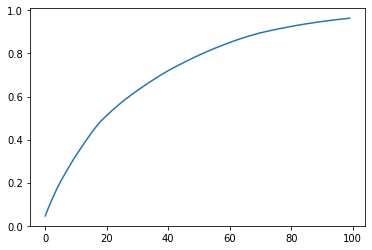

In [2]:
n_pca = 100
eta_list = np.load(file_data)
elev = np.array(eta_list).reshape((np.array(eta_list).shape[0],np.array(eta_list).shape[1]*np.array(eta_list).shape[1]))#np.reshape(np.array(eta_list)[:,35:55,35:55],(100000-1,20*20))
pca = PCA(n_components=n_pca)
pca.fit(elev)
l=pca.fit_transform(elev[:])
ks_t = pca.inverse_transform(l)
plt.plot(pca.explained_variance_ratio_.cumsum())

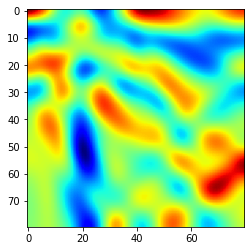

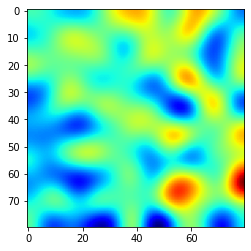

In [3]:
plt.figure(0)
plt.imshow(elev[2500,:].reshape(80,80),cmap = 'jet')
plt.figure(1)
plt.imshow(ks_t[5000,:].reshape(80,80),cmap = 'jet')

In [4]:
X_train = l[2500:-9999,:]
X_test = l[-9999:,:]
batch_size = X_train.shape[0]
nb_batch = int(X_train.shape[0]/batch_size)
dt_integration = 0.01
Grad_t   = np.gradient(X_train)[0].reshape(X_train.shape[0],n_pca)/dt_integration
X_train = X_train.reshape(nb_batch,batch_size,n_pca)
Grad_t  = Grad_t.reshape(nb_batch,batch_size,n_pca)
dim = n_pca
dim_aug = 700

In [5]:
#NN params
params = {}
params['transition_layers']=1
params['bi_linear_layers']=dim_aug
params['dim_hidden_linear'] = dim_aug
params['dim_input']=dim
params['dim_output']=dim_aug
params['dim_latent']=dim_aug-dim
params['dim_observations'] = dim_aug
params['dim_hidden']= dim_aug
params['dt_integration'] = dt_integration
params['Pretrained']     = False

In [6]:
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            y_aug = np.random.uniform(size=(nb_batch,batch_size,params['dim_latent']))
            self.y_aug = torch.nn.Parameter(data=torch.from_numpy(y_aug).float(), requires_grad=True)
            A = np.random.uniform(size=(params['dim_observations'],params['dim_observations']))
            self.A = torch.nn.Parameter(data=torch.from_numpy(A).float(), requires_grad=True)

        def forward(self, inp, dt):
            aug_inp = inp
            A = (self.A-self.A.T)/2
            L_outp  = torch.nn.functional.linear(aug_inp,A)
            #L_outp   = self.linearCell(aug_inp)
            grad = L_outp #+ self.m*(u)
            eig_vals = (torch.symeig(A,eigenvectors=True)[0])
            return grad, aug_inp, eig_vals
model  = FC_net(params)

class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
            self.Dyn_net = model
        def forward(self, inp,dt):
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                k1, aug_inp, eig_vals   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = aug_inp + 0.5*params['dt_integration']*k1[:,:]
                k2, tmp, tmpp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = aug_inp + 0.5*params['dt_integration']*k2[:,:]            
                k3, tmp, tmpp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = aug_inp + params['dt_integration']*k3[:,:]            
                k4, tmp, tmpp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6
            else : 
                k1, aug_inp, eig_vals   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = inp + 0.5*params['dt_integration']*k1
                k2, tmp, tmpp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = inp + 0.5*params['dt_integration']*k2       
                k3, tmp, tmpp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = inp + params['dt_integration']*k3          
                k4, tmp, tmpp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6    
                
            return pred, k1, inp, aug_inp, eig_vals
modelRINN = INT_net(params)

In [7]:
dt = params['dt_integration']
aug_vect = []
x = torch.from_numpy(X_train).float()
z = torch.from_numpy(Grad_t).float()
criterion = torch.nn.MSELoss(reduction='elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(),lr = 0.001)

In [8]:
# Learning loop
if params['Pretrained']:
    modelRINN.load_state_dict(torch.load(output_file_folder + file_name_results + '.pt'))
else:
    for t in range(0,32000):
        for b in range(nb_batch):
            # Forward pass: Compute predicted y by passing x to the model
            inp_concat = torch.cat((x[b,:,:], modelRINN.Dyn_net.y_aug[b,:,:]), dim=1)
            pred, grad, inp, aug_inp, eig_vals = modelRINN(inp_concat,dt)

            # Compute and print loss
            loss1 = criterion(grad[:,:dim], z[b,:,:])
            loss2 = criterion(pred[:-1,:] , aug_inp[1:,:])
            loss =  1.0*loss1+1.0*loss2 # + 50*lossS2 + lossS*10000
            print('3dim_QM_for_const', t,loss)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        torch.save(modelRINN.state_dict(), output_file_folder + file_name_results + '.pt')

/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


3dim_QM_for_const 0 tensor(8796010., grad_fn=<AddBackward0>)
3dim_QM_for_const 1 tensor(8729756., grad_fn=<AddBackward0>)
3dim_QM_for_const 2 tensor(8664272., grad_fn=<AddBackward0>)
3dim_QM_for_const 3 tensor(8599555., grad_fn=<AddBackward0>)
3dim_QM_for_const 4 tensor(8535591., grad_fn=<AddBackward0>)
3dim_QM_for_const 5 tensor(8472369., grad_fn=<AddBackward0>)
3dim_QM_for_const 6 tensor(8409876., grad_fn=<AddBackward0>)
3dim_QM_for_const 7 tensor(8348098., grad_fn=<AddBackward0>)
3dim_QM_for_const 8 tensor(8287021.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 9 tensor(8226625., grad_fn=<AddBackward0>)
3dim_QM_for_const 10 tensor(8166889., grad_fn=<AddBackward0>)
3dim_QM_for_const 11 tensor(8107789.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 12 tensor(8049296.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 13 tensor(7991374.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 14 tensor(7933997., grad_fn=<AddBackward0>)
3dim_QM_for_const 15 tensor(7877132., grad_fn=<AddBackward0>)
3d

3dim_QM_for_const 128 tensor(3476684.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 129 tensor(3451461., grad_fn=<AddBackward0>)
3dim_QM_for_const 130 tensor(3426417.2500, grad_fn=<AddBackward0>)
3dim_QM_for_const 131 tensor(3401551.2500, grad_fn=<AddBackward0>)
3dim_QM_for_const 132 tensor(3376863., grad_fn=<AddBackward0>)
3dim_QM_for_const 133 tensor(3352350., grad_fn=<AddBackward0>)
3dim_QM_for_const 134 tensor(3328011.7500, grad_fn=<AddBackward0>)
3dim_QM_for_const 135 tensor(3303847., grad_fn=<AddBackward0>)
3dim_QM_for_const 136 tensor(3279853.7500, grad_fn=<AddBackward0>)
3dim_QM_for_const 137 tensor(3256031., grad_fn=<AddBackward0>)
3dim_QM_for_const 138 tensor(3232379., grad_fn=<AddBackward0>)
3dim_QM_for_const 139 tensor(3208895., grad_fn=<AddBackward0>)
3dim_QM_for_const 140 tensor(3185578., grad_fn=<AddBackward0>)
3dim_QM_for_const 141 tensor(3162428., grad_fn=<AddBackward0>)
3dim_QM_for_const 142 tensor(3139441., grad_fn=<AddBackward0>)
3dim_QM_for_const 143 tensor(311662

3dim_QM_for_const 253 tensor(1388642.3750, grad_fn=<AddBackward0>)
3dim_QM_for_const 254 tensor(1378417.7500, grad_fn=<AddBackward0>)
3dim_QM_for_const 255 tensor(1368268.2500, grad_fn=<AddBackward0>)
3dim_QM_for_const 256 tensor(1358192., grad_fn=<AddBackward0>)
3dim_QM_for_const 257 tensor(1348190.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 258 tensor(1338261.6250, grad_fn=<AddBackward0>)
3dim_QM_for_const 259 tensor(1328405.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 260 tensor(1318621.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 261 tensor(1308909.2500, grad_fn=<AddBackward0>)
3dim_QM_for_const 262 tensor(1299268.2500, grad_fn=<AddBackward0>)
3dim_QM_for_const 263 tensor(1289697.6250, grad_fn=<AddBackward0>)
3dim_QM_for_const 264 tensor(1280197.2500, grad_fn=<AddBackward0>)
3dim_QM_for_const 265 tensor(1270766.3750, grad_fn=<AddBackward0>)
3dim_QM_for_const 266 tensor(1261404.8750, grad_fn=<AddBackward0>)
3dim_QM_for_const 267 tensor(1252112., grad_fn=<AddBackward0>)
3di

3dim_QM_for_const 377 tensor(556303.9375, grad_fn=<AddBackward0>)
3dim_QM_for_const 378 tensor(552248.0625, grad_fn=<AddBackward0>)
3dim_QM_for_const 379 tensor(548222.7500, grad_fn=<AddBackward0>)
3dim_QM_for_const 380 tensor(544227.6250, grad_fn=<AddBackward0>)
3dim_QM_for_const 381 tensor(540262.6875, grad_fn=<AddBackward0>)
3dim_QM_for_const 382 tensor(536327.7500, grad_fn=<AddBackward0>)
3dim_QM_for_const 383 tensor(532422.3750, grad_fn=<AddBackward0>)
3dim_QM_for_const 384 tensor(528546.5625, grad_fn=<AddBackward0>)
3dim_QM_for_const 385 tensor(524699.8750, grad_fn=<AddBackward0>)
3dim_QM_for_const 386 tensor(520882.1562, grad_fn=<AddBackward0>)
3dim_QM_for_const 387 tensor(517093.2188, grad_fn=<AddBackward0>)
3dim_QM_for_const 388 tensor(513332.8438, grad_fn=<AddBackward0>)
3dim_QM_for_const 389 tensor(509600.9375, grad_fn=<AddBackward0>)
3dim_QM_for_const 390 tensor(505897.1250, grad_fn=<AddBackward0>)
3dim_QM_for_const 391 tensor(502221.3125, grad_fn=<AddBackward0>)
3dim_QM_fo

3dim_QM_for_const 502 tensor(227852.6406, grad_fn=<AddBackward0>)
3dim_QM_for_const 503 tensor(226287.9219, grad_fn=<AddBackward0>)
3dim_QM_for_const 504 tensor(224735.1094, grad_fn=<AddBackward0>)
3dim_QM_for_const 505 tensor(223194.1094, grad_fn=<AddBackward0>)
3dim_QM_for_const 506 tensor(221664.8594, grad_fn=<AddBackward0>)
3dim_QM_for_const 507 tensor(220147.2188, grad_fn=<AddBackward0>)
3dim_QM_for_const 508 tensor(218641.1719, grad_fn=<AddBackward0>)
3dim_QM_for_const 509 tensor(217146.5469, grad_fn=<AddBackward0>)
3dim_QM_for_const 510 tensor(215663.2656, grad_fn=<AddBackward0>)
3dim_QM_for_const 511 tensor(214191.2344, grad_fn=<AddBackward0>)
3dim_QM_for_const 512 tensor(212730.4375, grad_fn=<AddBackward0>)
3dim_QM_for_const 513 tensor(211280.7188, grad_fn=<AddBackward0>)
3dim_QM_for_const 514 tensor(209841.9844, grad_fn=<AddBackward0>)
3dim_QM_for_const 515 tensor(208414.2344, grad_fn=<AddBackward0>)
3dim_QM_for_const 516 tensor(206997.3594, grad_fn=<AddBackward0>)
3dim_QM_fo

3dim_QM_for_const 627 tensor(101068.7734, grad_fn=<AddBackward0>)
3dim_QM_for_const 628 tensor(100459.7188, grad_fn=<AddBackward0>)
3dim_QM_for_const 629 tensor(99855.1250, grad_fn=<AddBackward0>)
3dim_QM_for_const 630 tensor(99254.9766, grad_fn=<AddBackward0>)
3dim_QM_for_const 631 tensor(98659.2500, grad_fn=<AddBackward0>)
3dim_QM_for_const 632 tensor(98067.9219, grad_fn=<AddBackward0>)
3dim_QM_for_const 633 tensor(97480.9141, grad_fn=<AddBackward0>)
3dim_QM_for_const 634 tensor(96898.2500, grad_fn=<AddBackward0>)
3dim_QM_for_const 635 tensor(96319.8281, grad_fn=<AddBackward0>)
3dim_QM_for_const 636 tensor(95745.7031, grad_fn=<AddBackward0>)
3dim_QM_for_const 637 tensor(95175.7812, grad_fn=<AddBackward0>)
3dim_QM_for_const 638 tensor(94610.0469, grad_fn=<AddBackward0>)
3dim_QM_for_const 639 tensor(94048.4219, grad_fn=<AddBackward0>)
3dim_QM_for_const 640 tensor(93490.9453, grad_fn=<AddBackward0>)
3dim_QM_for_const 641 tensor(92937.5625, grad_fn=<AddBackward0>)
3dim_QM_for_const 642 t

3dim_QM_for_const 754 tensor(50282.3320, grad_fn=<AddBackward0>)
3dim_QM_for_const 755 tensor(50035.3594, grad_fn=<AddBackward0>)
3dim_QM_for_const 756 tensor(49790.0547, grad_fn=<AddBackward0>)
3dim_QM_for_const 757 tensor(49546.3984, grad_fn=<AddBackward0>)
3dim_QM_for_const 758 tensor(49304.3867, grad_fn=<AddBackward0>)
3dim_QM_for_const 759 tensor(49063.9805, grad_fn=<AddBackward0>)
3dim_QM_for_const 760 tensor(48825.1992, grad_fn=<AddBackward0>)
3dim_QM_for_const 761 tensor(48588.0039, grad_fn=<AddBackward0>)
3dim_QM_for_const 762 tensor(48352.3906, grad_fn=<AddBackward0>)
3dim_QM_for_const 763 tensor(48118.3555, grad_fn=<AddBackward0>)
3dim_QM_for_const 764 tensor(47885.8906, grad_fn=<AddBackward0>)
3dim_QM_for_const 765 tensor(47654.9766, grad_fn=<AddBackward0>)
3dim_QM_for_const 766 tensor(47425.6016, grad_fn=<AddBackward0>)
3dim_QM_for_const 767 tensor(47197.7422, grad_fn=<AddBackward0>)
3dim_QM_for_const 768 tensor(46971.3945, grad_fn=<AddBackward0>)
3dim_QM_for_const 769 ten

3dim_QM_for_const 881 tensor(28826.3262, grad_fn=<AddBackward0>)
3dim_QM_for_const 882 tensor(28715.1738, grad_fn=<AddBackward0>)
3dim_QM_for_const 883 tensor(28604.6582, grad_fn=<AddBackward0>)
3dim_QM_for_const 884 tensor(28494.7812, grad_fn=<AddBackward0>)
3dim_QM_for_const 885 tensor(28385.5332, grad_fn=<AddBackward0>)
3dim_QM_for_const 886 tensor(28276.9160, grad_fn=<AddBackward0>)
3dim_QM_for_const 887 tensor(28168.9180, grad_fn=<AddBackward0>)
3dim_QM_for_const 888 tensor(28061.5469, grad_fn=<AddBackward0>)
3dim_QM_for_const 889 tensor(27954.7852, grad_fn=<AddBackward0>)
3dim_QM_for_const 890 tensor(27848.6250, grad_fn=<AddBackward0>)
3dim_QM_for_const 891 tensor(27743.0801, grad_fn=<AddBackward0>)
3dim_QM_for_const 892 tensor(27638.1328, grad_fn=<AddBackward0>)
3dim_QM_for_const 893 tensor(27533.7852, grad_fn=<AddBackward0>)
3dim_QM_for_const 894 tensor(27430.0254, grad_fn=<AddBackward0>)
3dim_QM_for_const 895 tensor(27326.8555, grad_fn=<AddBackward0>)
3dim_QM_for_const 896 ten

3dim_QM_for_const 1007 tensor(18676.4707, grad_fn=<AddBackward0>)
3dim_QM_for_const 1008 tensor(18619.3047, grad_fn=<AddBackward0>)
3dim_QM_for_const 1009 tensor(18562.4121, grad_fn=<AddBackward0>)
3dim_QM_for_const 1010 tensor(18505.7949, grad_fn=<AddBackward0>)
3dim_QM_for_const 1011 tensor(18449.4414, grad_fn=<AddBackward0>)
3dim_QM_for_const 1012 tensor(18393.3574, grad_fn=<AddBackward0>)
3dim_QM_for_const 1013 tensor(18337.5352, grad_fn=<AddBackward0>)
3dim_QM_for_const 1014 tensor(18281.9863, grad_fn=<AddBackward0>)
3dim_QM_for_const 1015 tensor(18226.6895, grad_fn=<AddBackward0>)
3dim_QM_for_const 1016 tensor(18171.6602, grad_fn=<AddBackward0>)
3dim_QM_for_const 1017 tensor(18116.8848, grad_fn=<AddBackward0>)
3dim_QM_for_const 1018 tensor(18062.3691, grad_fn=<AddBackward0>)
3dim_QM_for_const 1019 tensor(18008.1152, grad_fn=<AddBackward0>)
3dim_QM_for_const 1020 tensor(17954.1113, grad_fn=<AddBackward0>)
3dim_QM_for_const 1021 tensor(17900.3594, grad_fn=<AddBackward0>)
3dim_QM_fo

3dim_QM_for_const 1132 tensor(13200.0732, grad_fn=<AddBackward0>)
3dim_QM_for_const 1133 tensor(13166.8936, grad_fn=<AddBackward0>)
3dim_QM_for_const 1134 tensor(13133.8428, grad_fn=<AddBackward0>)
3dim_QM_for_const 1135 tensor(13100.9248, grad_fn=<AddBackward0>)
3dim_QM_for_const 1136 tensor(13068.1318, grad_fn=<AddBackward0>)
3dim_QM_for_const 1137 tensor(13035.4697, grad_fn=<AddBackward0>)
3dim_QM_for_const 1138 tensor(13002.9375, grad_fn=<AddBackward0>)
3dim_QM_for_const 1139 tensor(12970.5322, grad_fn=<AddBackward0>)
3dim_QM_for_const 1140 tensor(12938.2520, grad_fn=<AddBackward0>)
3dim_QM_for_const 1141 tensor(12906.0957, grad_fn=<AddBackward0>)
3dim_QM_for_const 1142 tensor(12874.0693, grad_fn=<AddBackward0>)
3dim_QM_for_const 1143 tensor(12842.1660, grad_fn=<AddBackward0>)
3dim_QM_for_const 1144 tensor(12810.3906, grad_fn=<AddBackward0>)
3dim_QM_for_const 1145 tensor(12778.7305, grad_fn=<AddBackward0>)
3dim_QM_for_const 1146 tensor(12747.2031, grad_fn=<AddBackward0>)
3dim_QM_fo

3dim_QM_for_const 1257 tensor(9882.6572, grad_fn=<AddBackward0>)
3dim_QM_for_const 1258 tensor(9861.6055, grad_fn=<AddBackward0>)
3dim_QM_for_const 1259 tensor(9840.6250, grad_fn=<AddBackward0>)
3dim_QM_for_const 1260 tensor(9819.7197, grad_fn=<AddBackward0>)
3dim_QM_for_const 1261 tensor(9798.8828, grad_fn=<AddBackward0>)
3dim_QM_for_const 1262 tensor(9778.1143, grad_fn=<AddBackward0>)
3dim_QM_for_const 1263 tensor(9757.4141, grad_fn=<AddBackward0>)
3dim_QM_for_const 1264 tensor(9736.7812, grad_fn=<AddBackward0>)
3dim_QM_for_const 1265 tensor(9716.2217, grad_fn=<AddBackward0>)
3dim_QM_for_const 1266 tensor(9695.7314, grad_fn=<AddBackward0>)
3dim_QM_for_const 1267 tensor(9675.3076, grad_fn=<AddBackward0>)
3dim_QM_for_const 1268 tensor(9654.9502, grad_fn=<AddBackward0>)
3dim_QM_for_const 1269 tensor(9634.6611, grad_fn=<AddBackward0>)
3dim_QM_for_const 1270 tensor(9614.4404, grad_fn=<AddBackward0>)
3dim_QM_for_const 1271 tensor(9594.2852, grad_fn=<AddBackward0>)
3dim_QM_for_const 1272 te

3dim_QM_for_const 1384 tensor(7683.7275, grad_fn=<AddBackward0>)
3dim_QM_for_const 1385 tensor(7669.5874, grad_fn=<AddBackward0>)
3dim_QM_for_const 1386 tensor(7655.4897, grad_fn=<AddBackward0>)
3dim_QM_for_const 1387 tensor(7641.4321, grad_fn=<AddBackward0>)
3dim_QM_for_const 1388 tensor(7627.4170, grad_fn=<AddBackward0>)
3dim_QM_for_const 1389 tensor(7613.4390, grad_fn=<AddBackward0>)
3dim_QM_for_const 1390 tensor(7599.5049, grad_fn=<AddBackward0>)
3dim_QM_for_const 1391 tensor(7585.6118, grad_fn=<AddBackward0>)
3dim_QM_for_const 1392 tensor(7571.7583, grad_fn=<AddBackward0>)
3dim_QM_for_const 1393 tensor(7557.9438, grad_fn=<AddBackward0>)
3dim_QM_for_const 1394 tensor(7544.1709, grad_fn=<AddBackward0>)
3dim_QM_for_const 1395 tensor(7530.4370, grad_fn=<AddBackward0>)
3dim_QM_for_const 1396 tensor(7516.7441, grad_fn=<AddBackward0>)
3dim_QM_for_const 1397 tensor(7503.0894, grad_fn=<AddBackward0>)
3dim_QM_for_const 1398 tensor(7489.4746, grad_fn=<AddBackward0>)
3dim_QM_for_const 1399 te

3dim_QM_for_const 1511 tensor(6172.4224, grad_fn=<AddBackward0>)
3dim_QM_for_const 1512 tensor(6162.4741, grad_fn=<AddBackward0>)
3dim_QM_for_const 1513 tensor(6152.5498, grad_fn=<AddBackward0>)
3dim_QM_for_const 1514 tensor(6142.6509, grad_fn=<AddBackward0>)
3dim_QM_for_const 1515 tensor(6132.7773, grad_fn=<AddBackward0>)
3dim_QM_for_const 1516 tensor(6122.9307, grad_fn=<AddBackward0>)
3dim_QM_for_const 1517 tensor(6113.1108, grad_fn=<AddBackward0>)
3dim_QM_for_const 1518 tensor(6103.3149, grad_fn=<AddBackward0>)
3dim_QM_for_const 1519 tensor(6093.5454, grad_fn=<AddBackward0>)
3dim_QM_for_const 1520 tensor(6083.7993, grad_fn=<AddBackward0>)
3dim_QM_for_const 1521 tensor(6074.0801, grad_fn=<AddBackward0>)
3dim_QM_for_const 1522 tensor(6064.3867, grad_fn=<AddBackward0>)
3dim_QM_for_const 1523 tensor(6054.7192, grad_fn=<AddBackward0>)
3dim_QM_for_const 1524 tensor(6045.0757, grad_fn=<AddBackward0>)
3dim_QM_for_const 1525 tensor(6035.4561, grad_fn=<AddBackward0>)
3dim_QM_for_const 1526 te

3dim_QM_for_const 1638 tensor(5090.8052, grad_fn=<AddBackward0>)
3dim_QM_for_const 1639 tensor(5083.5571, grad_fn=<AddBackward0>)
3dim_QM_for_const 1640 tensor(5076.3271, grad_fn=<AddBackward0>)
3dim_QM_for_const 1641 tensor(5069.1157, grad_fn=<AddBackward0>)
3dim_QM_for_const 1642 tensor(5061.9189, grad_fn=<AddBackward0>)
3dim_QM_for_const 1643 tensor(5054.7412, grad_fn=<AddBackward0>)
3dim_QM_for_const 1644 tensor(5047.5796, grad_fn=<AddBackward0>)
3dim_QM_for_const 1645 tensor(5040.4336, grad_fn=<AddBackward0>)
3dim_QM_for_const 1646 tensor(5033.3062, grad_fn=<AddBackward0>)
3dim_QM_for_const 1647 tensor(5026.1958, grad_fn=<AddBackward0>)
3dim_QM_for_const 1648 tensor(5019.1030, grad_fn=<AddBackward0>)
3dim_QM_for_const 1649 tensor(5012.0259, grad_fn=<AddBackward0>)
3dim_QM_for_const 1650 tensor(5004.9648, grad_fn=<AddBackward0>)
3dim_QM_for_const 1651 tensor(4997.9204, grad_fn=<AddBackward0>)
3dim_QM_for_const 1652 tensor(4990.8950, grad_fn=<AddBackward0>)
3dim_QM_for_const 1653 te

3dim_QM_for_const 1765 tensor(4292.6265, grad_fn=<AddBackward0>)
3dim_QM_for_const 1766 tensor(4287.2041, grad_fn=<AddBackward0>)
3dim_QM_for_const 1767 tensor(4281.7930, grad_fn=<AddBackward0>)
3dim_QM_for_const 1768 tensor(4276.3965, grad_fn=<AddBackward0>)
3dim_QM_for_const 1769 tensor(4271.0112, grad_fn=<AddBackward0>)
3dim_QM_for_const 1770 tensor(4265.6367, grad_fn=<AddBackward0>)
3dim_QM_for_const 1771 tensor(4260.2744, grad_fn=<AddBackward0>)
3dim_QM_for_const 1772 tensor(4254.9224, grad_fn=<AddBackward0>)
3dim_QM_for_const 1773 tensor(4249.5830, grad_fn=<AddBackward0>)
3dim_QM_for_const 1774 tensor(4244.2563, grad_fn=<AddBackward0>)
3dim_QM_for_const 1775 tensor(4238.9419, grad_fn=<AddBackward0>)
3dim_QM_for_const 1776 tensor(4233.6372, grad_fn=<AddBackward0>)
3dim_QM_for_const 1777 tensor(4228.3438, grad_fn=<AddBackward0>)
3dim_QM_for_const 1778 tensor(4223.0625, grad_fn=<AddBackward0>)
3dim_QM_for_const 1779 tensor(4217.7930, grad_fn=<AddBackward0>)
3dim_QM_for_const 1780 te

3dim_QM_for_const 1892 tensor(3689.1499, grad_fn=<AddBackward0>)
3dim_QM_for_const 1893 tensor(3685.0051, grad_fn=<AddBackward0>)
3dim_QM_for_const 1894 tensor(3680.8691, grad_fn=<AddBackward0>)
3dim_QM_for_const 1895 tensor(3676.7412, grad_fn=<AddBackward0>)
3dim_QM_for_const 1896 tensor(3672.6221, grad_fn=<AddBackward0>)
3dim_QM_for_const 1897 tensor(3668.5105, grad_fn=<AddBackward0>)
3dim_QM_for_const 1898 tensor(3664.4087, grad_fn=<AddBackward0>)
3dim_QM_for_const 1899 tensor(3660.3140, grad_fn=<AddBackward0>)
3dim_QM_for_const 1900 tensor(3656.2285, grad_fn=<AddBackward0>)
3dim_QM_for_const 1901 tensor(3652.1506, grad_fn=<AddBackward0>)
3dim_QM_for_const 1902 tensor(3648.0813, grad_fn=<AddBackward0>)
3dim_QM_for_const 1903 tensor(3644.0208, grad_fn=<AddBackward0>)
3dim_QM_for_const 1904 tensor(3639.9673, grad_fn=<AddBackward0>)
3dim_QM_for_const 1905 tensor(3635.9226, grad_fn=<AddBackward0>)
3dim_QM_for_const 1906 tensor(3631.8857, grad_fn=<AddBackward0>)
3dim_QM_for_const 1907 te

3dim_QM_for_const 2019 tensor(3223.7527, grad_fn=<AddBackward0>)
3dim_QM_for_const 2020 tensor(3220.5264, grad_fn=<AddBackward0>)
3dim_QM_for_const 2021 tensor(3217.3064, grad_fn=<AddBackward0>)
3dim_QM_for_const 2022 tensor(3214.0923, grad_fn=<AddBackward0>)
3dim_QM_for_const 2023 tensor(3210.8848, grad_fn=<AddBackward0>)
3dim_QM_for_const 2024 tensor(3207.6853, grad_fn=<AddBackward0>)
3dim_QM_for_const 2025 tensor(3204.4915, grad_fn=<AddBackward0>)
3dim_QM_for_const 2026 tensor(3201.3042, grad_fn=<AddBackward0>)
3dim_QM_for_const 2027 tensor(3198.1240, grad_fn=<AddBackward0>)
3dim_QM_for_const 2028 tensor(3194.9492, grad_fn=<AddBackward0>)
3dim_QM_for_const 2029 tensor(3191.7778, grad_fn=<AddBackward0>)
3dim_QM_for_const 2030 tensor(3188.6118, grad_fn=<AddBackward0>)
3dim_QM_for_const 2031 tensor(3185.4497, grad_fn=<AddBackward0>)
3dim_QM_for_const 2032 tensor(3182.2930, grad_fn=<AddBackward0>)
3dim_QM_for_const 2033 tensor(3179.1445, grad_fn=<AddBackward0>)
3dim_QM_for_const 2034 te

3dim_QM_for_const 2146 tensor(2858.8193, grad_fn=<AddBackward0>)
3dim_QM_for_const 2147 tensor(2856.2705, grad_fn=<AddBackward0>)
3dim_QM_for_const 2148 tensor(2853.7256, grad_fn=<AddBackward0>)
3dim_QM_for_const 2149 tensor(2851.1853, grad_fn=<AddBackward0>)
3dim_QM_for_const 2150 tensor(2848.6501, grad_fn=<AddBackward0>)
3dim_QM_for_const 2151 tensor(2846.1194, grad_fn=<AddBackward0>)
3dim_QM_for_const 2152 tensor(2843.5928, grad_fn=<AddBackward0>)
3dim_QM_for_const 2153 tensor(2841.0713, grad_fn=<AddBackward0>)
3dim_QM_for_const 2154 tensor(2838.5542, grad_fn=<AddBackward0>)
3dim_QM_for_const 2155 tensor(2836.0415, grad_fn=<AddBackward0>)
3dim_QM_for_const 2156 tensor(2833.5330, grad_fn=<AddBackward0>)
3dim_QM_for_const 2157 tensor(2831.0295, grad_fn=<AddBackward0>)
3dim_QM_for_const 2158 tensor(2828.5308, grad_fn=<AddBackward0>)
3dim_QM_for_const 2159 tensor(2826.0359, grad_fn=<AddBackward0>)
3dim_QM_for_const 2160 tensor(2823.5452, grad_fn=<AddBackward0>)
3dim_QM_for_const 2161 te

3dim_QM_for_const 2273 tensor(2568.5828, grad_fn=<AddBackward0>)
3dim_QM_for_const 2274 tensor(2566.5417, grad_fn=<AddBackward0>)
3dim_QM_for_const 2275 tensor(2564.5039, grad_fn=<AddBackward0>)
3dim_QM_for_const 2276 tensor(2562.4700, grad_fn=<AddBackward0>)
3dim_QM_for_const 2277 tensor(2560.4395, grad_fn=<AddBackward0>)
3dim_QM_for_const 2278 tensor(2558.4126, grad_fn=<AddBackward0>)
3dim_QM_for_const 2279 tensor(2556.3882, grad_fn=<AddBackward0>)
3dim_QM_for_const 2280 tensor(2554.3679, grad_fn=<AddBackward0>)
3dim_QM_for_const 2281 tensor(2552.3508, grad_fn=<AddBackward0>)
3dim_QM_for_const 2282 tensor(2550.3379, grad_fn=<AddBackward0>)
3dim_QM_for_const 2283 tensor(2548.3279, grad_fn=<AddBackward0>)
3dim_QM_for_const 2284 tensor(2546.3218, grad_fn=<AddBackward0>)
3dim_QM_for_const 2285 tensor(2544.3181, grad_fn=<AddBackward0>)
3dim_QM_for_const 2286 tensor(2542.3186, grad_fn=<AddBackward0>)
3dim_QM_for_const 2287 tensor(2540.3210, grad_fn=<AddBackward0>)
3dim_QM_for_const 2288 te

3dim_QM_for_const 2400 tensor(2334.9001, grad_fn=<AddBackward0>)
3dim_QM_for_const 2401 tensor(2333.2485, grad_fn=<AddBackward0>)
3dim_QM_for_const 2402 tensor(2331.5979, grad_fn=<AddBackward0>)
3dim_QM_for_const 2403 tensor(2329.9495, grad_fn=<AddBackward0>)
3dim_QM_for_const 2404 tensor(2328.3022, grad_fn=<AddBackward0>)
3dim_QM_for_const 2405 tensor(2326.6584, grad_fn=<AddBackward0>)
3dim_QM_for_const 2406 tensor(2325.0186, grad_fn=<AddBackward0>)
3dim_QM_for_const 2407 tensor(2323.3826, grad_fn=<AddBackward0>)
3dim_QM_for_const 2408 tensor(2321.7493, grad_fn=<AddBackward0>)
3dim_QM_for_const 2409 tensor(2320.1177, grad_fn=<AddBackward0>)
3dim_QM_for_const 2410 tensor(2318.4883, grad_fn=<AddBackward0>)
3dim_QM_for_const 2411 tensor(2316.8606, grad_fn=<AddBackward0>)
3dim_QM_for_const 2412 tensor(2315.2363, grad_fn=<AddBackward0>)
3dim_QM_for_const 2413 tensor(2313.6157, grad_fn=<AddBackward0>)
3dim_QM_for_const 2414 tensor(2311.9985, grad_fn=<AddBackward0>)
3dim_QM_for_const 2415 te

3dim_QM_for_const 2527 tensor(2144.7065, grad_fn=<AddBackward0>)
3dim_QM_for_const 2528 tensor(2143.3542, grad_fn=<AddBackward0>)
3dim_QM_for_const 2529 tensor(2142.0039, grad_fn=<AddBackward0>)
3dim_QM_for_const 2530 tensor(2140.6558, grad_fn=<AddBackward0>)
3dim_QM_for_const 2531 tensor(2139.3096, grad_fn=<AddBackward0>)
3dim_QM_for_const 2532 tensor(2137.9661, grad_fn=<AddBackward0>)
3dim_QM_for_const 2533 tensor(2136.6240, grad_fn=<AddBackward0>)
3dim_QM_for_const 2534 tensor(2135.2844, grad_fn=<AddBackward0>)
3dim_QM_for_const 2535 tensor(2133.9468, grad_fn=<AddBackward0>)
3dim_QM_for_const 2536 tensor(2132.6108, grad_fn=<AddBackward0>)
3dim_QM_for_const 2537 tensor(2131.2769, grad_fn=<AddBackward0>)
3dim_QM_for_const 2538 tensor(2129.9458, grad_fn=<AddBackward0>)
3dim_QM_for_const 2539 tensor(2128.6165, grad_fn=<AddBackward0>)
3dim_QM_for_const 2540 tensor(2127.2891, grad_fn=<AddBackward0>)
3dim_QM_for_const 2541 tensor(2125.9639, grad_fn=<AddBackward0>)
3dim_QM_for_const 2542 te

3dim_QM_for_const 2654 tensor(1988.4474, grad_fn=<AddBackward0>)
3dim_QM_for_const 2655 tensor(1987.3315, grad_fn=<AddBackward0>)
3dim_QM_for_const 2656 tensor(1986.2144, grad_fn=<AddBackward0>)
3dim_QM_for_const 2657 tensor(1985.0989, grad_fn=<AddBackward0>)
3dim_QM_for_const 2658 tensor(1983.9875, grad_fn=<AddBackward0>)
3dim_QM_for_const 2659 tensor(1982.8795, grad_fn=<AddBackward0>)
3dim_QM_for_const 2660 tensor(1981.7723, grad_fn=<AddBackward0>)
3dim_QM_for_const 2661 tensor(1980.6648, grad_fn=<AddBackward0>)
3dim_QM_for_const 2662 tensor(1979.5586, grad_fn=<AddBackward0>)
3dim_QM_for_const 2663 tensor(1978.4543, grad_fn=<AddBackward0>)
3dim_QM_for_const 2664 tensor(1977.3527, grad_fn=<AddBackward0>)
3dim_QM_for_const 2665 tensor(1976.2527, grad_fn=<AddBackward0>)
3dim_QM_for_const 2666 tensor(1975.1552, grad_fn=<AddBackward0>)
3dim_QM_for_const 2667 tensor(1974.0582, grad_fn=<AddBackward0>)
3dim_QM_for_const 2668 tensor(1972.9636, grad_fn=<AddBackward0>)
3dim_QM_for_const 2669 te

3dim_QM_for_const 2781 tensor(1858.9567, grad_fn=<AddBackward0>)
3dim_QM_for_const 2782 tensor(1858.0304, grad_fn=<AddBackward0>)
3dim_QM_for_const 2783 tensor(1857.1053, grad_fn=<AddBackward0>)
3dim_QM_for_const 2784 tensor(1856.1808, grad_fn=<AddBackward0>)
3dim_QM_for_const 2785 tensor(1855.2552, grad_fn=<AddBackward0>)
3dim_QM_for_const 2786 tensor(1854.3293, grad_fn=<AddBackward0>)
3dim_QM_for_const 2787 tensor(1853.4032, grad_fn=<AddBackward0>)
3dim_QM_for_const 2788 tensor(1852.4805, grad_fn=<AddBackward0>)
3dim_QM_for_const 2789 tensor(1851.5612, grad_fn=<AddBackward0>)
3dim_QM_for_const 2790 tensor(1850.6451, grad_fn=<AddBackward0>)
3dim_QM_for_const 2791 tensor(1849.7308, grad_fn=<AddBackward0>)
3dim_QM_for_const 2792 tensor(1848.8175, grad_fn=<AddBackward0>)
3dim_QM_for_const 2793 tensor(1847.9049, grad_fn=<AddBackward0>)
3dim_QM_for_const 2794 tensor(1846.9935, grad_fn=<AddBackward0>)
3dim_QM_for_const 2795 tensor(1846.0842, grad_fn=<AddBackward0>)
3dim_QM_for_const 2796 te

3dim_QM_for_const 2908 tensor(1750.8446, grad_fn=<AddBackward0>)
3dim_QM_for_const 2909 tensor(1750.0702, grad_fn=<AddBackward0>)
3dim_QM_for_const 2910 tensor(1749.2991, grad_fn=<AddBackward0>)
3dim_QM_for_const 2911 tensor(1748.5234, grad_fn=<AddBackward0>)
3dim_QM_for_const 2912 tensor(1747.7433, grad_fn=<AddBackward0>)
3dim_QM_for_const 2913 tensor(1746.9652, grad_fn=<AddBackward0>)
3dim_QM_for_const 2914 tensor(1746.1945, grad_fn=<AddBackward0>)
3dim_QM_for_const 2915 tensor(1745.4291, grad_fn=<AddBackward0>)
3dim_QM_for_const 2916 tensor(1744.6622, grad_fn=<AddBackward0>)
3dim_QM_for_const 2917 tensor(1743.8937, grad_fn=<AddBackward0>)
3dim_QM_for_const 2918 tensor(1743.1260, grad_fn=<AddBackward0>)
3dim_QM_for_const 2919 tensor(1742.3616, grad_fn=<AddBackward0>)
3dim_QM_for_const 2920 tensor(1741.5961, grad_fn=<AddBackward0>)
3dim_QM_for_const 2921 tensor(1740.8241, grad_fn=<AddBackward0>)
3dim_QM_for_const 2922 tensor(1740.0499, grad_fn=<AddBackward0>)
3dim_QM_for_const 2923 te

3dim_QM_for_const 3035 tensor(1659.9733, grad_fn=<AddBackward0>)
3dim_QM_for_const 3036 tensor(1659.3167, grad_fn=<AddBackward0>)
3dim_QM_for_const 3037 tensor(1658.6591, grad_fn=<AddBackward0>)
3dim_QM_for_const 3038 tensor(1658.0027, grad_fn=<AddBackward0>)
3dim_QM_for_const 3039 tensor(1657.3488, grad_fn=<AddBackward0>)
3dim_QM_for_const 3040 tensor(1656.6965, grad_fn=<AddBackward0>)
3dim_QM_for_const 3041 tensor(1656.0453, grad_fn=<AddBackward0>)
3dim_QM_for_const 3042 tensor(1655.3937, grad_fn=<AddBackward0>)
3dim_QM_for_const 3043 tensor(1654.7427, grad_fn=<AddBackward0>)
3dim_QM_for_const 3044 tensor(1654.0925, grad_fn=<AddBackward0>)
3dim_QM_for_const 3045 tensor(1653.4442, grad_fn=<AddBackward0>)
3dim_QM_for_const 3046 tensor(1652.7968, grad_fn=<AddBackward0>)
3dim_QM_for_const 3047 tensor(1652.1498, grad_fn=<AddBackward0>)
3dim_QM_for_const 3048 tensor(1651.5037, grad_fn=<AddBackward0>)
3dim_QM_for_const 3049 tensor(1650.8583, grad_fn=<AddBackward0>)
3dim_QM_for_const 3050 te

3dim_QM_for_const 3162 tensor(1583.1100, grad_fn=<AddBackward0>)
3dim_QM_for_const 3163 tensor(1582.5543, grad_fn=<AddBackward0>)
3dim_QM_for_const 3164 tensor(1581.9996, grad_fn=<AddBackward0>)
3dim_QM_for_const 3165 tensor(1581.4458, grad_fn=<AddBackward0>)
3dim_QM_for_const 3166 tensor(1580.8928, grad_fn=<AddBackward0>)
3dim_QM_for_const 3167 tensor(1580.3411, grad_fn=<AddBackward0>)
3dim_QM_for_const 3168 tensor(1579.7904, grad_fn=<AddBackward0>)
3dim_QM_for_const 3169 tensor(1579.2400, grad_fn=<AddBackward0>)
3dim_QM_for_const 3170 tensor(1578.6903, grad_fn=<AddBackward0>)
3dim_QM_for_const 3171 tensor(1578.1394, grad_fn=<AddBackward0>)
3dim_QM_for_const 3172 tensor(1577.5862, grad_fn=<AddBackward0>)
3dim_QM_for_const 3173 tensor(1577.0328, grad_fn=<AddBackward0>)
3dim_QM_for_const 3174 tensor(1576.4822, grad_fn=<AddBackward0>)
3dim_QM_for_const 3175 tensor(1575.9359, grad_fn=<AddBackward0>)
3dim_QM_for_const 3176 tensor(1575.3940, grad_fn=<AddBackward0>)
3dim_QM_for_const 3177 te

3dim_QM_for_const 3289 tensor(1517.7441, grad_fn=<AddBackward0>)
3dim_QM_for_const 3290 tensor(1517.2709, grad_fn=<AddBackward0>)
3dim_QM_for_const 3291 tensor(1516.7965, grad_fn=<AddBackward0>)
3dim_QM_for_const 3292 tensor(1516.3230, grad_fn=<AddBackward0>)
3dim_QM_for_const 3293 tensor(1515.8507, grad_fn=<AddBackward0>)
3dim_QM_for_const 3294 tensor(1515.3812, grad_fn=<AddBackward0>)
3dim_QM_for_const 3295 tensor(1514.9125, grad_fn=<AddBackward0>)
3dim_QM_for_const 3296 tensor(1514.4434, grad_fn=<AddBackward0>)
3dim_QM_for_const 3297 tensor(1513.9724, grad_fn=<AddBackward0>)
3dim_QM_for_const 3298 tensor(1513.5010, grad_fn=<AddBackward0>)
3dim_QM_for_const 3299 tensor(1513.0300, grad_fn=<AddBackward0>)
3dim_QM_for_const 3300 tensor(1512.5613, grad_fn=<AddBackward0>)
3dim_QM_for_const 3301 tensor(1512.0952, grad_fn=<AddBackward0>)
3dim_QM_for_const 3302 tensor(1511.6306, grad_fn=<AddBackward0>)
3dim_QM_for_const 3303 tensor(1511.1658, grad_fn=<AddBackward0>)
3dim_QM_for_const 3304 te

3dim_QM_for_const 3416 tensor(1461.8860, grad_fn=<AddBackward0>)
3dim_QM_for_const 3417 tensor(1461.4780, grad_fn=<AddBackward0>)
3dim_QM_for_const 3418 tensor(1461.0718, grad_fn=<AddBackward0>)
3dim_QM_for_const 3419 tensor(1460.6694, grad_fn=<AddBackward0>)
3dim_QM_for_const 3420 tensor(1460.2715, grad_fn=<AddBackward0>)
3dim_QM_for_const 3421 tensor(1459.8760, grad_fn=<AddBackward0>)
3dim_QM_for_const 3422 tensor(1459.4802, grad_fn=<AddBackward0>)
3dim_QM_for_const 3423 tensor(1459.0793, grad_fn=<AddBackward0>)
3dim_QM_for_const 3424 tensor(1458.6714, grad_fn=<AddBackward0>)
3dim_QM_for_const 3425 tensor(1458.2585, grad_fn=<AddBackward0>)
3dim_QM_for_const 3426 tensor(1457.8459, grad_fn=<AddBackward0>)
3dim_QM_for_const 3427 tensor(1457.4392, grad_fn=<AddBackward0>)
3dim_QM_for_const 3428 tensor(1457.0406, grad_fn=<AddBackward0>)
3dim_QM_for_const 3429 tensor(1456.6467, grad_fn=<AddBackward0>)
3dim_QM_for_const 3430 tensor(1456.2520, grad_fn=<AddBackward0>)
3dim_QM_for_const 3431 te

3dim_QM_for_const 3543 tensor(1413.9048, grad_fn=<AddBackward0>)
3dim_QM_for_const 3544 tensor(1413.5591, grad_fn=<AddBackward0>)
3dim_QM_for_const 3545 tensor(1413.2125, grad_fn=<AddBackward0>)
3dim_QM_for_const 3546 tensor(1412.8635, grad_fn=<AddBackward0>)
3dim_QM_for_const 3547 tensor(1412.5134, grad_fn=<AddBackward0>)
3dim_QM_for_const 3548 tensor(1412.1638, grad_fn=<AddBackward0>)
3dim_QM_for_const 3549 tensor(1411.8164, grad_fn=<AddBackward0>)
3dim_QM_for_const 3550 tensor(1411.4695, grad_fn=<AddBackward0>)
3dim_QM_for_const 3551 tensor(1411.1223, grad_fn=<AddBackward0>)
3dim_QM_for_const 3552 tensor(1410.7731, grad_fn=<AddBackward0>)
3dim_QM_for_const 3553 tensor(1410.4226, grad_fn=<AddBackward0>)
3dim_QM_for_const 3554 tensor(1410.0735, grad_fn=<AddBackward0>)
3dim_QM_for_const 3555 tensor(1409.7266, grad_fn=<AddBackward0>)
3dim_QM_for_const 3556 tensor(1409.3823, grad_fn=<AddBackward0>)
3dim_QM_for_const 3557 tensor(1409.0389, grad_fn=<AddBackward0>)
3dim_QM_for_const 3558 te

3dim_QM_for_const 3670 tensor(1372.5273, grad_fn=<AddBackward0>)
3dim_QM_for_const 3671 tensor(1372.2258, grad_fn=<AddBackward0>)
3dim_QM_for_const 3672 tensor(1371.9248, grad_fn=<AddBackward0>)
3dim_QM_for_const 3673 tensor(1371.6243, grad_fn=<AddBackward0>)
3dim_QM_for_const 3674 tensor(1371.3243, grad_fn=<AddBackward0>)
3dim_QM_for_const 3675 tensor(1371.0258, grad_fn=<AddBackward0>)
3dim_QM_for_const 3676 tensor(1370.7281, grad_fn=<AddBackward0>)
3dim_QM_for_const 3677 tensor(1370.4299, grad_fn=<AddBackward0>)
3dim_QM_for_const 3678 tensor(1370.1305, grad_fn=<AddBackward0>)
3dim_QM_for_const 3679 tensor(1369.8281, grad_fn=<AddBackward0>)
3dim_QM_for_const 3680 tensor(1369.5261, grad_fn=<AddBackward0>)
3dim_QM_for_const 3681 tensor(1369.2263, grad_fn=<AddBackward0>)
3dim_QM_for_const 3682 tensor(1368.9302, grad_fn=<AddBackward0>)
3dim_QM_for_const 3683 tensor(1368.6367, grad_fn=<AddBackward0>)
3dim_QM_for_const 3684 tensor(1368.3420, grad_fn=<AddBackward0>)
3dim_QM_for_const 3685 te

3dim_QM_for_const 3797 tensor(1336.7212, grad_fn=<AddBackward0>)
3dim_QM_for_const 3798 tensor(1336.4608, grad_fn=<AddBackward0>)
3dim_QM_for_const 3799 tensor(1336.2002, grad_fn=<AddBackward0>)
3dim_QM_for_const 3800 tensor(1335.9386, grad_fn=<AddBackward0>)
3dim_QM_for_const 3801 tensor(1335.6766, grad_fn=<AddBackward0>)
3dim_QM_for_const 3802 tensor(1335.4152, grad_fn=<AddBackward0>)
3dim_QM_for_const 3803 tensor(1335.1554, grad_fn=<AddBackward0>)
3dim_QM_for_const 3804 tensor(1334.8962, grad_fn=<AddBackward0>)
3dim_QM_for_const 3805 tensor(1334.6376, grad_fn=<AddBackward0>)
3dim_QM_for_const 3806 tensor(1334.3785, grad_fn=<AddBackward0>)
3dim_QM_for_const 3807 tensor(1334.1188, grad_fn=<AddBackward0>)
3dim_QM_for_const 3808 tensor(1333.8578, grad_fn=<AddBackward0>)
3dim_QM_for_const 3809 tensor(1333.5961, grad_fn=<AddBackward0>)
3dim_QM_for_const 3810 tensor(1333.3359, grad_fn=<AddBackward0>)
3dim_QM_for_const 3811 tensor(1333.0792, grad_fn=<AddBackward0>)
3dim_QM_for_const 3812 te

3dim_QM_for_const 3924 tensor(1305.6086, grad_fn=<AddBackward0>)
3dim_QM_for_const 3925 tensor(1305.3854, grad_fn=<AddBackward0>)
3dim_QM_for_const 3926 tensor(1305.1608, grad_fn=<AddBackward0>)
3dim_QM_for_const 3927 tensor(1304.9344, grad_fn=<AddBackward0>)
3dim_QM_for_const 3928 tensor(1304.7075, grad_fn=<AddBackward0>)
3dim_QM_for_const 3929 tensor(1304.4794, grad_fn=<AddBackward0>)
3dim_QM_for_const 3930 tensor(1304.2496, grad_fn=<AddBackward0>)
3dim_QM_for_const 3931 tensor(1304.0184, grad_fn=<AddBackward0>)
3dim_QM_for_const 3932 tensor(1303.7876, grad_fn=<AddBackward0>)
3dim_QM_for_const 3933 tensor(1303.5588, grad_fn=<AddBackward0>)
3dim_QM_for_const 3934 tensor(1303.3322, grad_fn=<AddBackward0>)
3dim_QM_for_const 3935 tensor(1303.1069, grad_fn=<AddBackward0>)
3dim_QM_for_const 3936 tensor(1302.8810, grad_fn=<AddBackward0>)
3dim_QM_for_const 3937 tensor(1302.6549, grad_fn=<AddBackward0>)
3dim_QM_for_const 3938 tensor(1302.4296, grad_fn=<AddBackward0>)
3dim_QM_for_const 3939 te

3dim_QM_for_const 4051 tensor(1278.5223, grad_fn=<AddBackward0>)
3dim_QM_for_const 4052 tensor(1278.3340, grad_fn=<AddBackward0>)
3dim_QM_for_const 4053 tensor(1278.1423, grad_fn=<AddBackward0>)
3dim_QM_for_const 4054 tensor(1277.9437, grad_fn=<AddBackward0>)
3dim_QM_for_const 4055 tensor(1277.7362, grad_fn=<AddBackward0>)
3dim_QM_for_const 4056 tensor(1277.5228, grad_fn=<AddBackward0>)
3dim_QM_for_const 4057 tensor(1277.3102, grad_fn=<AddBackward0>)
3dim_QM_for_const 4058 tensor(1277.1038, grad_fn=<AddBackward0>)
3dim_QM_for_const 4059 tensor(1276.9055, grad_fn=<AddBackward0>)
3dim_QM_for_const 4060 tensor(1276.7125, grad_fn=<AddBackward0>)
3dim_QM_for_const 4061 tensor(1276.5199, grad_fn=<AddBackward0>)
3dim_QM_for_const 4062 tensor(1276.3234, grad_fn=<AddBackward0>)
3dim_QM_for_const 4063 tensor(1276.1224, grad_fn=<AddBackward0>)
3dim_QM_for_const 4064 tensor(1275.9215, grad_fn=<AddBackward0>)
3dim_QM_for_const 4065 tensor(1275.7227, grad_fn=<AddBackward0>)
3dim_QM_for_const 4066 te

3dim_QM_for_const 4178 tensor(1254.7677, grad_fn=<AddBackward0>)
3dim_QM_for_const 4179 tensor(1254.5917, grad_fn=<AddBackward0>)
3dim_QM_for_const 4180 tensor(1254.4170, grad_fn=<AddBackward0>)
3dim_QM_for_const 4181 tensor(1254.2438, grad_fn=<AddBackward0>)
3dim_QM_for_const 4182 tensor(1254.0718, grad_fn=<AddBackward0>)
3dim_QM_for_const 4183 tensor(1253.9003, grad_fn=<AddBackward0>)
3dim_QM_for_const 4184 tensor(1253.7280, grad_fn=<AddBackward0>)
3dim_QM_for_const 4185 tensor(1253.5554, grad_fn=<AddBackward0>)
3dim_QM_for_const 4186 tensor(1253.3817, grad_fn=<AddBackward0>)
3dim_QM_for_const 4187 tensor(1253.2085, grad_fn=<AddBackward0>)
3dim_QM_for_const 4188 tensor(1253.0361, grad_fn=<AddBackward0>)
3dim_QM_for_const 4189 tensor(1252.8650, grad_fn=<AddBackward0>)
3dim_QM_for_const 4190 tensor(1252.6957, grad_fn=<AddBackward0>)
3dim_QM_for_const 4191 tensor(1252.5253, grad_fn=<AddBackward0>)
3dim_QM_for_const 4192 tensor(1252.3521, grad_fn=<AddBackward0>)
3dim_QM_for_const 4193 te

3dim_QM_for_const 4305 tensor(1233.9659, grad_fn=<AddBackward0>)
3dim_QM_for_const 4306 tensor(1233.8130, grad_fn=<AddBackward0>)
3dim_QM_for_const 4307 tensor(1233.6595, grad_fn=<AddBackward0>)
3dim_QM_for_const 4308 tensor(1233.5035, grad_fn=<AddBackward0>)
3dim_QM_for_const 4309 tensor(1233.3473, grad_fn=<AddBackward0>)
3dim_QM_for_const 4310 tensor(1233.1917, grad_fn=<AddBackward0>)
3dim_QM_for_const 4311 tensor(1233.0387, grad_fn=<AddBackward0>)
3dim_QM_for_const 4312 tensor(1232.8883, grad_fn=<AddBackward0>)
3dim_QM_for_const 4313 tensor(1232.7393, grad_fn=<AddBackward0>)
3dim_QM_for_const 4314 tensor(1232.5898, grad_fn=<AddBackward0>)
3dim_QM_for_const 4315 tensor(1232.4384, grad_fn=<AddBackward0>)
3dim_QM_for_const 4316 tensor(1232.2856, grad_fn=<AddBackward0>)
3dim_QM_for_const 4317 tensor(1232.1322, grad_fn=<AddBackward0>)
3dim_QM_for_const 4318 tensor(1231.9800, grad_fn=<AddBackward0>)
3dim_QM_for_const 4319 tensor(1231.8293, grad_fn=<AddBackward0>)
3dim_QM_for_const 4320 te

3dim_QM_for_const 4432 tensor(1215.6699, grad_fn=<AddBackward0>)
3dim_QM_for_const 4433 tensor(1215.5350, grad_fn=<AddBackward0>)
3dim_QM_for_const 4434 tensor(1215.4043, grad_fn=<AddBackward0>)
3dim_QM_for_const 4435 tensor(1215.2747, grad_fn=<AddBackward0>)
3dim_QM_for_const 4436 tensor(1215.1417, grad_fn=<AddBackward0>)
3dim_QM_for_const 4437 tensor(1215.0028, grad_fn=<AddBackward0>)
3dim_QM_for_const 4438 tensor(1214.8595, grad_fn=<AddBackward0>)
3dim_QM_for_const 4439 tensor(1214.7184, grad_fn=<AddBackward0>)
3dim_QM_for_const 4440 tensor(1214.5835, grad_fn=<AddBackward0>)
3dim_QM_for_const 4441 tensor(1214.4536, grad_fn=<AddBackward0>)
3dim_QM_for_const 4442 tensor(1214.3247, grad_fn=<AddBackward0>)
3dim_QM_for_const 4443 tensor(1214.1932, grad_fn=<AddBackward0>)
3dim_QM_for_const 4444 tensor(1214.0591, grad_fn=<AddBackward0>)
3dim_QM_for_const 4445 tensor(1213.9252, grad_fn=<AddBackward0>)
3dim_QM_for_const 4446 tensor(1213.7928, grad_fn=<AddBackward0>)
3dim_QM_for_const 4447 te

3dim_QM_for_const 4559 tensor(1199.5320, grad_fn=<AddBackward0>)
3dim_QM_for_const 4560 tensor(1199.4113, grad_fn=<AddBackward0>)
3dim_QM_for_const 4561 tensor(1199.2911, grad_fn=<AddBackward0>)
3dim_QM_for_const 4562 tensor(1199.1725, grad_fn=<AddBackward0>)
3dim_QM_for_const 4563 tensor(1199.0551, grad_fn=<AddBackward0>)
3dim_QM_for_const 4564 tensor(1198.9355, grad_fn=<AddBackward0>)
3dim_QM_for_const 4565 tensor(1198.8145, grad_fn=<AddBackward0>)
3dim_QM_for_const 4566 tensor(1198.6918, grad_fn=<AddBackward0>)
3dim_QM_for_const 4567 tensor(1198.5709, grad_fn=<AddBackward0>)
3dim_QM_for_const 4568 tensor(1198.4541, grad_fn=<AddBackward0>)
3dim_QM_for_const 4569 tensor(1198.3398, grad_fn=<AddBackward0>)
3dim_QM_for_const 4570 tensor(1198.2255, grad_fn=<AddBackward0>)
3dim_QM_for_const 4571 tensor(1198.1072, grad_fn=<AddBackward0>)
3dim_QM_for_const 4572 tensor(1197.9847, grad_fn=<AddBackward0>)
3dim_QM_for_const 4573 tensor(1197.8624, grad_fn=<AddBackward0>)
3dim_QM_for_const 4574 te

3dim_QM_for_const 4686 tensor(1185.2473, grad_fn=<AddBackward0>)
3dim_QM_for_const 4687 tensor(1185.1425, grad_fn=<AddBackward0>)
3dim_QM_for_const 4688 tensor(1185.0353, grad_fn=<AddBackward0>)
3dim_QM_for_const 4689 tensor(1184.9233, grad_fn=<AddBackward0>)
3dim_QM_for_const 4690 tensor(1184.8087, grad_fn=<AddBackward0>)
3dim_QM_for_const 4691 tensor(1184.6957, grad_fn=<AddBackward0>)
3dim_QM_for_const 4692 tensor(1184.5881, grad_fn=<AddBackward0>)
3dim_QM_for_const 4693 tensor(1184.4858, grad_fn=<AddBackward0>)
3dim_QM_for_const 4694 tensor(1184.3859, grad_fn=<AddBackward0>)
3dim_QM_for_const 4695 tensor(1184.2836, grad_fn=<AddBackward0>)
3dim_QM_for_const 4696 tensor(1184.1775, grad_fn=<AddBackward0>)
3dim_QM_for_const 4697 tensor(1184.0695, grad_fn=<AddBackward0>)
3dim_QM_for_const 4698 tensor(1183.9635, grad_fn=<AddBackward0>)
3dim_QM_for_const 4699 tensor(1183.8605, grad_fn=<AddBackward0>)
3dim_QM_for_const 4700 tensor(1183.7590, grad_fn=<AddBackward0>)
3dim_QM_for_const 4701 te

3dim_QM_for_const 4813 tensor(1172.5555, grad_fn=<AddBackward0>)
3dim_QM_for_const 4814 tensor(1172.4635, grad_fn=<AddBackward0>)
3dim_QM_for_const 4815 tensor(1172.3701, grad_fn=<AddBackward0>)
3dim_QM_for_const 4816 tensor(1172.2771, grad_fn=<AddBackward0>)
3dim_QM_for_const 4817 tensor(1172.1842, grad_fn=<AddBackward0>)
3dim_QM_for_const 4818 tensor(1172.0917, grad_fn=<AddBackward0>)
3dim_QM_for_const 4819 tensor(1171.9990, grad_fn=<AddBackward0>)
3dim_QM_for_const 4820 tensor(1171.9049, grad_fn=<AddBackward0>)
3dim_QM_for_const 4821 tensor(1171.8091, grad_fn=<AddBackward0>)
3dim_QM_for_const 4822 tensor(1171.7102, grad_fn=<AddBackward0>)
3dim_QM_for_const 4823 tensor(1171.6099, grad_fn=<AddBackward0>)
3dim_QM_for_const 4824 tensor(1171.5112, grad_fn=<AddBackward0>)
3dim_QM_for_const 4825 tensor(1171.4165, grad_fn=<AddBackward0>)
3dim_QM_for_const 4826 tensor(1171.3259, grad_fn=<AddBackward0>)
3dim_QM_for_const 4827 tensor(1171.2372, grad_fn=<AddBackward0>)
3dim_QM_for_const 4828 te

3dim_QM_for_const 4940 tensor(1161.2808, grad_fn=<AddBackward0>)
3dim_QM_for_const 4941 tensor(1161.1940, grad_fn=<AddBackward0>)
3dim_QM_for_const 4942 tensor(1161.1051, grad_fn=<AddBackward0>)
3dim_QM_for_const 4943 tensor(1161.0173, grad_fn=<AddBackward0>)
3dim_QM_for_const 4944 tensor(1160.9337, grad_fn=<AddBackward0>)
3dim_QM_for_const 4945 tensor(1160.8552, grad_fn=<AddBackward0>)
3dim_QM_for_const 4946 tensor(1160.7812, grad_fn=<AddBackward0>)
3dim_QM_for_const 4947 tensor(1160.7075, grad_fn=<AddBackward0>)
3dim_QM_for_const 4948 tensor(1160.6315, grad_fn=<AddBackward0>)
3dim_QM_for_const 4949 tensor(1160.5510, grad_fn=<AddBackward0>)
3dim_QM_for_const 4950 tensor(1160.4664, grad_fn=<AddBackward0>)
3dim_QM_for_const 4951 tensor(1160.3795, grad_fn=<AddBackward0>)
3dim_QM_for_const 4952 tensor(1160.2916, grad_fn=<AddBackward0>)
3dim_QM_for_const 4953 tensor(1160.2046, grad_fn=<AddBackward0>)
3dim_QM_for_const 4954 tensor(1160.1206, grad_fn=<AddBackward0>)
3dim_QM_for_const 4955 te

3dim_QM_for_const 5067 tensor(1151.2314, grad_fn=<AddBackward0>)
3dim_QM_for_const 5068 tensor(1151.1516, grad_fn=<AddBackward0>)
3dim_QM_for_const 5069 tensor(1151.0747, grad_fn=<AddBackward0>)
3dim_QM_for_const 5070 tensor(1151.0034, grad_fn=<AddBackward0>)
3dim_QM_for_const 5071 tensor(1150.9355, grad_fn=<AddBackward0>)
3dim_QM_for_const 5072 tensor(1150.8687, grad_fn=<AddBackward0>)
3dim_QM_for_const 5073 tensor(1150.7985, grad_fn=<AddBackward0>)
3dim_QM_for_const 5074 tensor(1150.7242, grad_fn=<AddBackward0>)
3dim_QM_for_const 5075 tensor(1150.6464, grad_fn=<AddBackward0>)
3dim_QM_for_const 5076 tensor(1150.5664, grad_fn=<AddBackward0>)
3dim_QM_for_const 5077 tensor(1150.4879, grad_fn=<AddBackward0>)
3dim_QM_for_const 5078 tensor(1150.4143, grad_fn=<AddBackward0>)
3dim_QM_for_const 5079 tensor(1150.3461, grad_fn=<AddBackward0>)
3dim_QM_for_const 5080 tensor(1150.2773, grad_fn=<AddBackward0>)
3dim_QM_for_const 5081 tensor(1150.2020, grad_fn=<AddBackward0>)
3dim_QM_for_const 5082 te

3dim_QM_for_const 5194 tensor(1142.1432, grad_fn=<AddBackward0>)
3dim_QM_for_const 5195 tensor(1142.0803, grad_fn=<AddBackward0>)
3dim_QM_for_const 5196 tensor(1142.0167, grad_fn=<AddBackward0>)
3dim_QM_for_const 5197 tensor(1141.9521, grad_fn=<AddBackward0>)
3dim_QM_for_const 5198 tensor(1141.8854, grad_fn=<AddBackward0>)
3dim_QM_for_const 5199 tensor(1141.8164, grad_fn=<AddBackward0>)
3dim_QM_for_const 5200 tensor(1141.7448, grad_fn=<AddBackward0>)
3dim_QM_for_const 5201 tensor(1141.6741, grad_fn=<AddBackward0>)
3dim_QM_for_const 5202 tensor(1141.6053, grad_fn=<AddBackward0>)
3dim_QM_for_const 5203 tensor(1141.5399, grad_fn=<AddBackward0>)
3dim_QM_for_const 5204 tensor(1141.4753, grad_fn=<AddBackward0>)
3dim_QM_for_const 5205 tensor(1141.4103, grad_fn=<AddBackward0>)
3dim_QM_for_const 5206 tensor(1141.3429, grad_fn=<AddBackward0>)
3dim_QM_for_const 5207 tensor(1141.2737, grad_fn=<AddBackward0>)
3dim_QM_for_const 5208 tensor(1141.2047, grad_fn=<AddBackward0>)
3dim_QM_for_const 5209 te

3dim_QM_for_const 5321 tensor(1134.0150, grad_fn=<AddBackward0>)
3dim_QM_for_const 5322 tensor(1133.9575, grad_fn=<AddBackward0>)
3dim_QM_for_const 5323 tensor(1133.8981, grad_fn=<AddBackward0>)
3dim_QM_for_const 5324 tensor(1133.8387, grad_fn=<AddBackward0>)
3dim_QM_for_const 5325 tensor(1133.7786, grad_fn=<AddBackward0>)
3dim_QM_for_const 5326 tensor(1133.7159, grad_fn=<AddBackward0>)
3dim_QM_for_const 5327 tensor(1133.6499, grad_fn=<AddBackward0>)
3dim_QM_for_const 5328 tensor(1133.5826, grad_fn=<AddBackward0>)
3dim_QM_for_const 5329 tensor(1133.5190, grad_fn=<AddBackward0>)
3dim_QM_for_const 5330 tensor(1133.4624, grad_fn=<AddBackward0>)
3dim_QM_for_const 5331 tensor(1133.4117, grad_fn=<AddBackward0>)
3dim_QM_for_const 5332 tensor(1133.3625, grad_fn=<AddBackward0>)
3dim_QM_for_const 5333 tensor(1133.3101, grad_fn=<AddBackward0>)
3dim_QM_for_const 5334 tensor(1133.2512, grad_fn=<AddBackward0>)
3dim_QM_for_const 5335 tensor(1133.1864, grad_fn=<AddBackward0>)
3dim_QM_for_const 5336 te

3dim_QM_for_const 5448 tensor(1126.6720, grad_fn=<AddBackward0>)
3dim_QM_for_const 5449 tensor(1126.6119, grad_fn=<AddBackward0>)
3dim_QM_for_const 5450 tensor(1126.5564, grad_fn=<AddBackward0>)
3dim_QM_for_const 5451 tensor(1126.5023, grad_fn=<AddBackward0>)
3dim_QM_for_const 5452 tensor(1126.4473, grad_fn=<AddBackward0>)
3dim_QM_for_const 5453 tensor(1126.3899, grad_fn=<AddBackward0>)
3dim_QM_for_const 5454 tensor(1126.3315, grad_fn=<AddBackward0>)
3dim_QM_for_const 5455 tensor(1126.2733, grad_fn=<AddBackward0>)
3dim_QM_for_const 5456 tensor(1126.2145, grad_fn=<AddBackward0>)
3dim_QM_for_const 5457 tensor(1126.1556, grad_fn=<AddBackward0>)
3dim_QM_for_const 5458 tensor(1126.0986, grad_fn=<AddBackward0>)
3dim_QM_for_const 5459 tensor(1126.0461, grad_fn=<AddBackward0>)
3dim_QM_for_const 5460 tensor(1125.9958, grad_fn=<AddBackward0>)
3dim_QM_for_const 5461 tensor(1125.9447, grad_fn=<AddBackward0>)
3dim_QM_for_const 5462 tensor(1125.8893, grad_fn=<AddBackward0>)
3dim_QM_for_const 5463 te

3dim_QM_for_const 5575 tensor(1119.9349, grad_fn=<AddBackward0>)
3dim_QM_for_const 5576 tensor(1119.8845, grad_fn=<AddBackward0>)
3dim_QM_for_const 5577 tensor(1119.8308, grad_fn=<AddBackward0>)
3dim_QM_for_const 5578 tensor(1119.7744, grad_fn=<AddBackward0>)
3dim_QM_for_const 5579 tensor(1119.7174, grad_fn=<AddBackward0>)
3dim_QM_for_const 5580 tensor(1119.6628, grad_fn=<AddBackward0>)
3dim_QM_for_const 5581 tensor(1119.6129, grad_fn=<AddBackward0>)
3dim_QM_for_const 5582 tensor(1119.5675, grad_fn=<AddBackward0>)
3dim_QM_for_const 5583 tensor(1119.5249, grad_fn=<AddBackward0>)
3dim_QM_for_const 5584 tensor(1119.4825, grad_fn=<AddBackward0>)
3dim_QM_for_const 5585 tensor(1119.4366, grad_fn=<AddBackward0>)
3dim_QM_for_const 5586 tensor(1119.3861, grad_fn=<AddBackward0>)
3dim_QM_for_const 5587 tensor(1119.3330, grad_fn=<AddBackward0>)
3dim_QM_for_const 5588 tensor(1119.2792, grad_fn=<AddBackward0>)
3dim_QM_for_const 5589 tensor(1119.2278, grad_fn=<AddBackward0>)
3dim_QM_for_const 5590 te

3dim_QM_for_const 5702 tensor(1113.7585, grad_fn=<AddBackward0>)
3dim_QM_for_const 5703 tensor(1113.7084, grad_fn=<AddBackward0>)
3dim_QM_for_const 5704 tensor(1113.6583, grad_fn=<AddBackward0>)
3dim_QM_for_const 5705 tensor(1113.6091, grad_fn=<AddBackward0>)
3dim_QM_for_const 5706 tensor(1113.5610, grad_fn=<AddBackward0>)
3dim_QM_for_const 5707 tensor(1113.5153, grad_fn=<AddBackward0>)
3dim_QM_for_const 5708 tensor(1113.4708, grad_fn=<AddBackward0>)
3dim_QM_for_const 5709 tensor(1113.4272, grad_fn=<AddBackward0>)
3dim_QM_for_const 5710 tensor(1113.3832, grad_fn=<AddBackward0>)
3dim_QM_for_const 5711 tensor(1113.3386, grad_fn=<AddBackward0>)
3dim_QM_for_const 5712 tensor(1113.2931, grad_fn=<AddBackward0>)
3dim_QM_for_const 5713 tensor(1113.2466, grad_fn=<AddBackward0>)
3dim_QM_for_const 5714 tensor(1113.2006, grad_fn=<AddBackward0>)
3dim_QM_for_const 5715 tensor(1113.1548, grad_fn=<AddBackward0>)
3dim_QM_for_const 5716 tensor(1113.1101, grad_fn=<AddBackward0>)
3dim_QM_for_const 5717 te

3dim_QM_for_const 5829 tensor(1108.0735, grad_fn=<AddBackward0>)
3dim_QM_for_const 5830 tensor(1108.0300, grad_fn=<AddBackward0>)
3dim_QM_for_const 5831 tensor(1107.9833, grad_fn=<AddBackward0>)
3dim_QM_for_const 5832 tensor(1107.9366, grad_fn=<AddBackward0>)
3dim_QM_for_const 5833 tensor(1107.8901, grad_fn=<AddBackward0>)
3dim_QM_for_const 5834 tensor(1107.8442, grad_fn=<AddBackward0>)
3dim_QM_for_const 5835 tensor(1107.7988, grad_fn=<AddBackward0>)
3dim_QM_for_const 5836 tensor(1107.7535, grad_fn=<AddBackward0>)
3dim_QM_for_const 5837 tensor(1107.7094, grad_fn=<AddBackward0>)
3dim_QM_for_const 5838 tensor(1107.6677, grad_fn=<AddBackward0>)
3dim_QM_for_const 5839 tensor(1107.6279, grad_fn=<AddBackward0>)
3dim_QM_for_const 5840 tensor(1107.5879, grad_fn=<AddBackward0>)
3dim_QM_for_const 5841 tensor(1107.5449, grad_fn=<AddBackward0>)
3dim_QM_for_const 5842 tensor(1107.4989, grad_fn=<AddBackward0>)
3dim_QM_for_const 5843 tensor(1107.4526, grad_fn=<AddBackward0>)
3dim_QM_for_const 5844 te

3dim_QM_for_const 5956 tensor(1102.7501, grad_fn=<AddBackward0>)
3dim_QM_for_const 5957 tensor(1102.6964, grad_fn=<AddBackward0>)
3dim_QM_for_const 5958 tensor(1102.6449, grad_fn=<AddBackward0>)
3dim_QM_for_const 5959 tensor(1102.6017, grad_fn=<AddBackward0>)
3dim_QM_for_const 5960 tensor(1102.5681, grad_fn=<AddBackward0>)
3dim_QM_for_const 5961 tensor(1102.5398, grad_fn=<AddBackward0>)
3dim_QM_for_const 5962 tensor(1102.5112, grad_fn=<AddBackward0>)
3dim_QM_for_const 5963 tensor(1102.4775, grad_fn=<AddBackward0>)
3dim_QM_for_const 5964 tensor(1102.4375, grad_fn=<AddBackward0>)
3dim_QM_for_const 5965 tensor(1102.3921, grad_fn=<AddBackward0>)
3dim_QM_for_const 5966 tensor(1102.3431, grad_fn=<AddBackward0>)
3dim_QM_for_const 5967 tensor(1102.2946, grad_fn=<AddBackward0>)
3dim_QM_for_const 5968 tensor(1102.2506, grad_fn=<AddBackward0>)
3dim_QM_for_const 5969 tensor(1102.2147, grad_fn=<AddBackward0>)
3dim_QM_for_const 5970 tensor(1102.1866, grad_fn=<AddBackward0>)
3dim_QM_for_const 5971 te

3dim_QM_for_const 6083 tensor(1097.6472, grad_fn=<AddBackward0>)
3dim_QM_for_const 6084 tensor(1097.6082, grad_fn=<AddBackward0>)
3dim_QM_for_const 6085 tensor(1097.5747, grad_fn=<AddBackward0>)
3dim_QM_for_const 6086 tensor(1097.5433, grad_fn=<AddBackward0>)
3dim_QM_for_const 6087 tensor(1097.5121, grad_fn=<AddBackward0>)
3dim_QM_for_const 6088 tensor(1097.4817, grad_fn=<AddBackward0>)
3dim_QM_for_const 6089 tensor(1097.4536, grad_fn=<AddBackward0>)
3dim_QM_for_const 6090 tensor(1097.4264, grad_fn=<AddBackward0>)
3dim_QM_for_const 6091 tensor(1097.3949, grad_fn=<AddBackward0>)
3dim_QM_for_const 6092 tensor(1097.3534, grad_fn=<AddBackward0>)
3dim_QM_for_const 6093 tensor(1097.3036, grad_fn=<AddBackward0>)
3dim_QM_for_const 6094 tensor(1097.2502, grad_fn=<AddBackward0>)
3dim_QM_for_const 6095 tensor(1097.2013, grad_fn=<AddBackward0>)
3dim_QM_for_const 6096 tensor(1097.1588, grad_fn=<AddBackward0>)
3dim_QM_for_const 6097 tensor(1097.1215, grad_fn=<AddBackward0>)
3dim_QM_for_const 6098 te

3dim_QM_for_const 6210 tensor(1092.7484, grad_fn=<AddBackward0>)
3dim_QM_for_const 6211 tensor(1092.7072, grad_fn=<AddBackward0>)
3dim_QM_for_const 6212 tensor(1092.6694, grad_fn=<AddBackward0>)
3dim_QM_for_const 6213 tensor(1092.6360, grad_fn=<AddBackward0>)
3dim_QM_for_const 6214 tensor(1092.6051, grad_fn=<AddBackward0>)
3dim_QM_for_const 6215 tensor(1092.5754, grad_fn=<AddBackward0>)
3dim_QM_for_const 6216 tensor(1092.5447, grad_fn=<AddBackward0>)
3dim_QM_for_const 6217 tensor(1092.5104, grad_fn=<AddBackward0>)
3dim_QM_for_const 6218 tensor(1092.4708, grad_fn=<AddBackward0>)
3dim_QM_for_const 6219 tensor(1092.4270, grad_fn=<AddBackward0>)
3dim_QM_for_const 6220 tensor(1092.3826, grad_fn=<AddBackward0>)
3dim_QM_for_const 6221 tensor(1092.3420, grad_fn=<AddBackward0>)
3dim_QM_for_const 6222 tensor(1092.3064, grad_fn=<AddBackward0>)
3dim_QM_for_const 6223 tensor(1092.2739, grad_fn=<AddBackward0>)
3dim_QM_for_const 6224 tensor(1092.2405, grad_fn=<AddBackward0>)
3dim_QM_for_const 6225 te

3dim_QM_for_const 6337 tensor(1087.9607, grad_fn=<AddBackward0>)
3dim_QM_for_const 6338 tensor(1087.9214, grad_fn=<AddBackward0>)
3dim_QM_for_const 6339 tensor(1087.8813, grad_fn=<AddBackward0>)
3dim_QM_for_const 6340 tensor(1087.8444, grad_fn=<AddBackward0>)
3dim_QM_for_const 6341 tensor(1087.8107, grad_fn=<AddBackward0>)
3dim_QM_for_const 6342 tensor(1087.7770, grad_fn=<AddBackward0>)
3dim_QM_for_const 6343 tensor(1087.7396, grad_fn=<AddBackward0>)
3dim_QM_for_const 6344 tensor(1087.6996, grad_fn=<AddBackward0>)
3dim_QM_for_const 6345 tensor(1087.6600, grad_fn=<AddBackward0>)
3dim_QM_for_const 6346 tensor(1087.6255, grad_fn=<AddBackward0>)
3dim_QM_for_const 6347 tensor(1087.5967, grad_fn=<AddBackward0>)
3dim_QM_for_const 6348 tensor(1087.5696, grad_fn=<AddBackward0>)
3dim_QM_for_const 6349 tensor(1087.5406, grad_fn=<AddBackward0>)
3dim_QM_for_const 6350 tensor(1087.5079, grad_fn=<AddBackward0>)
3dim_QM_for_const 6351 tensor(1087.4731, grad_fn=<AddBackward0>)
3dim_QM_for_const 6352 te

3dim_QM_for_const 6464 tensor(1083.1478, grad_fn=<AddBackward0>)
3dim_QM_for_const 6465 tensor(1083.1107, grad_fn=<AddBackward0>)
3dim_QM_for_const 6466 tensor(1083.0728, grad_fn=<AddBackward0>)
3dim_QM_for_const 6467 tensor(1083.0344, grad_fn=<AddBackward0>)
3dim_QM_for_const 6468 tensor(1082.9956, grad_fn=<AddBackward0>)
3dim_QM_for_const 6469 tensor(1082.9586, grad_fn=<AddBackward0>)
3dim_QM_for_const 6470 tensor(1082.9247, grad_fn=<AddBackward0>)
3dim_QM_for_const 6471 tensor(1082.8932, grad_fn=<AddBackward0>)
3dim_QM_for_const 6472 tensor(1082.8615, grad_fn=<AddBackward0>)
3dim_QM_for_const 6473 tensor(1082.8260, grad_fn=<AddBackward0>)
3dim_QM_for_const 6474 tensor(1082.7858, grad_fn=<AddBackward0>)
3dim_QM_for_const 6475 tensor(1082.7421, grad_fn=<AddBackward0>)
3dim_QM_for_const 6476 tensor(1082.7003, grad_fn=<AddBackward0>)
3dim_QM_for_const 6477 tensor(1082.6626, grad_fn=<AddBackward0>)
3dim_QM_for_const 6478 tensor(1082.6301, grad_fn=<AddBackward0>)
3dim_QM_for_const 6479 te

3dim_QM_for_const 6591 tensor(1078.1870, grad_fn=<AddBackward0>)
3dim_QM_for_const 6592 tensor(1078.1405, grad_fn=<AddBackward0>)
3dim_QM_for_const 6593 tensor(1078.0962, grad_fn=<AddBackward0>)
3dim_QM_for_const 6594 tensor(1078.0554, grad_fn=<AddBackward0>)
3dim_QM_for_const 6595 tensor(1078.0172, grad_fn=<AddBackward0>)
3dim_QM_for_const 6596 tensor(1077.9812, grad_fn=<AddBackward0>)
3dim_QM_for_const 6597 tensor(1077.9462, grad_fn=<AddBackward0>)
3dim_QM_for_const 6598 tensor(1077.9100, grad_fn=<AddBackward0>)
3dim_QM_for_const 6599 tensor(1077.8699, grad_fn=<AddBackward0>)
3dim_QM_for_const 6600 tensor(1077.8240, grad_fn=<AddBackward0>)
3dim_QM_for_const 6601 tensor(1077.7722, grad_fn=<AddBackward0>)
3dim_QM_for_const 6602 tensor(1077.7189, grad_fn=<AddBackward0>)
3dim_QM_for_const 6603 tensor(1077.6681, grad_fn=<AddBackward0>)
3dim_QM_for_const 6604 tensor(1077.6224, grad_fn=<AddBackward0>)
3dim_QM_for_const 6605 tensor(1077.5822, grad_fn=<AddBackward0>)
3dim_QM_for_const 6606 te

3dim_QM_for_const 6718 tensor(1072.9685, grad_fn=<AddBackward0>)
3dim_QM_for_const 6719 tensor(1072.9292, grad_fn=<AddBackward0>)
3dim_QM_for_const 6720 tensor(1072.8856, grad_fn=<AddBackward0>)
3dim_QM_for_const 6721 tensor(1072.8375, grad_fn=<AddBackward0>)
3dim_QM_for_const 6722 tensor(1072.7865, grad_fn=<AddBackward0>)
3dim_QM_for_const 6723 tensor(1072.7336, grad_fn=<AddBackward0>)
3dim_QM_for_const 6724 tensor(1072.6848, grad_fn=<AddBackward0>)
3dim_QM_for_const 6725 tensor(1072.6429, grad_fn=<AddBackward0>)
3dim_QM_for_const 6726 tensor(1072.6094, grad_fn=<AddBackward0>)
3dim_QM_for_const 6727 tensor(1072.5789, grad_fn=<AddBackward0>)
3dim_QM_for_const 6728 tensor(1072.5453, grad_fn=<AddBackward0>)
3dim_QM_for_const 6729 tensor(1072.5045, grad_fn=<AddBackward0>)
3dim_QM_for_const 6730 tensor(1072.4587, grad_fn=<AddBackward0>)
3dim_QM_for_const 6731 tensor(1072.4133, grad_fn=<AddBackward0>)
3dim_QM_for_const 6732 tensor(1072.3718, grad_fn=<AddBackward0>)
3dim_QM_for_const 6733 te

3dim_QM_for_const 6845 tensor(1067.2780, grad_fn=<AddBackward0>)
3dim_QM_for_const 6846 tensor(1067.2318, grad_fn=<AddBackward0>)
3dim_QM_for_const 6847 tensor(1067.1914, grad_fn=<AddBackward0>)
3dim_QM_for_const 6848 tensor(1067.1532, grad_fn=<AddBackward0>)
3dim_QM_for_const 6849 tensor(1067.1149, grad_fn=<AddBackward0>)
3dim_QM_for_const 6850 tensor(1067.0726, grad_fn=<AddBackward0>)
3dim_QM_for_const 6851 tensor(1067.0261, grad_fn=<AddBackward0>)
3dim_QM_for_const 6852 tensor(1066.9757, grad_fn=<AddBackward0>)
3dim_QM_for_const 6853 tensor(1066.9233, grad_fn=<AddBackward0>)
3dim_QM_for_const 6854 tensor(1066.8717, grad_fn=<AddBackward0>)
3dim_QM_for_const 6855 tensor(1066.8239, grad_fn=<AddBackward0>)
3dim_QM_for_const 6856 tensor(1066.7799, grad_fn=<AddBackward0>)
3dim_QM_for_const 6857 tensor(1066.7378, grad_fn=<AddBackward0>)
3dim_QM_for_const 6858 tensor(1066.6947, grad_fn=<AddBackward0>)
3dim_QM_for_const 6859 tensor(1066.6472, grad_fn=<AddBackward0>)
3dim_QM_for_const 6860 te

3dim_QM_for_const 6972 tensor(1061.0797, grad_fn=<AddBackward0>)
3dim_QM_for_const 6973 tensor(1061.0248, grad_fn=<AddBackward0>)
3dim_QM_for_const 6974 tensor(1060.9717, grad_fn=<AddBackward0>)
3dim_QM_for_const 6975 tensor(1060.9172, grad_fn=<AddBackward0>)
3dim_QM_for_const 6976 tensor(1060.8573, grad_fn=<AddBackward0>)
3dim_QM_for_const 6977 tensor(1060.7913, grad_fn=<AddBackward0>)
3dim_QM_for_const 6978 tensor(1060.7272, grad_fn=<AddBackward0>)
3dim_QM_for_const 6979 tensor(1060.6738, grad_fn=<AddBackward0>)
3dim_QM_for_const 6980 tensor(1060.6312, grad_fn=<AddBackward0>)
3dim_QM_for_const 6981 tensor(1060.5922, grad_fn=<AddBackward0>)
3dim_QM_for_const 6982 tensor(1060.5468, grad_fn=<AddBackward0>)
3dim_QM_for_const 6983 tensor(1060.4910, grad_fn=<AddBackward0>)
3dim_QM_for_const 6984 tensor(1060.4297, grad_fn=<AddBackward0>)
3dim_QM_for_const 6985 tensor(1060.3724, grad_fn=<AddBackward0>)
3dim_QM_for_const 6986 tensor(1060.3231, grad_fn=<AddBackward0>)
3dim_QM_for_const 6987 te

3dim_QM_for_const 7099 tensor(1054.0544, grad_fn=<AddBackward0>)
3dim_QM_for_const 7100 tensor(1054.0020, grad_fn=<AddBackward0>)
3dim_QM_for_const 7101 tensor(1053.9469, grad_fn=<AddBackward0>)
3dim_QM_for_const 7102 tensor(1053.8917, grad_fn=<AddBackward0>)
3dim_QM_for_const 7103 tensor(1053.8380, grad_fn=<AddBackward0>)
3dim_QM_for_const 7104 tensor(1053.7849, grad_fn=<AddBackward0>)
3dim_QM_for_const 7105 tensor(1053.7305, grad_fn=<AddBackward0>)
3dim_QM_for_const 7106 tensor(1053.6746, grad_fn=<AddBackward0>)
3dim_QM_for_const 7107 tensor(1053.6179, grad_fn=<AddBackward0>)
3dim_QM_for_const 7108 tensor(1053.5598, grad_fn=<AddBackward0>)
3dim_QM_for_const 7109 tensor(1053.5000, grad_fn=<AddBackward0>)
3dim_QM_for_const 7110 tensor(1053.4380, grad_fn=<AddBackward0>)
3dim_QM_for_const 7111 tensor(1053.3756, grad_fn=<AddBackward0>)
3dim_QM_for_const 7112 tensor(1053.3135, grad_fn=<AddBackward0>)
3dim_QM_for_const 7113 tensor(1053.2524, grad_fn=<AddBackward0>)
3dim_QM_for_const 7114 te

3dim_QM_for_const 7226 tensor(1046.1709, grad_fn=<AddBackward0>)
3dim_QM_for_const 7227 tensor(1046.0944, grad_fn=<AddBackward0>)
3dim_QM_for_const 7228 tensor(1046.0229, grad_fn=<AddBackward0>)
3dim_QM_for_const 7229 tensor(1045.9564, grad_fn=<AddBackward0>)
3dim_QM_for_const 7230 tensor(1045.8889, grad_fn=<AddBackward0>)
3dim_QM_for_const 7231 tensor(1045.8154, grad_fn=<AddBackward0>)
3dim_QM_for_const 7232 tensor(1045.7361, grad_fn=<AddBackward0>)
3dim_QM_for_const 7233 tensor(1045.6556, grad_fn=<AddBackward0>)
3dim_QM_for_const 7234 tensor(1045.5813, grad_fn=<AddBackward0>)
3dim_QM_for_const 7235 tensor(1045.5162, grad_fn=<AddBackward0>)
3dim_QM_for_const 7236 tensor(1045.4572, grad_fn=<AddBackward0>)
3dim_QM_for_const 7237 tensor(1045.3975, grad_fn=<AddBackward0>)
3dim_QM_for_const 7238 tensor(1045.3320, grad_fn=<AddBackward0>)
3dim_QM_for_const 7239 tensor(1045.2607, grad_fn=<AddBackward0>)
3dim_QM_for_const 7240 tensor(1045.1873, grad_fn=<AddBackward0>)
3dim_QM_for_const 7241 te

3dim_QM_for_const 7353 tensor(1037.0162, grad_fn=<AddBackward0>)
3dim_QM_for_const 7354 tensor(1036.9406, grad_fn=<AddBackward0>)
3dim_QM_for_const 7355 tensor(1036.8663, grad_fn=<AddBackward0>)
3dim_QM_for_const 7356 tensor(1036.7950, grad_fn=<AddBackward0>)
3dim_QM_for_const 7357 tensor(1036.7277, grad_fn=<AddBackward0>)
3dim_QM_for_const 7358 tensor(1036.6619, grad_fn=<AddBackward0>)
3dim_QM_for_const 7359 tensor(1036.5940, grad_fn=<AddBackward0>)
3dim_QM_for_const 7360 tensor(1036.5206, grad_fn=<AddBackward0>)
3dim_QM_for_const 7361 tensor(1036.4402, grad_fn=<AddBackward0>)
3dim_QM_for_const 7362 tensor(1036.3542, grad_fn=<AddBackward0>)
3dim_QM_for_const 7363 tensor(1036.2664, grad_fn=<AddBackward0>)
3dim_QM_for_const 7364 tensor(1036.1810, grad_fn=<AddBackward0>)
3dim_QM_for_const 7365 tensor(1036.1025, grad_fn=<AddBackward0>)
3dim_QM_for_const 7366 tensor(1036.0322, grad_fn=<AddBackward0>)
3dim_QM_for_const 7367 tensor(1035.9680, grad_fn=<AddBackward0>)
3dim_QM_for_const 7368 te

3dim_QM_for_const 7480 tensor(1026.7083, grad_fn=<AddBackward0>)
3dim_QM_for_const 7481 tensor(1026.6307, grad_fn=<AddBackward0>)
3dim_QM_for_const 7482 tensor(1026.5443, grad_fn=<AddBackward0>)
3dim_QM_for_const 7483 tensor(1026.4465, grad_fn=<AddBackward0>)
3dim_QM_for_const 7484 tensor(1026.3414, grad_fn=<AddBackward0>)
3dim_QM_for_const 7485 tensor(1026.2377, grad_fn=<AddBackward0>)
3dim_QM_for_const 7486 tensor(1026.1422, grad_fn=<AddBackward0>)
3dim_QM_for_const 7487 tensor(1026.0568, grad_fn=<AddBackward0>)
3dim_QM_for_const 7488 tensor(1025.9756, grad_fn=<AddBackward0>)
3dim_QM_for_const 7489 tensor(1025.8923, grad_fn=<AddBackward0>)
3dim_QM_for_const 7490 tensor(1025.8035, grad_fn=<AddBackward0>)
3dim_QM_for_const 7491 tensor(1025.7112, grad_fn=<AddBackward0>)
3dim_QM_for_const 7492 tensor(1025.6193, grad_fn=<AddBackward0>)
3dim_QM_for_const 7493 tensor(1025.5310, grad_fn=<AddBackward0>)
3dim_QM_for_const 7494 tensor(1025.4443, grad_fn=<AddBackward0>)
3dim_QM_for_const 7495 te

3dim_QM_for_const 7607 tensor(1014.8451, grad_fn=<AddBackward0>)
3dim_QM_for_const 7608 tensor(1014.7574, grad_fn=<AddBackward0>)
3dim_QM_for_const 7609 tensor(1014.6741, grad_fn=<AddBackward0>)
3dim_QM_for_const 7610 tensor(1014.5918, grad_fn=<AddBackward0>)
3dim_QM_for_const 7611 tensor(1014.5073, grad_fn=<AddBackward0>)
3dim_QM_for_const 7612 tensor(1014.4194, grad_fn=<AddBackward0>)
3dim_QM_for_const 7613 tensor(1014.3264, grad_fn=<AddBackward0>)
3dim_QM_for_const 7614 tensor(1014.2288, grad_fn=<AddBackward0>)
3dim_QM_for_const 7615 tensor(1014.1267, grad_fn=<AddBackward0>)
3dim_QM_for_const 7616 tensor(1014.0223, grad_fn=<AddBackward0>)
3dim_QM_for_const 7617 tensor(1013.9161, grad_fn=<AddBackward0>)
3dim_QM_for_const 7618 tensor(1013.8096, grad_fn=<AddBackward0>)
3dim_QM_for_const 7619 tensor(1013.7016, grad_fn=<AddBackward0>)
3dim_QM_for_const 7620 tensor(1013.5923, grad_fn=<AddBackward0>)
3dim_QM_for_const 7621 tensor(1013.4816, grad_fn=<AddBackward0>)
3dim_QM_for_const 7622 te

3dim_QM_for_const 7734 tensor(1001.4916, grad_fn=<AddBackward0>)
3dim_QM_for_const 7735 tensor(1001.3832, grad_fn=<AddBackward0>)
3dim_QM_for_const 7736 tensor(1001.2780, grad_fn=<AddBackward0>)
3dim_QM_for_const 7737 tensor(1001.1740, grad_fn=<AddBackward0>)
3dim_QM_for_const 7738 tensor(1001.0696, grad_fn=<AddBackward0>)
3dim_QM_for_const 7739 tensor(1000.9625, grad_fn=<AddBackward0>)
3dim_QM_for_const 7740 tensor(1000.8505, grad_fn=<AddBackward0>)
3dim_QM_for_const 7741 tensor(1000.7337, grad_fn=<AddBackward0>)
3dim_QM_for_const 7742 tensor(1000.6129, grad_fn=<AddBackward0>)
3dim_QM_for_const 7743 tensor(1000.4942, grad_fn=<AddBackward0>)
3dim_QM_for_const 7744 tensor(1000.3812, grad_fn=<AddBackward0>)
3dim_QM_for_const 7745 tensor(1000.2756, grad_fn=<AddBackward0>)
3dim_QM_for_const 7746 tensor(1000.1725, grad_fn=<AddBackward0>)
3dim_QM_for_const 7747 tensor(1000.0663, grad_fn=<AddBackward0>)
3dim_QM_for_const 7748 tensor(999.9530, grad_fn=<AddBackward0>)
3dim_QM_for_const 7749 ten

3dim_QM_for_const 7862 tensor(986.5383, grad_fn=<AddBackward0>)
3dim_QM_for_const 7863 tensor(986.4149, grad_fn=<AddBackward0>)
3dim_QM_for_const 7864 tensor(986.2896, grad_fn=<AddBackward0>)
3dim_QM_for_const 7865 tensor(986.1638, grad_fn=<AddBackward0>)
3dim_QM_for_const 7866 tensor(986.0369, grad_fn=<AddBackward0>)
3dim_QM_for_const 7867 tensor(985.9083, grad_fn=<AddBackward0>)
3dim_QM_for_const 7868 tensor(985.7785, grad_fn=<AddBackward0>)
3dim_QM_for_const 7869 tensor(985.6501, grad_fn=<AddBackward0>)
3dim_QM_for_const 7870 tensor(985.5253, grad_fn=<AddBackward0>)
3dim_QM_for_const 7871 tensor(985.4047, grad_fn=<AddBackward0>)
3dim_QM_for_const 7872 tensor(985.2839, grad_fn=<AddBackward0>)
3dim_QM_for_const 7873 tensor(985.1580, grad_fn=<AddBackward0>)
3dim_QM_for_const 7874 tensor(985.0269, grad_fn=<AddBackward0>)
3dim_QM_for_const 7875 tensor(984.8968, grad_fn=<AddBackward0>)
3dim_QM_for_const 7876 tensor(984.7752, grad_fn=<AddBackward0>)
3dim_QM_for_const 7877 tensor(984.6627, 

3dim_QM_for_const 7991 tensor(969.8347, grad_fn=<AddBackward0>)
3dim_QM_for_const 7992 tensor(969.6879, grad_fn=<AddBackward0>)
3dim_QM_for_const 7993 tensor(969.5476, grad_fn=<AddBackward0>)
3dim_QM_for_const 7994 tensor(969.4088, grad_fn=<AddBackward0>)
3dim_QM_for_const 7995 tensor(969.2667, grad_fn=<AddBackward0>)
3dim_QM_for_const 7996 tensor(969.1212, grad_fn=<AddBackward0>)
3dim_QM_for_const 7997 tensor(968.9776, grad_fn=<AddBackward0>)
3dim_QM_for_const 7998 tensor(968.8381, grad_fn=<AddBackward0>)
3dim_QM_for_const 7999 tensor(968.7017, grad_fn=<AddBackward0>)
3dim_QM_for_const 8000 tensor(968.5641, grad_fn=<AddBackward0>)
3dim_QM_for_const 8001 tensor(968.4265, grad_fn=<AddBackward0>)
3dim_QM_for_const 8002 tensor(968.2923, grad_fn=<AddBackward0>)
3dim_QM_for_const 8003 tensor(968.1633, grad_fn=<AddBackward0>)
3dim_QM_for_const 8004 tensor(968.0372, grad_fn=<AddBackward0>)
3dim_QM_for_const 8005 tensor(967.9084, grad_fn=<AddBackward0>)
3dim_QM_for_const 8006 tensor(967.7740, 

3dim_QM_for_const 8120 tensor(951.4901, grad_fn=<AddBackward0>)
3dim_QM_for_const 8121 tensor(951.3546, grad_fn=<AddBackward0>)
3dim_QM_for_const 8122 tensor(951.2189, grad_fn=<AddBackward0>)
3dim_QM_for_const 8123 tensor(951.0772, grad_fn=<AddBackward0>)
3dim_QM_for_const 8124 tensor(950.9283, grad_fn=<AddBackward0>)
3dim_QM_for_const 8125 tensor(950.7772, grad_fn=<AddBackward0>)
3dim_QM_for_const 8126 tensor(950.6299, grad_fn=<AddBackward0>)
3dim_QM_for_const 8127 tensor(950.4875, grad_fn=<AddBackward0>)
3dim_QM_for_const 8128 tensor(950.3462, grad_fn=<AddBackward0>)
3dim_QM_for_const 8129 tensor(950.2010, grad_fn=<AddBackward0>)
3dim_QM_for_const 8130 tensor(950.0505, grad_fn=<AddBackward0>)
3dim_QM_for_const 8131 tensor(949.8961, grad_fn=<AddBackward0>)
3dim_QM_for_const 8132 tensor(949.7402, grad_fn=<AddBackward0>)
3dim_QM_for_const 8133 tensor(949.5833, grad_fn=<AddBackward0>)
3dim_QM_for_const 8134 tensor(949.4257, grad_fn=<AddBackward0>)
3dim_QM_for_const 8135 tensor(949.2705, 

3dim_QM_for_const 8249 tensor(931.7350, grad_fn=<AddBackward0>)
3dim_QM_for_const 8250 tensor(931.5725, grad_fn=<AddBackward0>)
3dim_QM_for_const 8251 tensor(931.4078, grad_fn=<AddBackward0>)
3dim_QM_for_const 8252 tensor(931.2469, grad_fn=<AddBackward0>)
3dim_QM_for_const 8253 tensor(931.0932, grad_fn=<AddBackward0>)
3dim_QM_for_const 8254 tensor(930.9437, grad_fn=<AddBackward0>)
3dim_QM_for_const 8255 tensor(930.7908, grad_fn=<AddBackward0>)
3dim_QM_for_const 8256 tensor(930.6285, grad_fn=<AddBackward0>)
3dim_QM_for_const 8257 tensor(930.4578, grad_fn=<AddBackward0>)
3dim_QM_for_const 8258 tensor(930.2869, grad_fn=<AddBackward0>)
3dim_QM_for_const 8259 tensor(930.1227, grad_fn=<AddBackward0>)
3dim_QM_for_const 8260 tensor(929.9659, grad_fn=<AddBackward0>)
3dim_QM_for_const 8261 tensor(929.8106, grad_fn=<AddBackward0>)
3dim_QM_for_const 8262 tensor(929.6536, grad_fn=<AddBackward0>)
3dim_QM_for_const 8263 tensor(929.4935, grad_fn=<AddBackward0>)
3dim_QM_for_const 8264 tensor(929.3314, 

3dim_QM_for_const 8378 tensor(910.5430, grad_fn=<AddBackward0>)
3dim_QM_for_const 8379 tensor(910.3795, grad_fn=<AddBackward0>)
3dim_QM_for_const 8380 tensor(910.2119, grad_fn=<AddBackward0>)
3dim_QM_for_const 8381 tensor(910.0414, grad_fn=<AddBackward0>)
3dim_QM_for_const 8382 tensor(909.8710, grad_fn=<AddBackward0>)
3dim_QM_for_const 8383 tensor(909.7018, grad_fn=<AddBackward0>)
3dim_QM_for_const 8384 tensor(909.5332, grad_fn=<AddBackward0>)
3dim_QM_for_const 8385 tensor(909.3626, grad_fn=<AddBackward0>)
3dim_QM_for_const 8386 tensor(909.1910, grad_fn=<AddBackward0>)
3dim_QM_for_const 8387 tensor(909.0214, grad_fn=<AddBackward0>)
3dim_QM_for_const 8388 tensor(908.8584, grad_fn=<AddBackward0>)
3dim_QM_for_const 8389 tensor(908.7017, grad_fn=<AddBackward0>)
3dim_QM_for_const 8390 tensor(908.5487, grad_fn=<AddBackward0>)
3dim_QM_for_const 8391 tensor(908.3938, grad_fn=<AddBackward0>)
3dim_QM_for_const 8392 tensor(908.2327, grad_fn=<AddBackward0>)
3dim_QM_for_const 8393 tensor(908.0647, 

3dim_QM_for_const 8507 tensor(888.2039, grad_fn=<AddBackward0>)
3dim_QM_for_const 8508 tensor(888.0298, grad_fn=<AddBackward0>)
3dim_QM_for_const 8509 tensor(887.8535, grad_fn=<AddBackward0>)
3dim_QM_for_const 8510 tensor(887.6740, grad_fn=<AddBackward0>)
3dim_QM_for_const 8511 tensor(887.4904, grad_fn=<AddBackward0>)
3dim_QM_for_const 8512 tensor(887.3036, grad_fn=<AddBackward0>)
3dim_QM_for_const 8513 tensor(887.1158, grad_fn=<AddBackward0>)
3dim_QM_for_const 8514 tensor(886.9306, grad_fn=<AddBackward0>)
3dim_QM_for_const 8515 tensor(886.7510, grad_fn=<AddBackward0>)
3dim_QM_for_const 8516 tensor(886.5774, grad_fn=<AddBackward0>)
3dim_QM_for_const 8517 tensor(886.4091, grad_fn=<AddBackward0>)
3dim_QM_for_const 8518 tensor(886.2429, grad_fn=<AddBackward0>)
3dim_QM_for_const 8519 tensor(886.0774, grad_fn=<AddBackward0>)
3dim_QM_for_const 8520 tensor(885.9100, grad_fn=<AddBackward0>)
3dim_QM_for_const 8521 tensor(885.7407, grad_fn=<AddBackward0>)
3dim_QM_for_const 8522 tensor(885.5689, 

3dim_QM_for_const 8636 tensor(864.9613, grad_fn=<AddBackward0>)
3dim_QM_for_const 8637 tensor(864.7829, grad_fn=<AddBackward0>)
3dim_QM_for_const 8638 tensor(864.6051, grad_fn=<AddBackward0>)
3dim_QM_for_const 8639 tensor(864.4271, grad_fn=<AddBackward0>)
3dim_QM_for_const 8640 tensor(864.2489, grad_fn=<AddBackward0>)
3dim_QM_for_const 8641 tensor(864.0658, grad_fn=<AddBackward0>)
3dim_QM_for_const 8642 tensor(863.8765, grad_fn=<AddBackward0>)
3dim_QM_for_const 8643 tensor(863.6839, grad_fn=<AddBackward0>)
3dim_QM_for_const 8644 tensor(863.4943, grad_fn=<AddBackward0>)
3dim_QM_for_const 8645 tensor(863.3123, grad_fn=<AddBackward0>)
3dim_QM_for_const 8646 tensor(863.1360, grad_fn=<AddBackward0>)
3dim_QM_for_const 8647 tensor(862.9576, grad_fn=<AddBackward0>)
3dim_QM_for_const 8648 tensor(862.7695, grad_fn=<AddBackward0>)
3dim_QM_for_const 8649 tensor(862.5704, grad_fn=<AddBackward0>)
3dim_QM_for_const 8650 tensor(862.3669, grad_fn=<AddBackward0>)
3dim_QM_for_const 8651 tensor(862.1682, 

3dim_QM_for_const 8765 tensor(840.9464, grad_fn=<AddBackward0>)
3dim_QM_for_const 8766 tensor(840.7482, grad_fn=<AddBackward0>)
3dim_QM_for_const 8767 tensor(840.5526, grad_fn=<AddBackward0>)
3dim_QM_for_const 8768 tensor(840.3638, grad_fn=<AddBackward0>)
3dim_QM_for_const 8769 tensor(840.1805, grad_fn=<AddBackward0>)
3dim_QM_for_const 8770 tensor(839.9988, grad_fn=<AddBackward0>)
3dim_QM_for_const 8771 tensor(839.8140, grad_fn=<AddBackward0>)
3dim_QM_for_const 8772 tensor(839.6249, grad_fn=<AddBackward0>)
3dim_QM_for_const 8773 tensor(839.4346, grad_fn=<AddBackward0>)
3dim_QM_for_const 8774 tensor(839.2471, grad_fn=<AddBackward0>)
3dim_QM_for_const 8775 tensor(839.0637, grad_fn=<AddBackward0>)
3dim_QM_for_const 8776 tensor(838.8813, grad_fn=<AddBackward0>)
3dim_QM_for_const 8777 tensor(838.6945, grad_fn=<AddBackward0>)
3dim_QM_for_const 8778 tensor(838.5005, grad_fn=<AddBackward0>)
3dim_QM_for_const 8779 tensor(838.2999, grad_fn=<AddBackward0>)
3dim_QM_for_const 8780 tensor(838.0977, 

3dim_QM_for_const 8894 tensor(816.2778, grad_fn=<AddBackward0>)
3dim_QM_for_const 8895 tensor(816.0861, grad_fn=<AddBackward0>)
3dim_QM_for_const 8896 tensor(815.8995, grad_fn=<AddBackward0>)
3dim_QM_for_const 8897 tensor(815.7133, grad_fn=<AddBackward0>)
3dim_QM_for_const 8898 tensor(815.5228, grad_fn=<AddBackward0>)
3dim_QM_for_const 8899 tensor(815.3256, grad_fn=<AddBackward0>)
3dim_QM_for_const 8900 tensor(815.1220, grad_fn=<AddBackward0>)
3dim_QM_for_const 8901 tensor(814.9161, grad_fn=<AddBackward0>)
3dim_QM_for_const 8902 tensor(814.7114, grad_fn=<AddBackward0>)
3dim_QM_for_const 8903 tensor(814.5114, grad_fn=<AddBackward0>)
3dim_QM_for_const 8904 tensor(814.3159, grad_fn=<AddBackward0>)
3dim_QM_for_const 8905 tensor(814.1237, grad_fn=<AddBackward0>)
3dim_QM_for_const 8906 tensor(813.9323, grad_fn=<AddBackward0>)
3dim_QM_for_const 8907 tensor(813.7402, grad_fn=<AddBackward0>)
3dim_QM_for_const 8908 tensor(813.5474, grad_fn=<AddBackward0>)
3dim_QM_for_const 8909 tensor(813.3543, 

3dim_QM_for_const 9023 tensor(790.8629, grad_fn=<AddBackward0>)
3dim_QM_for_const 9024 tensor(790.6657, grad_fn=<AddBackward0>)
3dim_QM_for_const 9025 tensor(790.4725, grad_fn=<AddBackward0>)
3dim_QM_for_const 9026 tensor(790.2785, grad_fn=<AddBackward0>)
3dim_QM_for_const 9027 tensor(790.0795, grad_fn=<AddBackward0>)
3dim_QM_for_const 9028 tensor(789.8739, grad_fn=<AddBackward0>)
3dim_QM_for_const 9029 tensor(789.6634, grad_fn=<AddBackward0>)
3dim_QM_for_const 9030 tensor(789.4519, grad_fn=<AddBackward0>)
3dim_QM_for_const 9031 tensor(789.2430, grad_fn=<AddBackward0>)
3dim_QM_for_const 9032 tensor(789.0373, grad_fn=<AddBackward0>)
3dim_QM_for_const 9033 tensor(788.8340, grad_fn=<AddBackward0>)
3dim_QM_for_const 9034 tensor(788.6321, grad_fn=<AddBackward0>)
3dim_QM_for_const 9035 tensor(788.4326, grad_fn=<AddBackward0>)
3dim_QM_for_const 9036 tensor(788.2363, grad_fn=<AddBackward0>)
3dim_QM_for_const 9037 tensor(788.0429, grad_fn=<AddBackward0>)
3dim_QM_for_const 9038 tensor(787.8519, 

3dim_QM_for_const 9152 tensor(764.3323, grad_fn=<AddBackward0>)
3dim_QM_for_const 9153 tensor(764.1044, grad_fn=<AddBackward0>)
3dim_QM_for_const 9154 tensor(763.8867, grad_fn=<AddBackward0>)
3dim_QM_for_const 9155 tensor(763.6794, grad_fn=<AddBackward0>)
3dim_QM_for_const 9156 tensor(763.4774, grad_fn=<AddBackward0>)
3dim_QM_for_const 9157 tensor(763.2728, grad_fn=<AddBackward0>)
3dim_QM_for_const 9158 tensor(763.0623, grad_fn=<AddBackward0>)
3dim_QM_for_const 9159 tensor(762.8450, grad_fn=<AddBackward0>)
3dim_QM_for_const 9160 tensor(762.6254, grad_fn=<AddBackward0>)
3dim_QM_for_const 9161 tensor(762.4072, grad_fn=<AddBackward0>)
3dim_QM_for_const 9162 tensor(762.1917, grad_fn=<AddBackward0>)
3dim_QM_for_const 9163 tensor(761.9799, grad_fn=<AddBackward0>)
3dim_QM_for_const 9164 tensor(761.7719, grad_fn=<AddBackward0>)
3dim_QM_for_const 9165 tensor(761.5663, grad_fn=<AddBackward0>)
3dim_QM_for_const 9166 tensor(761.3601, grad_fn=<AddBackward0>)
3dim_QM_for_const 9167 tensor(761.1508, 

3dim_QM_for_const 9281 tensor(736.1049, grad_fn=<AddBackward0>)
3dim_QM_for_const 9282 tensor(735.8741, grad_fn=<AddBackward0>)
3dim_QM_for_const 9283 tensor(735.6404, grad_fn=<AddBackward0>)
3dim_QM_for_const 9284 tensor(735.4084, grad_fn=<AddBackward0>)
3dim_QM_for_const 9285 tensor(735.1802, grad_fn=<AddBackward0>)
3dim_QM_for_const 9286 tensor(734.9556, grad_fn=<AddBackward0>)
3dim_QM_for_const 9287 tensor(734.7308, grad_fn=<AddBackward0>)
3dim_QM_for_const 9288 tensor(734.5046, grad_fn=<AddBackward0>)
3dim_QM_for_const 9289 tensor(734.2764, grad_fn=<AddBackward0>)
3dim_QM_for_const 9290 tensor(734.0481, grad_fn=<AddBackward0>)
3dim_QM_for_const 9291 tensor(733.8200, grad_fn=<AddBackward0>)
3dim_QM_for_const 9292 tensor(733.5910, grad_fn=<AddBackward0>)
3dim_QM_for_const 9293 tensor(733.3602, grad_fn=<AddBackward0>)
3dim_QM_for_const 9294 tensor(733.1281, grad_fn=<AddBackward0>)
3dim_QM_for_const 9295 tensor(732.8971, grad_fn=<AddBackward0>)
3dim_QM_for_const 9296 tensor(732.6689, 

3dim_QM_for_const 9410 tensor(705.5283, grad_fn=<AddBackward0>)
3dim_QM_for_const 9411 tensor(705.2755, grad_fn=<AddBackward0>)
3dim_QM_for_const 9412 tensor(705.0267, grad_fn=<AddBackward0>)
3dim_QM_for_const 9413 tensor(704.7841, grad_fn=<AddBackward0>)
3dim_QM_for_const 9414 tensor(704.5471, grad_fn=<AddBackward0>)
3dim_QM_for_const 9415 tensor(704.3126, grad_fn=<AddBackward0>)
3dim_QM_for_const 9416 tensor(704.0768, grad_fn=<AddBackward0>)
3dim_QM_for_const 9417 tensor(703.8364, grad_fn=<AddBackward0>)
3dim_QM_for_const 9418 tensor(703.5910, grad_fn=<AddBackward0>)
3dim_QM_for_const 9419 tensor(703.3423, grad_fn=<AddBackward0>)
3dim_QM_for_const 9420 tensor(703.0922, grad_fn=<AddBackward0>)
3dim_QM_for_const 9421 tensor(702.8423, grad_fn=<AddBackward0>)
3dim_QM_for_const 9422 tensor(702.5919, grad_fn=<AddBackward0>)
3dim_QM_for_const 9423 tensor(702.3403, grad_fn=<AddBackward0>)
3dim_QM_for_const 9424 tensor(702.0876, grad_fn=<AddBackward0>)
3dim_QM_for_const 9425 tensor(701.8353, 

3dim_QM_for_const 9539 tensor(672.2243, grad_fn=<AddBackward0>)
3dim_QM_for_const 9540 tensor(671.9581, grad_fn=<AddBackward0>)
3dim_QM_for_const 9541 tensor(671.6874, grad_fn=<AddBackward0>)
3dim_QM_for_const 9542 tensor(671.4088, grad_fn=<AddBackward0>)
3dim_QM_for_const 9543 tensor(671.1240, grad_fn=<AddBackward0>)
3dim_QM_for_const 9544 tensor(670.8425, grad_fn=<AddBackward0>)
3dim_QM_for_const 9545 tensor(670.5695, grad_fn=<AddBackward0>)
3dim_QM_for_const 9546 tensor(670.3023, grad_fn=<AddBackward0>)
3dim_QM_for_const 9547 tensor(670.0339, grad_fn=<AddBackward0>)
3dim_QM_for_const 9548 tensor(669.7601, grad_fn=<AddBackward0>)
3dim_QM_for_const 9549 tensor(669.4824, grad_fn=<AddBackward0>)
3dim_QM_for_const 9550 tensor(669.2053, grad_fn=<AddBackward0>)
3dim_QM_for_const 9551 tensor(668.9310, grad_fn=<AddBackward0>)
3dim_QM_for_const 9552 tensor(668.6605, grad_fn=<AddBackward0>)
3dim_QM_for_const 9553 tensor(668.3926, grad_fn=<AddBackward0>)
3dim_QM_for_const 9554 tensor(668.1252, 

3dim_QM_for_const 9668 tensor(635.7302, grad_fn=<AddBackward0>)
3dim_QM_for_const 9669 tensor(635.4335, grad_fn=<AddBackward0>)
3dim_QM_for_const 9670 tensor(635.1381, grad_fn=<AddBackward0>)
3dim_QM_for_const 9671 tensor(634.8442, grad_fn=<AddBackward0>)
3dim_QM_for_const 9672 tensor(634.5508, grad_fn=<AddBackward0>)
3dim_QM_for_const 9673 tensor(634.2573, grad_fn=<AddBackward0>)
3dim_QM_for_const 9674 tensor(633.9636, grad_fn=<AddBackward0>)
3dim_QM_for_const 9675 tensor(633.6696, grad_fn=<AddBackward0>)
3dim_QM_for_const 9676 tensor(633.3743, grad_fn=<AddBackward0>)
3dim_QM_for_const 9677 tensor(633.0769, grad_fn=<AddBackward0>)
3dim_QM_for_const 9678 tensor(632.7776, grad_fn=<AddBackward0>)
3dim_QM_for_const 9679 tensor(632.4778, grad_fn=<AddBackward0>)
3dim_QM_for_const 9680 tensor(632.1795, grad_fn=<AddBackward0>)
3dim_QM_for_const 9681 tensor(631.8833, grad_fn=<AddBackward0>)
3dim_QM_for_const 9682 tensor(631.5881, grad_fn=<AddBackward0>)
3dim_QM_for_const 9683 tensor(631.2918, 

3dim_QM_for_const 9797 tensor(596.2448, grad_fn=<AddBackward0>)
3dim_QM_for_const 9798 tensor(595.9377, grad_fn=<AddBackward0>)
3dim_QM_for_const 9799 tensor(595.6276, grad_fn=<AddBackward0>)
3dim_QM_for_const 9800 tensor(595.3118, grad_fn=<AddBackward0>)
3dim_QM_for_const 9801 tensor(594.9891, grad_fn=<AddBackward0>)
3dim_QM_for_const 9802 tensor(594.6616, grad_fn=<AddBackward0>)
3dim_QM_for_const 9803 tensor(594.3349, grad_fn=<AddBackward0>)
3dim_QM_for_const 9804 tensor(594.0146, grad_fn=<AddBackward0>)
3dim_QM_for_const 9805 tensor(593.7021, grad_fn=<AddBackward0>)
3dim_QM_for_const 9806 tensor(593.3939, grad_fn=<AddBackward0>)
3dim_QM_for_const 9807 tensor(593.0840, grad_fn=<AddBackward0>)
3dim_QM_for_const 9808 tensor(592.7675, grad_fn=<AddBackward0>)
3dim_QM_for_const 9809 tensor(592.4429, grad_fn=<AddBackward0>)
3dim_QM_for_const 9810 tensor(592.1140, grad_fn=<AddBackward0>)
3dim_QM_for_const 9811 tensor(591.7870, grad_fn=<AddBackward0>)
3dim_QM_for_const 9812 tensor(591.4669, 

3dim_QM_for_const 9926 tensor(554.0750, grad_fn=<AddBackward0>)
3dim_QM_for_const 9927 tensor(553.7405, grad_fn=<AddBackward0>)
3dim_QM_for_const 9928 tensor(553.4066, grad_fn=<AddBackward0>)
3dim_QM_for_const 9929 tensor(553.0743, grad_fn=<AddBackward0>)
3dim_QM_for_const 9930 tensor(552.7432, grad_fn=<AddBackward0>)
3dim_QM_for_const 9931 tensor(552.4114, grad_fn=<AddBackward0>)
3dim_QM_for_const 9932 tensor(552.0782, grad_fn=<AddBackward0>)
3dim_QM_for_const 9933 tensor(551.7437, grad_fn=<AddBackward0>)
3dim_QM_for_const 9934 tensor(551.4089, grad_fn=<AddBackward0>)
3dim_QM_for_const 9935 tensor(551.0748, grad_fn=<AddBackward0>)
3dim_QM_for_const 9936 tensor(550.7412, grad_fn=<AddBackward0>)
3dim_QM_for_const 9937 tensor(550.4081, grad_fn=<AddBackward0>)
3dim_QM_for_const 9938 tensor(550.0752, grad_fn=<AddBackward0>)
3dim_QM_for_const 9939 tensor(549.7424, grad_fn=<AddBackward0>)
3dim_QM_for_const 9940 tensor(549.4101, grad_fn=<AddBackward0>)
3dim_QM_for_const 9941 tensor(549.0781, 

3dim_QM_for_const 10054 tensor(510.4307, grad_fn=<AddBackward0>)
3dim_QM_for_const 10055 tensor(510.0820, grad_fn=<AddBackward0>)
3dim_QM_for_const 10056 tensor(509.7338, grad_fn=<AddBackward0>)
3dim_QM_for_const 10057 tensor(509.3864, grad_fn=<AddBackward0>)
3dim_QM_for_const 10058 tensor(509.0394, grad_fn=<AddBackward0>)
3dim_QM_for_const 10059 tensor(508.6926, grad_fn=<AddBackward0>)
3dim_QM_for_const 10060 tensor(508.3444, grad_fn=<AddBackward0>)
3dim_QM_for_const 10061 tensor(507.9931, grad_fn=<AddBackward0>)
3dim_QM_for_const 10062 tensor(507.6398, grad_fn=<AddBackward0>)
3dim_QM_for_const 10063 tensor(507.2874, grad_fn=<AddBackward0>)
3dim_QM_for_const 10064 tensor(506.9386, grad_fn=<AddBackward0>)
3dim_QM_for_const 10065 tensor(506.5936, grad_fn=<AddBackward0>)
3dim_QM_for_const 10066 tensor(506.2498, grad_fn=<AddBackward0>)
3dim_QM_for_const 10067 tensor(505.9047, grad_fn=<AddBackward0>)
3dim_QM_for_const 10068 tensor(505.5571, grad_fn=<AddBackward0>)
3dim_QM_for_const 10069 t

3dim_QM_for_const 10181 tensor(466.3598, grad_fn=<AddBackward0>)
3dim_QM_for_const 10182 tensor(466.0084, grad_fn=<AddBackward0>)
3dim_QM_for_const 10183 tensor(465.6489, grad_fn=<AddBackward0>)
3dim_QM_for_const 10184 tensor(465.2886, grad_fn=<AddBackward0>)
3dim_QM_for_const 10185 tensor(464.9341, grad_fn=<AddBackward0>)
3dim_QM_for_const 10186 tensor(464.5869, grad_fn=<AddBackward0>)
3dim_QM_for_const 10187 tensor(464.2437, grad_fn=<AddBackward0>)
3dim_QM_for_const 10188 tensor(463.9006, grad_fn=<AddBackward0>)
3dim_QM_for_const 10189 tensor(463.5549, grad_fn=<AddBackward0>)
3dim_QM_for_const 10190 tensor(463.2071, grad_fn=<AddBackward0>)
3dim_QM_for_const 10191 tensor(462.8590, grad_fn=<AddBackward0>)
3dim_QM_for_const 10192 tensor(462.5117, grad_fn=<AddBackward0>)
3dim_QM_for_const 10193 tensor(462.1638, grad_fn=<AddBackward0>)
3dim_QM_for_const 10194 tensor(461.8139, grad_fn=<AddBackward0>)
3dim_QM_for_const 10195 tensor(461.4627, grad_fn=<AddBackward0>)
3dim_QM_for_const 10196 t

3dim_QM_for_const 10308 tensor(422.6706, grad_fn=<AddBackward0>)
3dim_QM_for_const 10309 tensor(422.3395, grad_fn=<AddBackward0>)
3dim_QM_for_const 10310 tensor(422.0089, grad_fn=<AddBackward0>)
3dim_QM_for_const 10311 tensor(421.6801, grad_fn=<AddBackward0>)
3dim_QM_for_const 10312 tensor(421.3540, grad_fn=<AddBackward0>)
3dim_QM_for_const 10313 tensor(421.0306, grad_fn=<AddBackward0>)
3dim_QM_for_const 10314 tensor(420.7078, grad_fn=<AddBackward0>)
3dim_QM_for_const 10315 tensor(420.3821, grad_fn=<AddBackward0>)
3dim_QM_for_const 10316 tensor(420.0502, grad_fn=<AddBackward0>)
3dim_QM_for_const 10317 tensor(419.7101, grad_fn=<AddBackward0>)
3dim_QM_for_const 10318 tensor(419.3621, grad_fn=<AddBackward0>)
3dim_QM_for_const 10319 tensor(419.0103, grad_fn=<AddBackward0>)
3dim_QM_for_const 10320 tensor(418.6604, grad_fn=<AddBackward0>)
3dim_QM_for_const 10321 tensor(418.3175, grad_fn=<AddBackward0>)
3dim_QM_for_const 10322 tensor(417.9832, grad_fn=<AddBackward0>)
3dim_QM_for_const 10323 t

3dim_QM_for_const 10435 tensor(380.7910, grad_fn=<AddBackward0>)
3dim_QM_for_const 10436 tensor(380.4737, grad_fn=<AddBackward0>)
3dim_QM_for_const 10437 tensor(380.1552, grad_fn=<AddBackward0>)
3dim_QM_for_const 10438 tensor(379.8347, grad_fn=<AddBackward0>)
3dim_QM_for_const 10439 tensor(379.5126, grad_fn=<AddBackward0>)
3dim_QM_for_const 10440 tensor(379.1893, grad_fn=<AddBackward0>)
3dim_QM_for_const 10441 tensor(378.8661, grad_fn=<AddBackward0>)
3dim_QM_for_const 10442 tensor(378.5438, grad_fn=<AddBackward0>)
3dim_QM_for_const 10443 tensor(378.2233, grad_fn=<AddBackward0>)
3dim_QM_for_const 10444 tensor(377.9057, grad_fn=<AddBackward0>)
3dim_QM_for_const 10445 tensor(377.5919, grad_fn=<AddBackward0>)
3dim_QM_for_const 10446 tensor(377.2819, grad_fn=<AddBackward0>)
3dim_QM_for_const 10447 tensor(376.9747, grad_fn=<AddBackward0>)
3dim_QM_for_const 10448 tensor(376.6673, grad_fn=<AddBackward0>)
3dim_QM_for_const 10449 tensor(376.3564, grad_fn=<AddBackward0>)
3dim_QM_for_const 10450 t

3dim_QM_for_const 10562 tensor(341.8278, grad_fn=<AddBackward0>)
3dim_QM_for_const 10563 tensor(341.5301, grad_fn=<AddBackward0>)
3dim_QM_for_const 10564 tensor(341.2355, grad_fn=<AddBackward0>)
3dim_QM_for_const 10565 tensor(340.9449, grad_fn=<AddBackward0>)
3dim_QM_for_const 10566 tensor(340.6552, grad_fn=<AddBackward0>)
3dim_QM_for_const 10567 tensor(340.3627, grad_fn=<AddBackward0>)
3dim_QM_for_const 10568 tensor(340.0673, grad_fn=<AddBackward0>)
3dim_QM_for_const 10569 tensor(339.7741, grad_fn=<AddBackward0>)
3dim_QM_for_const 10570 tensor(339.4883, grad_fn=<AddBackward0>)
3dim_QM_for_const 10571 tensor(339.2088, grad_fn=<AddBackward0>)
3dim_QM_for_const 10572 tensor(338.9292, grad_fn=<AddBackward0>)
3dim_QM_for_const 10573 tensor(338.6432, grad_fn=<AddBackward0>)
3dim_QM_for_const 10574 tensor(338.3495, grad_fn=<AddBackward0>)
3dim_QM_for_const 10575 tensor(338.0542, grad_fn=<AddBackward0>)
3dim_QM_for_const 10576 tensor(337.7635, grad_fn=<AddBackward0>)
3dim_QM_for_const 10577 t

3dim_QM_for_const 10689 tensor(306.5743, grad_fn=<AddBackward0>)
3dim_QM_for_const 10690 tensor(306.3042, grad_fn=<AddBackward0>)
3dim_QM_for_const 10691 tensor(306.0374, grad_fn=<AddBackward0>)
3dim_QM_for_const 10692 tensor(305.7764, grad_fn=<AddBackward0>)
3dim_QM_for_const 10693 tensor(305.5196, grad_fn=<AddBackward0>)
3dim_QM_for_const 10694 tensor(305.2639, grad_fn=<AddBackward0>)
3dim_QM_for_const 10695 tensor(305.0075, grad_fn=<AddBackward0>)
3dim_QM_for_const 10696 tensor(304.7506, grad_fn=<AddBackward0>)
3dim_QM_for_const 10697 tensor(304.4953, grad_fn=<AddBackward0>)
3dim_QM_for_const 10698 tensor(304.2433, grad_fn=<AddBackward0>)
3dim_QM_for_const 10699 tensor(303.9930, grad_fn=<AddBackward0>)
3dim_QM_for_const 10700 tensor(303.7422, grad_fn=<AddBackward0>)
3dim_QM_for_const 10701 tensor(303.4877, grad_fn=<AddBackward0>)
3dim_QM_for_const 10702 tensor(303.2277, grad_fn=<AddBackward0>)
3dim_QM_for_const 10703 tensor(302.9622, grad_fn=<AddBackward0>)
3dim_QM_for_const 10704 t

3dim_QM_for_const 10816 tensor(275.5537, grad_fn=<AddBackward0>)
3dim_QM_for_const 10817 tensor(275.3310, grad_fn=<AddBackward0>)
3dim_QM_for_const 10818 tensor(275.1071, grad_fn=<AddBackward0>)
3dim_QM_for_const 10819 tensor(274.8816, grad_fn=<AddBackward0>)
3dim_QM_for_const 10820 tensor(274.6552, grad_fn=<AddBackward0>)
3dim_QM_for_const 10821 tensor(274.4290, grad_fn=<AddBackward0>)
3dim_QM_for_const 10822 tensor(274.2037, grad_fn=<AddBackward0>)
3dim_QM_for_const 10823 tensor(273.9796, grad_fn=<AddBackward0>)
3dim_QM_for_const 10824 tensor(273.7573, grad_fn=<AddBackward0>)
3dim_QM_for_const 10825 tensor(273.5371, grad_fn=<AddBackward0>)
3dim_QM_for_const 10826 tensor(273.3194, grad_fn=<AddBackward0>)
3dim_QM_for_const 10827 tensor(273.1036, grad_fn=<AddBackward0>)
3dim_QM_for_const 10828 tensor(272.8875, grad_fn=<AddBackward0>)
3dim_QM_for_const 10829 tensor(272.6688, grad_fn=<AddBackward0>)
3dim_QM_for_const 10830 tensor(272.4464, grad_fn=<AddBackward0>)
3dim_QM_for_const 10831 t

3dim_QM_for_const 10943 tensor(248.9715, grad_fn=<AddBackward0>)
3dim_QM_for_const 10944 tensor(248.7731, grad_fn=<AddBackward0>)
3dim_QM_for_const 10945 tensor(248.5705, grad_fn=<AddBackward0>)
3dim_QM_for_const 10946 tensor(248.3674, grad_fn=<AddBackward0>)
3dim_QM_for_const 10947 tensor(248.1701, grad_fn=<AddBackward0>)
3dim_QM_for_const 10948 tensor(247.9823, grad_fn=<AddBackward0>)
3dim_QM_for_const 10949 tensor(247.8029, grad_fn=<AddBackward0>)
3dim_QM_for_const 10950 tensor(247.6261, grad_fn=<AddBackward0>)
3dim_QM_for_const 10951 tensor(247.4444, grad_fn=<AddBackward0>)
3dim_QM_for_const 10952 tensor(247.2536, grad_fn=<AddBackward0>)
3dim_QM_for_const 10953 tensor(247.0553, grad_fn=<AddBackward0>)
3dim_QM_for_const 10954 tensor(246.8553, grad_fn=<AddBackward0>)
3dim_QM_for_const 10955 tensor(246.6590, grad_fn=<AddBackward0>)
3dim_QM_for_const 10956 tensor(246.4687, grad_fn=<AddBackward0>)
3dim_QM_for_const 10957 tensor(246.2833, grad_fn=<AddBackward0>)
3dim_QM_for_const 10958 t

3dim_QM_for_const 11070 tensor(226.5192, grad_fn=<AddBackward0>)
3dim_QM_for_const 11071 tensor(226.3661, grad_fn=<AddBackward0>)
3dim_QM_for_const 11072 tensor(226.2108, grad_fn=<AddBackward0>)
3dim_QM_for_const 11073 tensor(226.0529, grad_fn=<AddBackward0>)
3dim_QM_for_const 11074 tensor(225.8927, grad_fn=<AddBackward0>)
3dim_QM_for_const 11075 tensor(225.7289, grad_fn=<AddBackward0>)
3dim_QM_for_const 11076 tensor(225.5596, grad_fn=<AddBackward0>)
3dim_QM_for_const 11077 tensor(225.3861, grad_fn=<AddBackward0>)
3dim_QM_for_const 11078 tensor(225.2132, grad_fn=<AddBackward0>)
3dim_QM_for_const 11079 tensor(225.0460, grad_fn=<AddBackward0>)
3dim_QM_for_const 11080 tensor(224.8856, grad_fn=<AddBackward0>)
3dim_QM_for_const 11081 tensor(224.7285, grad_fn=<AddBackward0>)
3dim_QM_for_const 11082 tensor(224.5698, grad_fn=<AddBackward0>)
3dim_QM_for_const 11083 tensor(224.4079, grad_fn=<AddBackward0>)
3dim_QM_for_const 11084 tensor(224.2461, grad_fn=<AddBackward0>)
3dim_QM_for_const 11085 t

3dim_QM_for_const 11197 tensor(207.7388, grad_fn=<AddBackward0>)
3dim_QM_for_const 11198 tensor(207.6060, grad_fn=<AddBackward0>)
3dim_QM_for_const 11199 tensor(207.4701, grad_fn=<AddBackward0>)
3dim_QM_for_const 11200 tensor(207.3308, grad_fn=<AddBackward0>)
3dim_QM_for_const 11201 tensor(207.1882, grad_fn=<AddBackward0>)
3dim_QM_for_const 11202 tensor(207.0430, grad_fn=<AddBackward0>)
3dim_QM_for_const 11203 tensor(206.8971, grad_fn=<AddBackward0>)
3dim_QM_for_const 11204 tensor(206.7523, grad_fn=<AddBackward0>)
3dim_QM_for_const 11205 tensor(206.6113, grad_fn=<AddBackward0>)
3dim_QM_for_const 11206 tensor(206.4757, grad_fn=<AddBackward0>)
3dim_QM_for_const 11207 tensor(206.3454, grad_fn=<AddBackward0>)
3dim_QM_for_const 11208 tensor(206.2188, grad_fn=<AddBackward0>)
3dim_QM_for_const 11209 tensor(206.0937, grad_fn=<AddBackward0>)
3dim_QM_for_const 11210 tensor(205.9678, grad_fn=<AddBackward0>)
3dim_QM_for_const 11211 tensor(205.8394, grad_fn=<AddBackward0>)
3dim_QM_for_const 11212 t

3dim_QM_for_const 11324 tensor(191.8414, grad_fn=<AddBackward0>)
3dim_QM_for_const 11325 tensor(191.7309, grad_fn=<AddBackward0>)
3dim_QM_for_const 11326 tensor(191.6230, grad_fn=<AddBackward0>)
3dim_QM_for_const 11327 tensor(191.5150, grad_fn=<AddBackward0>)
3dim_QM_for_const 11328 tensor(191.4043, grad_fn=<AddBackward0>)
3dim_QM_for_const 11329 tensor(191.2903, grad_fn=<AddBackward0>)
3dim_QM_for_const 11330 tensor(191.1743, grad_fn=<AddBackward0>)
3dim_QM_for_const 11331 tensor(191.0589, grad_fn=<AddBackward0>)
3dim_QM_for_const 11332 tensor(190.9464, grad_fn=<AddBackward0>)
3dim_QM_for_const 11333 tensor(190.8382, grad_fn=<AddBackward0>)
3dim_QM_for_const 11334 tensor(190.7339, grad_fn=<AddBackward0>)
3dim_QM_for_const 11335 tensor(190.6314, grad_fn=<AddBackward0>)
3dim_QM_for_const 11336 tensor(190.5268, grad_fn=<AddBackward0>)
3dim_QM_for_const 11337 tensor(190.4162, grad_fn=<AddBackward0>)
3dim_QM_for_const 11338 tensor(190.2982, grad_fn=<AddBackward0>)
3dim_QM_for_const 11339 t

3dim_QM_for_const 11451 tensor(178.2887, grad_fn=<AddBackward0>)
3dim_QM_for_const 11452 tensor(178.1825, grad_fn=<AddBackward0>)
3dim_QM_for_const 11453 tensor(178.0778, grad_fn=<AddBackward0>)
3dim_QM_for_const 11454 tensor(177.9751, grad_fn=<AddBackward0>)
3dim_QM_for_const 11455 tensor(177.8753, grad_fn=<AddBackward0>)
3dim_QM_for_const 11456 tensor(177.7783, grad_fn=<AddBackward0>)
3dim_QM_for_const 11457 tensor(177.6833, grad_fn=<AddBackward0>)
3dim_QM_for_const 11458 tensor(177.5878, grad_fn=<AddBackward0>)
3dim_QM_for_const 11459 tensor(177.4903, grad_fn=<AddBackward0>)
3dim_QM_for_const 11460 tensor(177.3902, grad_fn=<AddBackward0>)
3dim_QM_for_const 11461 tensor(177.2887, grad_fn=<AddBackward0>)
3dim_QM_for_const 11462 tensor(177.1884, grad_fn=<AddBackward0>)
3dim_QM_for_const 11463 tensor(177.0921, grad_fn=<AddBackward0>)
3dim_QM_for_const 11464 tensor(177.0005, grad_fn=<AddBackward0>)
3dim_QM_for_const 11465 tensor(176.9106, grad_fn=<AddBackward0>)
3dim_QM_for_const 11466 t

3dim_QM_for_const 11578 tensor(166.3917, grad_fn=<AddBackward0>)
3dim_QM_for_const 11579 tensor(166.3037, grad_fn=<AddBackward0>)
3dim_QM_for_const 11580 tensor(166.2081, grad_fn=<AddBackward0>)
3dim_QM_for_const 11581 tensor(166.1076, grad_fn=<AddBackward0>)
3dim_QM_for_const 11582 tensor(166.0076, grad_fn=<AddBackward0>)
3dim_QM_for_const 11583 tensor(165.9119, grad_fn=<AddBackward0>)
3dim_QM_for_const 11584 tensor(165.8210, grad_fn=<AddBackward0>)
3dim_QM_for_const 11585 tensor(165.7327, grad_fn=<AddBackward0>)
3dim_QM_for_const 11586 tensor(165.6449, grad_fn=<AddBackward0>)
3dim_QM_for_const 11587 tensor(165.5575, grad_fn=<AddBackward0>)
3dim_QM_for_const 11588 tensor(165.4713, grad_fn=<AddBackward0>)
3dim_QM_for_const 11589 tensor(165.3872, grad_fn=<AddBackward0>)
3dim_QM_for_const 11590 tensor(165.3044, grad_fn=<AddBackward0>)
3dim_QM_for_const 11591 tensor(165.2213, grad_fn=<AddBackward0>)
3dim_QM_for_const 11592 tensor(165.1364, grad_fn=<AddBackward0>)
3dim_QM_for_const 11593 t

3dim_QM_for_const 11705 tensor(155.5680, grad_fn=<AddBackward0>)
3dim_QM_for_const 11706 tensor(155.4888, grad_fn=<AddBackward0>)
3dim_QM_for_const 11707 tensor(155.4047, grad_fn=<AddBackward0>)
3dim_QM_for_const 11708 tensor(155.3193, grad_fn=<AddBackward0>)
3dim_QM_for_const 11709 tensor(155.2385, grad_fn=<AddBackward0>)
3dim_QM_for_const 11710 tensor(155.1652, grad_fn=<AddBackward0>)
3dim_QM_for_const 11711 tensor(155.0956, grad_fn=<AddBackward0>)
3dim_QM_for_const 11712 tensor(155.0215, grad_fn=<AddBackward0>)
3dim_QM_for_const 11713 tensor(154.9373, grad_fn=<AddBackward0>)
3dim_QM_for_const 11714 tensor(154.8450, grad_fn=<AddBackward0>)
3dim_QM_for_const 11715 tensor(154.7536, grad_fn=<AddBackward0>)
3dim_QM_for_const 11716 tensor(154.6701, grad_fn=<AddBackward0>)
3dim_QM_for_const 11717 tensor(154.5951, grad_fn=<AddBackward0>)
3dim_QM_for_const 11718 tensor(154.5233, grad_fn=<AddBackward0>)
3dim_QM_for_const 11719 tensor(154.4492, grad_fn=<AddBackward0>)
3dim_QM_for_const 11720 t

3dim_QM_for_const 11832 tensor(145.5181, grad_fn=<AddBackward0>)
3dim_QM_for_const 11833 tensor(145.4418, grad_fn=<AddBackward0>)
3dim_QM_for_const 11834 tensor(145.3669, grad_fn=<AddBackward0>)
3dim_QM_for_const 11835 tensor(145.2933, grad_fn=<AddBackward0>)
3dim_QM_for_const 11836 tensor(145.2205, grad_fn=<AddBackward0>)
3dim_QM_for_const 11837 tensor(145.1478, grad_fn=<AddBackward0>)
3dim_QM_for_const 11838 tensor(145.0738, grad_fn=<AddBackward0>)
3dim_QM_for_const 11839 tensor(144.9967, grad_fn=<AddBackward0>)
3dim_QM_for_const 11840 tensor(144.9161, grad_fn=<AddBackward0>)
3dim_QM_for_const 11841 tensor(144.8334, grad_fn=<AddBackward0>)
3dim_QM_for_const 11842 tensor(144.7505, grad_fn=<AddBackward0>)
3dim_QM_for_const 11843 tensor(144.6689, grad_fn=<AddBackward0>)
3dim_QM_for_const 11844 tensor(144.5897, grad_fn=<AddBackward0>)
3dim_QM_for_const 11845 tensor(144.5134, grad_fn=<AddBackward0>)
3dim_QM_for_const 11846 tensor(144.4393, grad_fn=<AddBackward0>)
3dim_QM_for_const 11847 t

3dim_QM_for_const 11959 tensor(135.9151, grad_fn=<AddBackward0>)
3dim_QM_for_const 11960 tensor(135.8326, grad_fn=<AddBackward0>)
3dim_QM_for_const 11961 tensor(135.7495, grad_fn=<AddBackward0>)
3dim_QM_for_const 11962 tensor(135.6670, grad_fn=<AddBackward0>)
3dim_QM_for_const 11963 tensor(135.5872, grad_fn=<AddBackward0>)
3dim_QM_for_const 11964 tensor(135.5113, grad_fn=<AddBackward0>)
3dim_QM_for_const 11965 tensor(135.4383, grad_fn=<AddBackward0>)
3dim_QM_for_const 11966 tensor(135.3659, grad_fn=<AddBackward0>)
3dim_QM_for_const 11967 tensor(135.2918, grad_fn=<AddBackward0>)
3dim_QM_for_const 11968 tensor(135.2155, grad_fn=<AddBackward0>)
3dim_QM_for_const 11969 tensor(135.1386, grad_fn=<AddBackward0>)
3dim_QM_for_const 11970 tensor(135.0629, grad_fn=<AddBackward0>)
3dim_QM_for_const 11971 tensor(134.9893, grad_fn=<AddBackward0>)
3dim_QM_for_const 11972 tensor(134.9170, grad_fn=<AddBackward0>)
3dim_QM_for_const 11973 tensor(134.8440, grad_fn=<AddBackward0>)
3dim_QM_for_const 11974 t

3dim_QM_for_const 12086 tensor(126.4480, grad_fn=<AddBackward0>)
3dim_QM_for_const 12087 tensor(126.3654, grad_fn=<AddBackward0>)
3dim_QM_for_const 12088 tensor(126.2889, grad_fn=<AddBackward0>)
3dim_QM_for_const 12089 tensor(126.2163, grad_fn=<AddBackward0>)
3dim_QM_for_const 12090 tensor(126.1445, grad_fn=<AddBackward0>)
3dim_QM_for_const 12091 tensor(126.0718, grad_fn=<AddBackward0>)
3dim_QM_for_const 12092 tensor(125.9991, grad_fn=<AddBackward0>)
3dim_QM_for_const 12093 tensor(125.9277, grad_fn=<AddBackward0>)
3dim_QM_for_const 12094 tensor(125.8579, grad_fn=<AddBackward0>)
3dim_QM_for_const 12095 tensor(125.7880, grad_fn=<AddBackward0>)
3dim_QM_for_const 12096 tensor(125.7164, grad_fn=<AddBackward0>)
3dim_QM_for_const 12097 tensor(125.6431, grad_fn=<AddBackward0>)
3dim_QM_for_const 12098 tensor(125.5701, grad_fn=<AddBackward0>)
3dim_QM_for_const 12099 tensor(125.4988, grad_fn=<AddBackward0>)
3dim_QM_for_const 12100 tensor(125.4291, grad_fn=<AddBackward0>)
3dim_QM_for_const 12101 t

3dim_QM_for_const 12213 tensor(117.1344, grad_fn=<AddBackward0>)
3dim_QM_for_const 12214 tensor(117.0777, grad_fn=<AddBackward0>)
3dim_QM_for_const 12215 tensor(117.0181, grad_fn=<AddBackward0>)
3dim_QM_for_const 12216 tensor(116.9521, grad_fn=<AddBackward0>)
3dim_QM_for_const 12217 tensor(116.8797, grad_fn=<AddBackward0>)
3dim_QM_for_const 12218 tensor(116.8029, grad_fn=<AddBackward0>)
3dim_QM_for_const 12219 tensor(116.7244, grad_fn=<AddBackward0>)
3dim_QM_for_const 12220 tensor(116.6455, grad_fn=<AddBackward0>)
3dim_QM_for_const 12221 tensor(116.5662, grad_fn=<AddBackward0>)
3dim_QM_for_const 12222 tensor(116.4848, grad_fn=<AddBackward0>)
3dim_QM_for_const 12223 tensor(116.4000, grad_fn=<AddBackward0>)
3dim_QM_for_const 12224 tensor(116.3130, grad_fn=<AddBackward0>)
3dim_QM_for_const 12225 tensor(116.2270, grad_fn=<AddBackward0>)
3dim_QM_for_const 12226 tensor(116.1460, grad_fn=<AddBackward0>)
3dim_QM_for_const 12227 tensor(116.0725, grad_fn=<AddBackward0>)
3dim_QM_for_const 12228 t

3dim_QM_for_const 12340 tensor(107.6866, grad_fn=<AddBackward0>)
3dim_QM_for_const 12341 tensor(107.6165, grad_fn=<AddBackward0>)
3dim_QM_for_const 12342 tensor(107.5458, grad_fn=<AddBackward0>)
3dim_QM_for_const 12343 tensor(107.4737, grad_fn=<AddBackward0>)
3dim_QM_for_const 12344 tensor(107.3996, grad_fn=<AddBackward0>)
3dim_QM_for_const 12345 tensor(107.3230, grad_fn=<AddBackward0>)
3dim_QM_for_const 12346 tensor(107.2443, grad_fn=<AddBackward0>)
3dim_QM_for_const 12347 tensor(107.1641, grad_fn=<AddBackward0>)
3dim_QM_for_const 12348 tensor(107.0837, grad_fn=<AddBackward0>)
3dim_QM_for_const 12349 tensor(107.0043, grad_fn=<AddBackward0>)
3dim_QM_for_const 12350 tensor(106.9271, grad_fn=<AddBackward0>)
3dim_QM_for_const 12351 tensor(106.8528, grad_fn=<AddBackward0>)
3dim_QM_for_const 12352 tensor(106.7816, grad_fn=<AddBackward0>)
3dim_QM_for_const 12353 tensor(106.7131, grad_fn=<AddBackward0>)
3dim_QM_for_const 12354 tensor(106.6468, grad_fn=<AddBackward0>)
3dim_QM_for_const 12355 t

3dim_QM_for_const 12467 tensor(98.1214, grad_fn=<AddBackward0>)
3dim_QM_for_const 12468 tensor(98.0492, grad_fn=<AddBackward0>)
3dim_QM_for_const 12469 tensor(97.9752, grad_fn=<AddBackward0>)
3dim_QM_for_const 12470 tensor(97.8977, grad_fn=<AddBackward0>)
3dim_QM_for_const 12471 tensor(97.8176, grad_fn=<AddBackward0>)
3dim_QM_for_const 12472 tensor(97.7372, grad_fn=<AddBackward0>)
3dim_QM_for_const 12473 tensor(97.6591, grad_fn=<AddBackward0>)
3dim_QM_for_const 12474 tensor(97.5846, grad_fn=<AddBackward0>)
3dim_QM_for_const 12475 tensor(97.5133, grad_fn=<AddBackward0>)
3dim_QM_for_const 12476 tensor(97.4440, grad_fn=<AddBackward0>)
3dim_QM_for_const 12477 tensor(97.3750, grad_fn=<AddBackward0>)
3dim_QM_for_const 12478 tensor(97.3051, grad_fn=<AddBackward0>)
3dim_QM_for_const 12479 tensor(97.2338, grad_fn=<AddBackward0>)
3dim_QM_for_const 12480 tensor(97.1607, grad_fn=<AddBackward0>)
3dim_QM_for_const 12481 tensor(97.0862, grad_fn=<AddBackward0>)
3dim_QM_for_const 12482 tensor(97.0116, 

3dim_QM_for_const 12596 tensor(88.4379, grad_fn=<AddBackward0>)
3dim_QM_for_const 12597 tensor(88.3625, grad_fn=<AddBackward0>)
3dim_QM_for_const 12598 tensor(88.2828, grad_fn=<AddBackward0>)
3dim_QM_for_const 12599 tensor(88.2016, grad_fn=<AddBackward0>)
3dim_QM_for_const 12600 tensor(88.1229, grad_fn=<AddBackward0>)
3dim_QM_for_const 12601 tensor(88.0489, grad_fn=<AddBackward0>)
3dim_QM_for_const 12602 tensor(87.9786, grad_fn=<AddBackward0>)
3dim_QM_for_const 12603 tensor(87.9092, grad_fn=<AddBackward0>)
3dim_QM_for_const 12604 tensor(87.8394, grad_fn=<AddBackward0>)
3dim_QM_for_const 12605 tensor(87.7701, grad_fn=<AddBackward0>)
3dim_QM_for_const 12606 tensor(87.7037, grad_fn=<AddBackward0>)
3dim_QM_for_const 12607 tensor(87.6409, grad_fn=<AddBackward0>)
3dim_QM_for_const 12608 tensor(87.5788, grad_fn=<AddBackward0>)
3dim_QM_for_const 12609 tensor(87.5125, grad_fn=<AddBackward0>)
3dim_QM_for_const 12610 tensor(87.4380, grad_fn=<AddBackward0>)
3dim_QM_for_const 12611 tensor(87.3553, 

3dim_QM_for_const 12725 tensor(78.9841, grad_fn=<AddBackward0>)
3dim_QM_for_const 12726 tensor(78.9242, grad_fn=<AddBackward0>)
3dim_QM_for_const 12727 tensor(78.8583, grad_fn=<AddBackward0>)
3dim_QM_for_const 12728 tensor(78.7857, grad_fn=<AddBackward0>)
3dim_QM_for_const 12729 tensor(78.7099, grad_fn=<AddBackward0>)
3dim_QM_for_const 12730 tensor(78.6355, grad_fn=<AddBackward0>)
3dim_QM_for_const 12731 tensor(78.5658, grad_fn=<AddBackward0>)
3dim_QM_for_const 12732 tensor(78.5007, grad_fn=<AddBackward0>)
3dim_QM_for_const 12733 tensor(78.4375, grad_fn=<AddBackward0>)
3dim_QM_for_const 12734 tensor(78.3732, grad_fn=<AddBackward0>)
3dim_QM_for_const 12735 tensor(78.3059, grad_fn=<AddBackward0>)
3dim_QM_for_const 12736 tensor(78.2354, grad_fn=<AddBackward0>)
3dim_QM_for_const 12737 tensor(78.1626, grad_fn=<AddBackward0>)
3dim_QM_for_const 12738 tensor(78.0877, grad_fn=<AddBackward0>)
3dim_QM_for_const 12739 tensor(78.0111, grad_fn=<AddBackward0>)
3dim_QM_for_const 12740 tensor(77.9339, 

3dim_QM_for_const 12854 tensor(70.2296, grad_fn=<AddBackward0>)
3dim_QM_for_const 12855 tensor(70.1674, grad_fn=<AddBackward0>)
3dim_QM_for_const 12856 tensor(70.1055, grad_fn=<AddBackward0>)
3dim_QM_for_const 12857 tensor(70.0424, grad_fn=<AddBackward0>)
3dim_QM_for_const 12858 tensor(69.9767, grad_fn=<AddBackward0>)
3dim_QM_for_const 12859 tensor(69.9087, grad_fn=<AddBackward0>)
3dim_QM_for_const 12860 tensor(69.8409, grad_fn=<AddBackward0>)
3dim_QM_for_const 12861 tensor(69.7764, grad_fn=<AddBackward0>)
3dim_QM_for_const 12862 tensor(69.7174, grad_fn=<AddBackward0>)
3dim_QM_for_const 12863 tensor(69.6639, grad_fn=<AddBackward0>)
3dim_QM_for_const 12864 tensor(69.6128, grad_fn=<AddBackward0>)
3dim_QM_for_const 12865 tensor(69.5602, grad_fn=<AddBackward0>)
3dim_QM_for_const 12866 tensor(69.5023, grad_fn=<AddBackward0>)
3dim_QM_for_const 12867 tensor(69.4371, grad_fn=<AddBackward0>)
3dim_QM_for_const 12868 tensor(69.3650, grad_fn=<AddBackward0>)
3dim_QM_for_const 12869 tensor(69.2883, 

3dim_QM_for_const 12983 tensor(62.5421, grad_fn=<AddBackward0>)
3dim_QM_for_const 12984 tensor(62.4868, grad_fn=<AddBackward0>)
3dim_QM_for_const 12985 tensor(62.4317, grad_fn=<AddBackward0>)
3dim_QM_for_const 12986 tensor(62.3785, grad_fn=<AddBackward0>)
3dim_QM_for_const 12987 tensor(62.3279, grad_fn=<AddBackward0>)
3dim_QM_for_const 12988 tensor(62.2787, grad_fn=<AddBackward0>)
3dim_QM_for_const 12989 tensor(62.2279, grad_fn=<AddBackward0>)
3dim_QM_for_const 12990 tensor(62.1723, grad_fn=<AddBackward0>)
3dim_QM_for_const 12991 tensor(62.1120, grad_fn=<AddBackward0>)
3dim_QM_for_const 12992 tensor(62.0504, grad_fn=<AddBackward0>)
3dim_QM_for_const 12993 tensor(61.9930, grad_fn=<AddBackward0>)
3dim_QM_for_const 12994 tensor(61.9430, grad_fn=<AddBackward0>)
3dim_QM_for_const 12995 tensor(61.8988, grad_fn=<AddBackward0>)
3dim_QM_for_const 12996 tensor(61.8551, grad_fn=<AddBackward0>)
3dim_QM_for_const 12997 tensor(61.8052, grad_fn=<AddBackward0>)
3dim_QM_for_const 12998 tensor(61.7455, 

3dim_QM_for_const 13112 tensor(56.0774, grad_fn=<AddBackward0>)
3dim_QM_for_const 13113 tensor(56.0336, grad_fn=<AddBackward0>)
3dim_QM_for_const 13114 tensor(55.9852, grad_fn=<AddBackward0>)
3dim_QM_for_const 13115 tensor(55.9311, grad_fn=<AddBackward0>)
3dim_QM_for_const 13116 tensor(55.8736, grad_fn=<AddBackward0>)
3dim_QM_for_const 13117 tensor(55.8176, grad_fn=<AddBackward0>)
3dim_QM_for_const 13118 tensor(55.7665, grad_fn=<AddBackward0>)
3dim_QM_for_const 13119 tensor(55.7202, grad_fn=<AddBackward0>)
3dim_QM_for_const 13120 tensor(55.6757, grad_fn=<AddBackward0>)
3dim_QM_for_const 13121 tensor(55.6303, grad_fn=<AddBackward0>)
3dim_QM_for_const 13122 tensor(55.5830, grad_fn=<AddBackward0>)
3dim_QM_for_const 13123 tensor(55.5355, grad_fn=<AddBackward0>)
3dim_QM_for_const 13124 tensor(55.4900, grad_fn=<AddBackward0>)
3dim_QM_for_const 13125 tensor(55.4469, grad_fn=<AddBackward0>)
3dim_QM_for_const 13126 tensor(55.4034, grad_fn=<AddBackward0>)
3dim_QM_for_const 13127 tensor(55.3557, 

3dim_QM_for_const 13241 tensor(50.6245, grad_fn=<AddBackward0>)
3dim_QM_for_const 13242 tensor(50.5809, grad_fn=<AddBackward0>)
3dim_QM_for_const 13243 tensor(50.5352, grad_fn=<AddBackward0>)
3dim_QM_for_const 13244 tensor(50.4901, grad_fn=<AddBackward0>)
3dim_QM_for_const 13245 tensor(50.4487, grad_fn=<AddBackward0>)
3dim_QM_for_const 13246 tensor(50.4116, grad_fn=<AddBackward0>)
3dim_QM_for_const 13247 tensor(50.3770, grad_fn=<AddBackward0>)
3dim_QM_for_const 13248 tensor(50.3413, grad_fn=<AddBackward0>)
3dim_QM_for_const 13249 tensor(50.3017, grad_fn=<AddBackward0>)
3dim_QM_for_const 13250 tensor(50.2581, grad_fn=<AddBackward0>)
3dim_QM_for_const 13251 tensor(50.2135, grad_fn=<AddBackward0>)
3dim_QM_for_const 13252 tensor(50.1721, grad_fn=<AddBackward0>)
3dim_QM_for_const 13253 tensor(50.1367, grad_fn=<AddBackward0>)
3dim_QM_for_const 13254 tensor(50.1066, grad_fn=<AddBackward0>)
3dim_QM_for_const 13255 tensor(50.0787, grad_fn=<AddBackward0>)
3dim_QM_for_const 13256 tensor(50.0485, 

3dim_QM_for_const 13370 tensor(46.0395, grad_fn=<AddBackward0>)
3dim_QM_for_const 13371 tensor(45.9982, grad_fn=<AddBackward0>)
3dim_QM_for_const 13372 tensor(45.9627, grad_fn=<AddBackward0>)
3dim_QM_for_const 13373 tensor(45.9330, grad_fn=<AddBackward0>)
3dim_QM_for_const 13374 tensor(45.9065, grad_fn=<AddBackward0>)
3dim_QM_for_const 13375 tensor(45.8812, grad_fn=<AddBackward0>)
3dim_QM_for_const 13376 tensor(45.8569, grad_fn=<AddBackward0>)
3dim_QM_for_const 13377 tensor(45.8338, grad_fn=<AddBackward0>)
3dim_QM_for_const 13378 tensor(45.8102, grad_fn=<AddBackward0>)
3dim_QM_for_const 13379 tensor(45.7827, grad_fn=<AddBackward0>)
3dim_QM_for_const 13380 tensor(45.7493, grad_fn=<AddBackward0>)
3dim_QM_for_const 13381 tensor(45.7109, grad_fn=<AddBackward0>)
3dim_QM_for_const 13382 tensor(45.6707, grad_fn=<AddBackward0>)
3dim_QM_for_const 13383 tensor(45.6314, grad_fn=<AddBackward0>)
3dim_QM_for_const 13384 tensor(45.5935, grad_fn=<AddBackward0>)
3dim_QM_for_const 13385 tensor(45.5566, 

3dim_QM_for_const 13499 tensor(42.0279, grad_fn=<AddBackward0>)
3dim_QM_for_const 13500 tensor(41.9979, grad_fn=<AddBackward0>)
3dim_QM_for_const 13501 tensor(41.9690, grad_fn=<AddBackward0>)
3dim_QM_for_const 13502 tensor(41.9418, grad_fn=<AddBackward0>)
3dim_QM_for_const 13503 tensor(41.9162, grad_fn=<AddBackward0>)
3dim_QM_for_const 13504 tensor(41.8910, grad_fn=<AddBackward0>)
3dim_QM_for_const 13505 tensor(41.8653, grad_fn=<AddBackward0>)
3dim_QM_for_const 13506 tensor(41.8389, grad_fn=<AddBackward0>)
3dim_QM_for_const 13507 tensor(41.8130, grad_fn=<AddBackward0>)
3dim_QM_for_const 13508 tensor(41.7893, grad_fn=<AddBackward0>)
3dim_QM_for_const 13509 tensor(41.7686, grad_fn=<AddBackward0>)
3dim_QM_for_const 13510 tensor(41.7505, grad_fn=<AddBackward0>)
3dim_QM_for_const 13511 tensor(41.7328, grad_fn=<AddBackward0>)
3dim_QM_for_const 13512 tensor(41.7117, grad_fn=<AddBackward0>)
3dim_QM_for_const 13513 tensor(41.6824, grad_fn=<AddBackward0>)
3dim_QM_for_const 13514 tensor(41.6437, 

3dim_QM_for_const 13628 tensor(38.4072, grad_fn=<AddBackward0>)
3dim_QM_for_const 13629 tensor(38.3796, grad_fn=<AddBackward0>)
3dim_QM_for_const 13630 tensor(38.3457, grad_fn=<AddBackward0>)
3dim_QM_for_const 13631 tensor(38.3084, grad_fn=<AddBackward0>)
3dim_QM_for_const 13632 tensor(38.2713, grad_fn=<AddBackward0>)
3dim_QM_for_const 13633 tensor(38.2358, grad_fn=<AddBackward0>)
3dim_QM_for_const 13634 tensor(38.2001, grad_fn=<AddBackward0>)
3dim_QM_for_const 13635 tensor(38.1628, grad_fn=<AddBackward0>)
3dim_QM_for_const 13636 tensor(38.1254, grad_fn=<AddBackward0>)
3dim_QM_for_const 13637 tensor(38.0908, grad_fn=<AddBackward0>)
3dim_QM_for_const 13638 tensor(38.0612, grad_fn=<AddBackward0>)
3dim_QM_for_const 13639 tensor(38.0356, grad_fn=<AddBackward0>)
3dim_QM_for_const 13640 tensor(38.0108, grad_fn=<AddBackward0>)
3dim_QM_for_const 13641 tensor(37.9840, grad_fn=<AddBackward0>)
3dim_QM_for_const 13642 tensor(37.9551, grad_fn=<AddBackward0>)
3dim_QM_for_const 13643 tensor(37.9257, 

3dim_QM_for_const 13757 tensor(34.8013, grad_fn=<AddBackward0>)
3dim_QM_for_const 13758 tensor(34.7738, grad_fn=<AddBackward0>)
3dim_QM_for_const 13759 tensor(34.7456, grad_fn=<AddBackward0>)
3dim_QM_for_const 13760 tensor(34.7180, grad_fn=<AddBackward0>)
3dim_QM_for_const 13761 tensor(34.6914, grad_fn=<AddBackward0>)
3dim_QM_for_const 13762 tensor(34.6657, grad_fn=<AddBackward0>)
3dim_QM_for_const 13763 tensor(34.6404, grad_fn=<AddBackward0>)
3dim_QM_for_const 13764 tensor(34.6153, grad_fn=<AddBackward0>)
3dim_QM_for_const 13765 tensor(34.5909, grad_fn=<AddBackward0>)
3dim_QM_for_const 13766 tensor(34.5680, grad_fn=<AddBackward0>)
3dim_QM_for_const 13767 tensor(34.5463, grad_fn=<AddBackward0>)
3dim_QM_for_const 13768 tensor(34.5245, grad_fn=<AddBackward0>)
3dim_QM_for_const 13769 tensor(34.5010, grad_fn=<AddBackward0>)
3dim_QM_for_const 13770 tensor(34.4754, grad_fn=<AddBackward0>)
3dim_QM_for_const 13771 tensor(34.4483, grad_fn=<AddBackward0>)
3dim_QM_for_const 13772 tensor(34.4194, 

3dim_QM_for_const 13886 tensor(31.3262, grad_fn=<AddBackward0>)
3dim_QM_for_const 13887 tensor(31.3016, grad_fn=<AddBackward0>)
3dim_QM_for_const 13888 tensor(31.2750, grad_fn=<AddBackward0>)
3dim_QM_for_const 13889 tensor(31.2457, grad_fn=<AddBackward0>)
3dim_QM_for_const 13890 tensor(31.2134, grad_fn=<AddBackward0>)
3dim_QM_for_const 13891 tensor(31.1786, grad_fn=<AddBackward0>)
3dim_QM_for_const 13892 tensor(31.1422, grad_fn=<AddBackward0>)
3dim_QM_for_const 13893 tensor(31.1055, grad_fn=<AddBackward0>)
3dim_QM_for_const 13894 tensor(31.0699, grad_fn=<AddBackward0>)
3dim_QM_for_const 13895 tensor(31.0366, grad_fn=<AddBackward0>)
3dim_QM_for_const 13896 tensor(31.0061, grad_fn=<AddBackward0>)
3dim_QM_for_const 13897 tensor(30.9781, grad_fn=<AddBackward0>)
3dim_QM_for_const 13898 tensor(30.9518, grad_fn=<AddBackward0>)
3dim_QM_for_const 13899 tensor(30.9263, grad_fn=<AddBackward0>)
3dim_QM_for_const 13900 tensor(30.9013, grad_fn=<AddBackward0>)
3dim_QM_for_const 13901 tensor(30.8766, 

3dim_QM_for_const 14015 tensor(27.8504, grad_fn=<AddBackward0>)
3dim_QM_for_const 14016 tensor(27.8165, grad_fn=<AddBackward0>)
3dim_QM_for_const 14017 tensor(27.7834, grad_fn=<AddBackward0>)
3dim_QM_for_const 14018 tensor(27.7529, grad_fn=<AddBackward0>)
3dim_QM_for_const 14019 tensor(27.7244, grad_fn=<AddBackward0>)
3dim_QM_for_const 14020 tensor(27.6960, grad_fn=<AddBackward0>)
3dim_QM_for_const 14021 tensor(27.6661, grad_fn=<AddBackward0>)
3dim_QM_for_const 14022 tensor(27.6352, grad_fn=<AddBackward0>)
3dim_QM_for_const 14023 tensor(27.6057, grad_fn=<AddBackward0>)
3dim_QM_for_const 14024 tensor(27.5796, grad_fn=<AddBackward0>)
3dim_QM_for_const 14025 tensor(27.5573, grad_fn=<AddBackward0>)
3dim_QM_for_const 14026 tensor(27.5368, grad_fn=<AddBackward0>)
3dim_QM_for_const 14027 tensor(27.5155, grad_fn=<AddBackward0>)
3dim_QM_for_const 14028 tensor(27.4916, grad_fn=<AddBackward0>)
3dim_QM_for_const 14029 tensor(27.4651, grad_fn=<AddBackward0>)
3dim_QM_for_const 14030 tensor(27.4376, 

3dim_QM_for_const 14144 tensor(24.4898, grad_fn=<AddBackward0>)
3dim_QM_for_const 14145 tensor(24.4633, grad_fn=<AddBackward0>)
3dim_QM_for_const 14146 tensor(24.4360, grad_fn=<AddBackward0>)
3dim_QM_for_const 14147 tensor(24.4103, grad_fn=<AddBackward0>)
3dim_QM_for_const 14148 tensor(24.3888, grad_fn=<AddBackward0>)
3dim_QM_for_const 14149 tensor(24.3711, grad_fn=<AddBackward0>)
3dim_QM_for_const 14150 tensor(24.3538, grad_fn=<AddBackward0>)
3dim_QM_for_const 14151 tensor(24.3333, grad_fn=<AddBackward0>)
3dim_QM_for_const 14152 tensor(24.3088, grad_fn=<AddBackward0>)
3dim_QM_for_const 14153 tensor(24.2826, grad_fn=<AddBackward0>)
3dim_QM_for_const 14154 tensor(24.2577, grad_fn=<AddBackward0>)
3dim_QM_for_const 14155 tensor(24.2347, grad_fn=<AddBackward0>)
3dim_QM_for_const 14156 tensor(24.2117, grad_fn=<AddBackward0>)
3dim_QM_for_const 14157 tensor(24.1867, grad_fn=<AddBackward0>)
3dim_QM_for_const 14158 tensor(24.1595, grad_fn=<AddBackward0>)
3dim_QM_for_const 14159 tensor(24.1320, 

3dim_QM_for_const 14273 tensor(21.3880, grad_fn=<AddBackward0>)
3dim_QM_for_const 14274 tensor(21.3784, grad_fn=<AddBackward0>)
3dim_QM_for_const 14275 tensor(21.3711, grad_fn=<AddBackward0>)
3dim_QM_for_const 14276 tensor(21.3605, grad_fn=<AddBackward0>)
3dim_QM_for_const 14277 tensor(21.3436, grad_fn=<AddBackward0>)
3dim_QM_for_const 14278 tensor(21.3210, grad_fn=<AddBackward0>)
3dim_QM_for_const 14279 tensor(21.2953, grad_fn=<AddBackward0>)
3dim_QM_for_const 14280 tensor(21.2697, grad_fn=<AddBackward0>)
3dim_QM_for_const 14281 tensor(21.2478, grad_fn=<AddBackward0>)
3dim_QM_for_const 14282 tensor(21.2322, grad_fn=<AddBackward0>)
3dim_QM_for_const 14283 tensor(21.2231, grad_fn=<AddBackward0>)
3dim_QM_for_const 14284 tensor(21.2174, grad_fn=<AddBackward0>)
3dim_QM_for_const 14285 tensor(21.2095, grad_fn=<AddBackward0>)
3dim_QM_for_const 14286 tensor(21.1928, grad_fn=<AddBackward0>)
3dim_QM_for_const 14287 tensor(21.1631, grad_fn=<AddBackward0>)
3dim_QM_for_const 14288 tensor(21.1219, 

3dim_QM_for_const 14402 tensor(18.7099, grad_fn=<AddBackward0>)
3dim_QM_for_const 14403 tensor(18.6877, grad_fn=<AddBackward0>)
3dim_QM_for_const 14404 tensor(18.6631, grad_fn=<AddBackward0>)
3dim_QM_for_const 14405 tensor(18.6404, grad_fn=<AddBackward0>)
3dim_QM_for_const 14406 tensor(18.6230, grad_fn=<AddBackward0>)
3dim_QM_for_const 14407 tensor(18.6092, grad_fn=<AddBackward0>)
3dim_QM_for_const 14408 tensor(18.5945, grad_fn=<AddBackward0>)
3dim_QM_for_const 14409 tensor(18.5746, grad_fn=<AddBackward0>)
3dim_QM_for_const 14410 tensor(18.5490, grad_fn=<AddBackward0>)
3dim_QM_for_const 14411 tensor(18.5208, grad_fn=<AddBackward0>)
3dim_QM_for_const 14412 tensor(18.4939, grad_fn=<AddBackward0>)
3dim_QM_for_const 14413 tensor(18.4701, grad_fn=<AddBackward0>)
3dim_QM_for_const 14414 tensor(18.4488, grad_fn=<AddBackward0>)
3dim_QM_for_const 14415 tensor(18.4293, grad_fn=<AddBackward0>)
3dim_QM_for_const 14416 tensor(18.4120, grad_fn=<AddBackward0>)
3dim_QM_for_const 14417 tensor(18.3969, 

3dim_QM_for_const 14531 tensor(16.4214, grad_fn=<AddBackward0>)
3dim_QM_for_const 14532 tensor(16.4069, grad_fn=<AddBackward0>)
3dim_QM_for_const 14533 tensor(16.3923, grad_fn=<AddBackward0>)
3dim_QM_for_const 14534 tensor(16.3774, grad_fn=<AddBackward0>)
3dim_QM_for_const 14535 tensor(16.3626, grad_fn=<AddBackward0>)
3dim_QM_for_const 14536 tensor(16.3490, grad_fn=<AddBackward0>)
3dim_QM_for_const 14537 tensor(16.3378, grad_fn=<AddBackward0>)
3dim_QM_for_const 14538 tensor(16.3297, grad_fn=<AddBackward0>)
3dim_QM_for_const 14539 tensor(16.3249, grad_fn=<AddBackward0>)
3dim_QM_for_const 14540 tensor(16.3221, grad_fn=<AddBackward0>)
3dim_QM_for_const 14541 tensor(16.3197, grad_fn=<AddBackward0>)
3dim_QM_for_const 14542 tensor(16.3149, grad_fn=<AddBackward0>)
3dim_QM_for_const 14543 tensor(16.3054, grad_fn=<AddBackward0>)
3dim_QM_for_const 14544 tensor(16.2903, grad_fn=<AddBackward0>)
3dim_QM_for_const 14545 tensor(16.2714, grad_fn=<AddBackward0>)
3dim_QM_for_const 14546 tensor(16.2517, 

3dim_QM_for_const 14660 tensor(14.6055, grad_fn=<AddBackward0>)
3dim_QM_for_const 14661 tensor(14.6011, grad_fn=<AddBackward0>)
3dim_QM_for_const 14662 tensor(14.5957, grad_fn=<AddBackward0>)
3dim_QM_for_const 14663 tensor(14.5871, grad_fn=<AddBackward0>)
3dim_QM_for_const 14664 tensor(14.5749, grad_fn=<AddBackward0>)
3dim_QM_for_const 14665 tensor(14.5615, grad_fn=<AddBackward0>)
3dim_QM_for_const 14666 tensor(14.5505, grad_fn=<AddBackward0>)
3dim_QM_for_const 14667 tensor(14.5442, grad_fn=<AddBackward0>)
3dim_QM_for_const 14668 tensor(14.5405, grad_fn=<AddBackward0>)
3dim_QM_for_const 14669 tensor(14.5359, grad_fn=<AddBackward0>)
3dim_QM_for_const 14670 tensor(14.5281, grad_fn=<AddBackward0>)
3dim_QM_for_const 14671 tensor(14.5171, grad_fn=<AddBackward0>)
3dim_QM_for_const 14672 tensor(14.5039, grad_fn=<AddBackward0>)
3dim_QM_for_const 14673 tensor(14.4899, grad_fn=<AddBackward0>)
3dim_QM_for_const 14674 tensor(14.4758, grad_fn=<AddBackward0>)
3dim_QM_for_const 14675 tensor(14.4612, 

3dim_QM_for_const 14789 tensor(13.2197, grad_fn=<AddBackward0>)
3dim_QM_for_const 14790 tensor(13.2126, grad_fn=<AddBackward0>)
3dim_QM_for_const 14791 tensor(13.2066, grad_fn=<AddBackward0>)
3dim_QM_for_const 14792 tensor(13.2007, grad_fn=<AddBackward0>)
3dim_QM_for_const 14793 tensor(13.1938, grad_fn=<AddBackward0>)
3dim_QM_for_const 14794 tensor(13.1857, grad_fn=<AddBackward0>)
3dim_QM_for_const 14795 tensor(13.1771, grad_fn=<AddBackward0>)
3dim_QM_for_const 14796 tensor(13.1685, grad_fn=<AddBackward0>)
3dim_QM_for_const 14797 tensor(13.1599, grad_fn=<AddBackward0>)
3dim_QM_for_const 14798 tensor(13.1507, grad_fn=<AddBackward0>)
3dim_QM_for_const 14799 tensor(13.1404, grad_fn=<AddBackward0>)
3dim_QM_for_const 14800 tensor(13.1301, grad_fn=<AddBackward0>)
3dim_QM_for_const 14801 tensor(13.1221, grad_fn=<AddBackward0>)
3dim_QM_for_const 14802 tensor(13.1187, grad_fn=<AddBackward0>)
3dim_QM_for_const 14803 tensor(13.1193, grad_fn=<AddBackward0>)
3dim_QM_for_const 14804 tensor(13.1206, 

3dim_QM_for_const 14918 tensor(12.1818, grad_fn=<AddBackward0>)
3dim_QM_for_const 14919 tensor(12.1676, grad_fn=<AddBackward0>)
3dim_QM_for_const 14920 tensor(12.1555, grad_fn=<AddBackward0>)
3dim_QM_for_const 14921 tensor(12.1465, grad_fn=<AddBackward0>)
3dim_QM_for_const 14922 tensor(12.1403, grad_fn=<AddBackward0>)
3dim_QM_for_const 14923 tensor(12.1355, grad_fn=<AddBackward0>)
3dim_QM_for_const 14924 tensor(12.1307, grad_fn=<AddBackward0>)
3dim_QM_for_const 14925 tensor(12.1248, grad_fn=<AddBackward0>)
3dim_QM_for_const 14926 tensor(12.1177, grad_fn=<AddBackward0>)
3dim_QM_for_const 14927 tensor(12.1100, grad_fn=<AddBackward0>)
3dim_QM_for_const 14928 tensor(12.1025, grad_fn=<AddBackward0>)
3dim_QM_for_const 14929 tensor(12.0961, grad_fn=<AddBackward0>)
3dim_QM_for_const 14930 tensor(12.0909, grad_fn=<AddBackward0>)
3dim_QM_for_const 14931 tensor(12.0866, grad_fn=<AddBackward0>)
3dim_QM_for_const 14932 tensor(12.0830, grad_fn=<AddBackward0>)
3dim_QM_for_const 14933 tensor(12.0793, 

3dim_QM_for_const 15047 tensor(11.3937, grad_fn=<AddBackward0>)
3dim_QM_for_const 15048 tensor(11.3864, grad_fn=<AddBackward0>)
3dim_QM_for_const 15049 tensor(11.3738, grad_fn=<AddBackward0>)
3dim_QM_for_const 15050 tensor(11.3581, grad_fn=<AddBackward0>)
3dim_QM_for_const 15051 tensor(11.3431, grad_fn=<AddBackward0>)
3dim_QM_for_const 15052 tensor(11.3316, grad_fn=<AddBackward0>)
3dim_QM_for_const 15053 tensor(11.3250, grad_fn=<AddBackward0>)
3dim_QM_for_const 15054 tensor(11.3221, grad_fn=<AddBackward0>)
3dim_QM_for_const 15055 tensor(11.3206, grad_fn=<AddBackward0>)
3dim_QM_for_const 15056 tensor(11.3186, grad_fn=<AddBackward0>)
3dim_QM_for_const 15057 tensor(11.3158, grad_fn=<AddBackward0>)
3dim_QM_for_const 15058 tensor(11.3130, grad_fn=<AddBackward0>)
3dim_QM_for_const 15059 tensor(11.3116, grad_fn=<AddBackward0>)
3dim_QM_for_const 15060 tensor(11.3119, grad_fn=<AddBackward0>)
3dim_QM_for_const 15061 tensor(11.3137, grad_fn=<AddBackward0>)
3dim_QM_for_const 15062 tensor(11.3154, 

3dim_QM_for_const 15176 tensor(10.7373, grad_fn=<AddBackward0>)
3dim_QM_for_const 15177 tensor(10.7366, grad_fn=<AddBackward0>)
3dim_QM_for_const 15178 tensor(10.7334, grad_fn=<AddBackward0>)
3dim_QM_for_const 15179 tensor(10.7266, grad_fn=<AddBackward0>)
3dim_QM_for_const 15180 tensor(10.7182, grad_fn=<AddBackward0>)
3dim_QM_for_const 15181 tensor(10.7110, grad_fn=<AddBackward0>)
3dim_QM_for_const 15182 tensor(10.7057, grad_fn=<AddBackward0>)
3dim_QM_for_const 15183 tensor(10.7006, grad_fn=<AddBackward0>)
3dim_QM_for_const 15184 tensor(10.6942, grad_fn=<AddBackward0>)
3dim_QM_for_const 15185 tensor(10.6864, grad_fn=<AddBackward0>)
3dim_QM_for_const 15186 tensor(10.6779, grad_fn=<AddBackward0>)
3dim_QM_for_const 15187 tensor(10.6696, grad_fn=<AddBackward0>)
3dim_QM_for_const 15188 tensor(10.6619, grad_fn=<AddBackward0>)
3dim_QM_for_const 15189 tensor(10.6550, grad_fn=<AddBackward0>)
3dim_QM_for_const 15190 tensor(10.6493, grad_fn=<AddBackward0>)
3dim_QM_for_const 15191 tensor(10.6443, 

3dim_QM_for_const 15305 tensor(10.1720, grad_fn=<AddBackward0>)
3dim_QM_for_const 15306 tensor(10.1662, grad_fn=<AddBackward0>)
3dim_QM_for_const 15307 tensor(10.1654, grad_fn=<AddBackward0>)
3dim_QM_for_const 15308 tensor(10.1653, grad_fn=<AddBackward0>)
3dim_QM_for_const 15309 tensor(10.1617, grad_fn=<AddBackward0>)
3dim_QM_for_const 15310 tensor(10.1539, grad_fn=<AddBackward0>)
3dim_QM_for_const 15311 tensor(10.1448, grad_fn=<AddBackward0>)
3dim_QM_for_const 15312 tensor(10.1378, grad_fn=<AddBackward0>)
3dim_QM_for_const 15313 tensor(10.1336, grad_fn=<AddBackward0>)
3dim_QM_for_const 15314 tensor(10.1305, grad_fn=<AddBackward0>)
3dim_QM_for_const 15315 tensor(10.1260, grad_fn=<AddBackward0>)
3dim_QM_for_const 15316 tensor(10.1188, grad_fn=<AddBackward0>)
3dim_QM_for_const 15317 tensor(10.1100, grad_fn=<AddBackward0>)
3dim_QM_for_const 15318 tensor(10.1018, grad_fn=<AddBackward0>)
3dim_QM_for_const 15319 tensor(10.0956, grad_fn=<AddBackward0>)
3dim_QM_for_const 15320 tensor(10.0920, 

3dim_QM_for_const 15435 tensor(9.7216, grad_fn=<AddBackward0>)
3dim_QM_for_const 15436 tensor(9.7233, grad_fn=<AddBackward0>)
3dim_QM_for_const 15437 tensor(9.7180, grad_fn=<AddBackward0>)
3dim_QM_for_const 15438 tensor(9.7080, grad_fn=<AddBackward0>)
3dim_QM_for_const 15439 tensor(9.6964, grad_fn=<AddBackward0>)
3dim_QM_for_const 15440 tensor(9.6847, grad_fn=<AddBackward0>)
3dim_QM_for_const 15441 tensor(9.6729, grad_fn=<AddBackward0>)
3dim_QM_for_const 15442 tensor(9.6616, grad_fn=<AddBackward0>)
3dim_QM_for_const 15443 tensor(9.6513, grad_fn=<AddBackward0>)
3dim_QM_for_const 15444 tensor(9.6428, grad_fn=<AddBackward0>)
3dim_QM_for_const 15445 tensor(9.6365, grad_fn=<AddBackward0>)
3dim_QM_for_const 15446 tensor(9.6322, grad_fn=<AddBackward0>)
3dim_QM_for_const 15447 tensor(9.6290, grad_fn=<AddBackward0>)
3dim_QM_for_const 15448 tensor(9.6257, grad_fn=<AddBackward0>)
3dim_QM_for_const 15449 tensor(9.6223, grad_fn=<AddBackward0>)
3dim_QM_for_const 15450 tensor(9.6195, grad_fn=<AddBack

3dim_QM_for_const 15566 tensor(9.1403, grad_fn=<AddBackward0>)
3dim_QM_for_const 15567 tensor(9.1221, grad_fn=<AddBackward0>)
3dim_QM_for_const 15568 tensor(9.1081, grad_fn=<AddBackward0>)
3dim_QM_for_const 15569 tensor(9.1004, grad_fn=<AddBackward0>)
3dim_QM_for_const 15570 tensor(9.0966, grad_fn=<AddBackward0>)
3dim_QM_for_const 15571 tensor(9.0931, grad_fn=<AddBackward0>)
3dim_QM_for_const 15572 tensor(9.0875, grad_fn=<AddBackward0>)
3dim_QM_for_const 15573 tensor(9.0806, grad_fn=<AddBackward0>)
3dim_QM_for_const 15574 tensor(9.0747, grad_fn=<AddBackward0>)
3dim_QM_for_const 15575 tensor(9.0715, grad_fn=<AddBackward0>)
3dim_QM_for_const 15576 tensor(9.0709, grad_fn=<AddBackward0>)
3dim_QM_for_const 15577 tensor(9.0707, grad_fn=<AddBackward0>)
3dim_QM_for_const 15578 tensor(9.0694, grad_fn=<AddBackward0>)
3dim_QM_for_const 15579 tensor(9.0670, grad_fn=<AddBackward0>)
3dim_QM_for_const 15580 tensor(9.0653, grad_fn=<AddBackward0>)
3dim_QM_for_const 15581 tensor(9.0659, grad_fn=<AddBack

3dim_QM_for_const 15697 tensor(8.5968, grad_fn=<AddBackward0>)
3dim_QM_for_const 15698 tensor(8.5889, grad_fn=<AddBackward0>)
3dim_QM_for_const 15699 tensor(8.5862, grad_fn=<AddBackward0>)
3dim_QM_for_const 15700 tensor(8.5877, grad_fn=<AddBackward0>)
3dim_QM_for_const 15701 tensor(8.5911, grad_fn=<AddBackward0>)
3dim_QM_for_const 15702 tensor(8.5936, grad_fn=<AddBackward0>)
3dim_QM_for_const 15703 tensor(8.5932, grad_fn=<AddBackward0>)
3dim_QM_for_const 15704 tensor(8.5895, grad_fn=<AddBackward0>)
3dim_QM_for_const 15705 tensor(8.5840, grad_fn=<AddBackward0>)
3dim_QM_for_const 15706 tensor(8.5789, grad_fn=<AddBackward0>)
3dim_QM_for_const 15707 tensor(8.5764, grad_fn=<AddBackward0>)
3dim_QM_for_const 15708 tensor(8.5766, grad_fn=<AddBackward0>)
3dim_QM_for_const 15709 tensor(8.5778, grad_fn=<AddBackward0>)
3dim_QM_for_const 15710 tensor(8.5770, grad_fn=<AddBackward0>)
3dim_QM_for_const 15711 tensor(8.5713, grad_fn=<AddBackward0>)
3dim_QM_for_const 15712 tensor(8.5593, grad_fn=<AddBack

3dim_QM_for_const 15828 tensor(8.0649, grad_fn=<AddBackward0>)
3dim_QM_for_const 15829 tensor(8.0639, grad_fn=<AddBackward0>)
3dim_QM_for_const 15830 tensor(8.0612, grad_fn=<AddBackward0>)
3dim_QM_for_const 15831 tensor(8.0566, grad_fn=<AddBackward0>)
3dim_QM_for_const 15832 tensor(8.0508, grad_fn=<AddBackward0>)
3dim_QM_for_const 15833 tensor(8.0452, grad_fn=<AddBackward0>)
3dim_QM_for_const 15834 tensor(8.0410, grad_fn=<AddBackward0>)
3dim_QM_for_const 15835 tensor(8.0393, grad_fn=<AddBackward0>)
3dim_QM_for_const 15836 tensor(8.0402, grad_fn=<AddBackward0>)
3dim_QM_for_const 15837 tensor(8.0419, grad_fn=<AddBackward0>)
3dim_QM_for_const 15838 tensor(8.0429, grad_fn=<AddBackward0>)
3dim_QM_for_const 15839 tensor(8.0419, grad_fn=<AddBackward0>)
3dim_QM_for_const 15840 tensor(8.0390, grad_fn=<AddBackward0>)
3dim_QM_for_const 15841 tensor(8.0347, grad_fn=<AddBackward0>)
3dim_QM_for_const 15842 tensor(8.0291, grad_fn=<AddBackward0>)
3dim_QM_for_const 15843 tensor(8.0226, grad_fn=<AddBack

3dim_QM_for_const 15959 tensor(7.5472, grad_fn=<AddBackward0>)
3dim_QM_for_const 15960 tensor(7.5457, grad_fn=<AddBackward0>)
3dim_QM_for_const 15961 tensor(7.5431, grad_fn=<AddBackward0>)
3dim_QM_for_const 15962 tensor(7.5404, grad_fn=<AddBackward0>)
3dim_QM_for_const 15963 tensor(7.5370, grad_fn=<AddBackward0>)
3dim_QM_for_const 15964 tensor(7.5316, grad_fn=<AddBackward0>)
3dim_QM_for_const 15965 tensor(7.5231, grad_fn=<AddBackward0>)
3dim_QM_for_const 15966 tensor(7.5124, grad_fn=<AddBackward0>)
3dim_QM_for_const 15967 tensor(7.5025, grad_fn=<AddBackward0>)
3dim_QM_for_const 15968 tensor(7.4966, grad_fn=<AddBackward0>)
3dim_QM_for_const 15969 tensor(7.4947, grad_fn=<AddBackward0>)
3dim_QM_for_const 15970 tensor(7.4937, grad_fn=<AddBackward0>)
3dim_QM_for_const 15971 tensor(7.4890, grad_fn=<AddBackward0>)
3dim_QM_for_const 15972 tensor(7.4797, grad_fn=<AddBackward0>)
3dim_QM_for_const 15973 tensor(7.4699, grad_fn=<AddBackward0>)
3dim_QM_for_const 15974 tensor(7.4643, grad_fn=<AddBack

3dim_QM_for_const 16090 tensor(6.9769, grad_fn=<AddBackward0>)
3dim_QM_for_const 16091 tensor(6.9787, grad_fn=<AddBackward0>)
3dim_QM_for_const 16092 tensor(6.9808, grad_fn=<AddBackward0>)
3dim_QM_for_const 16093 tensor(6.9831, grad_fn=<AddBackward0>)
3dim_QM_for_const 16094 tensor(6.9859, grad_fn=<AddBackward0>)
3dim_QM_for_const 16095 tensor(6.9900, grad_fn=<AddBackward0>)
3dim_QM_for_const 16096 tensor(6.9951, grad_fn=<AddBackward0>)
3dim_QM_for_const 16097 tensor(6.9996, grad_fn=<AddBackward0>)
3dim_QM_for_const 16098 tensor(7.0009, grad_fn=<AddBackward0>)
3dim_QM_for_const 16099 tensor(6.9970, grad_fn=<AddBackward0>)
3dim_QM_for_const 16100 tensor(6.9885, grad_fn=<AddBackward0>)
3dim_QM_for_const 16101 tensor(6.9780, grad_fn=<AddBackward0>)
3dim_QM_for_const 16102 tensor(6.9686, grad_fn=<AddBackward0>)
3dim_QM_for_const 16103 tensor(6.9622, grad_fn=<AddBackward0>)
3dim_QM_for_const 16104 tensor(6.9588, grad_fn=<AddBackward0>)
3dim_QM_for_const 16105 tensor(6.9570, grad_fn=<AddBack

3dim_QM_for_const 16221 tensor(6.5276, grad_fn=<AddBackward0>)
3dim_QM_for_const 16222 tensor(6.5283, grad_fn=<AddBackward0>)
3dim_QM_for_const 16223 tensor(6.5266, grad_fn=<AddBackward0>)
3dim_QM_for_const 16224 tensor(6.5239, grad_fn=<AddBackward0>)
3dim_QM_for_const 16225 tensor(6.5218, grad_fn=<AddBackward0>)
3dim_QM_for_const 16226 tensor(6.5192, grad_fn=<AddBackward0>)
3dim_QM_for_const 16227 tensor(6.5129, grad_fn=<AddBackward0>)
3dim_QM_for_const 16228 tensor(6.5021, grad_fn=<AddBackward0>)
3dim_QM_for_const 16229 tensor(6.4904, grad_fn=<AddBackward0>)
3dim_QM_for_const 16230 tensor(6.4821, grad_fn=<AddBackward0>)
3dim_QM_for_const 16231 tensor(6.4789, grad_fn=<AddBackward0>)
3dim_QM_for_const 16232 tensor(6.4787, grad_fn=<AddBackward0>)
3dim_QM_for_const 16233 tensor(6.4777, grad_fn=<AddBackward0>)
3dim_QM_for_const 16234 tensor(6.4748, grad_fn=<AddBackward0>)
3dim_QM_for_const 16235 tensor(6.4714, grad_fn=<AddBackward0>)
3dim_QM_for_const 16236 tensor(6.4695, grad_fn=<AddBack

3dim_QM_for_const 16352 tensor(6.0594, grad_fn=<AddBackward0>)
3dim_QM_for_const 16353 tensor(6.0547, grad_fn=<AddBackward0>)
3dim_QM_for_const 16354 tensor(6.0501, grad_fn=<AddBackward0>)
3dim_QM_for_const 16355 tensor(6.0459, grad_fn=<AddBackward0>)
3dim_QM_for_const 16356 tensor(6.0430, grad_fn=<AddBackward0>)
3dim_QM_for_const 16357 tensor(6.0417, grad_fn=<AddBackward0>)
3dim_QM_for_const 16358 tensor(6.0420, grad_fn=<AddBackward0>)
3dim_QM_for_const 16359 tensor(6.0430, grad_fn=<AddBackward0>)
3dim_QM_for_const 16360 tensor(6.0448, grad_fn=<AddBackward0>)
3dim_QM_for_const 16361 tensor(6.0477, grad_fn=<AddBackward0>)
3dim_QM_for_const 16362 tensor(6.0522, grad_fn=<AddBackward0>)
3dim_QM_for_const 16363 tensor(6.0571, grad_fn=<AddBackward0>)
3dim_QM_for_const 16364 tensor(6.0591, grad_fn=<AddBackward0>)
3dim_QM_for_const 16365 tensor(6.0544, grad_fn=<AddBackward0>)
3dim_QM_for_const 16366 tensor(6.0427, grad_fn=<AddBackward0>)
3dim_QM_for_const 16367 tensor(6.0295, grad_fn=<AddBack

3dim_QM_for_const 16486 tensor(5.6749, grad_fn=<AddBackward0>)
3dim_QM_for_const 16487 tensor(5.6713, grad_fn=<AddBackward0>)
3dim_QM_for_const 16488 tensor(5.6696, grad_fn=<AddBackward0>)
3dim_QM_for_const 16489 tensor(5.6679, grad_fn=<AddBackward0>)
3dim_QM_for_const 16490 tensor(5.6634, grad_fn=<AddBackward0>)
3dim_QM_for_const 16491 tensor(5.6554, grad_fn=<AddBackward0>)
3dim_QM_for_const 16492 tensor(5.6465, grad_fn=<AddBackward0>)
3dim_QM_for_const 16493 tensor(5.6407, grad_fn=<AddBackward0>)
3dim_QM_for_const 16494 tensor(5.6404, grad_fn=<AddBackward0>)
3dim_QM_for_const 16495 tensor(5.6447, grad_fn=<AddBackward0>)
3dim_QM_for_const 16496 tensor(5.6509, grad_fn=<AddBackward0>)
3dim_QM_for_const 16497 tensor(5.6549, grad_fn=<AddBackward0>)
3dim_QM_for_const 16498 tensor(5.6537, grad_fn=<AddBackward0>)
3dim_QM_for_const 16499 tensor(5.6466, grad_fn=<AddBackward0>)
3dim_QM_for_const 16500 tensor(5.6355, grad_fn=<AddBackward0>)
3dim_QM_for_const 16501 tensor(5.6246, grad_fn=<AddBack

3dim_QM_for_const 16617 tensor(5.3566, grad_fn=<AddBackward0>)
3dim_QM_for_const 16618 tensor(5.3602, grad_fn=<AddBackward0>)
3dim_QM_for_const 16619 tensor(5.3600, grad_fn=<AddBackward0>)
3dim_QM_for_const 16620 tensor(5.3561, grad_fn=<AddBackward0>)
3dim_QM_for_const 16621 tensor(5.3505, grad_fn=<AddBackward0>)
3dim_QM_for_const 16622 tensor(5.3458, grad_fn=<AddBackward0>)
3dim_QM_for_const 16623 tensor(5.3436, grad_fn=<AddBackward0>)
3dim_QM_for_const 16624 tensor(5.3433, grad_fn=<AddBackward0>)
3dim_QM_for_const 16625 tensor(5.3427, grad_fn=<AddBackward0>)
3dim_QM_for_const 16626 tensor(5.3395, grad_fn=<AddBackward0>)
3dim_QM_for_const 16627 tensor(5.3334, grad_fn=<AddBackward0>)
3dim_QM_for_const 16628 tensor(5.3262, grad_fn=<AddBackward0>)
3dim_QM_for_const 16629 tensor(5.3200, grad_fn=<AddBackward0>)
3dim_QM_for_const 16630 tensor(5.3155, grad_fn=<AddBackward0>)
3dim_QM_for_const 16631 tensor(5.3118, grad_fn=<AddBackward0>)
3dim_QM_for_const 16632 tensor(5.3072, grad_fn=<AddBack

3dim_QM_for_const 16748 tensor(5.0748, grad_fn=<AddBackward0>)
3dim_QM_for_const 16749 tensor(5.0666, grad_fn=<AddBackward0>)
3dim_QM_for_const 16750 tensor(5.0491, grad_fn=<AddBackward0>)
3dim_QM_for_const 16751 tensor(5.0264, grad_fn=<AddBackward0>)
3dim_QM_for_const 16752 tensor(5.0052, grad_fn=<AddBackward0>)
3dim_QM_for_const 16753 tensor(4.9926, grad_fn=<AddBackward0>)
3dim_QM_for_const 16754 tensor(4.9919, grad_fn=<AddBackward0>)
3dim_QM_for_const 16755 tensor(5.0005, grad_fn=<AddBackward0>)
3dim_QM_for_const 16756 tensor(5.0122, grad_fn=<AddBackward0>)
3dim_QM_for_const 16757 tensor(5.0217, grad_fn=<AddBackward0>)
3dim_QM_for_const 16758 tensor(5.0273, grad_fn=<AddBackward0>)
3dim_QM_for_const 16759 tensor(5.0304, grad_fn=<AddBackward0>)
3dim_QM_for_const 16760 tensor(5.0328, grad_fn=<AddBackward0>)
3dim_QM_for_const 16761 tensor(5.0334, grad_fn=<AddBackward0>)
3dim_QM_for_const 16762 tensor(5.0287, grad_fn=<AddBackward0>)
3dim_QM_for_const 16763 tensor(5.0158, grad_fn=<AddBack

3dim_QM_for_const 16879 tensor(4.7601, grad_fn=<AddBackward0>)
3dim_QM_for_const 16880 tensor(4.7535, grad_fn=<AddBackward0>)
3dim_QM_for_const 16881 tensor(4.7460, grad_fn=<AddBackward0>)
3dim_QM_for_const 16882 tensor(4.7382, grad_fn=<AddBackward0>)
3dim_QM_for_const 16883 tensor(4.7318, grad_fn=<AddBackward0>)
3dim_QM_for_const 16884 tensor(4.7287, grad_fn=<AddBackward0>)
3dim_QM_for_const 16885 tensor(4.7295, grad_fn=<AddBackward0>)
3dim_QM_for_const 16886 tensor(4.7334, grad_fn=<AddBackward0>)
3dim_QM_for_const 16887 tensor(4.7387, grad_fn=<AddBackward0>)
3dim_QM_for_const 16888 tensor(4.7428, grad_fn=<AddBackward0>)
3dim_QM_for_const 16889 tensor(4.7441, grad_fn=<AddBackward0>)
3dim_QM_for_const 16890 tensor(4.7420, grad_fn=<AddBackward0>)
3dim_QM_for_const 16891 tensor(4.7371, grad_fn=<AddBackward0>)
3dim_QM_for_const 16892 tensor(4.7306, grad_fn=<AddBackward0>)
3dim_QM_for_const 16893 tensor(4.7236, grad_fn=<AddBackward0>)
3dim_QM_for_const 16894 tensor(4.7176, grad_fn=<AddBack

3dim_QM_for_const 17010 tensor(4.5147, grad_fn=<AddBackward0>)
3dim_QM_for_const 17011 tensor(4.5121, grad_fn=<AddBackward0>)
3dim_QM_for_const 17012 tensor(4.5080, grad_fn=<AddBackward0>)
3dim_QM_for_const 17013 tensor(4.5039, grad_fn=<AddBackward0>)
3dim_QM_for_const 17014 tensor(4.4997, grad_fn=<AddBackward0>)
3dim_QM_for_const 17015 tensor(4.4946, grad_fn=<AddBackward0>)
3dim_QM_for_const 17016 tensor(4.4886, grad_fn=<AddBackward0>)
3dim_QM_for_const 17017 tensor(4.4821, grad_fn=<AddBackward0>)
3dim_QM_for_const 17018 tensor(4.4762, grad_fn=<AddBackward0>)
3dim_QM_for_const 17019 tensor(4.4718, grad_fn=<AddBackward0>)
3dim_QM_for_const 17020 tensor(4.4690, grad_fn=<AddBackward0>)
3dim_QM_for_const 17021 tensor(4.4669, grad_fn=<AddBackward0>)
3dim_QM_for_const 17022 tensor(4.4647, grad_fn=<AddBackward0>)
3dim_QM_for_const 17023 tensor(4.4623, grad_fn=<AddBackward0>)
3dim_QM_for_const 17024 tensor(4.4604, grad_fn=<AddBackward0>)
3dim_QM_for_const 17025 tensor(4.4603, grad_fn=<AddBack

3dim_QM_for_const 17141 tensor(4.3135, grad_fn=<AddBackward0>)
3dim_QM_for_const 17142 tensor(4.3157, grad_fn=<AddBackward0>)
3dim_QM_for_const 17143 tensor(4.3142, grad_fn=<AddBackward0>)
3dim_QM_for_const 17144 tensor(4.3099, grad_fn=<AddBackward0>)
3dim_QM_for_const 17145 tensor(4.3049, grad_fn=<AddBackward0>)
3dim_QM_for_const 17146 tensor(4.3006, grad_fn=<AddBackward0>)
3dim_QM_for_const 17147 tensor(4.2976, grad_fn=<AddBackward0>)
3dim_QM_for_const 17148 tensor(4.2958, grad_fn=<AddBackward0>)
3dim_QM_for_const 17149 tensor(4.2943, grad_fn=<AddBackward0>)
3dim_QM_for_const 17150 tensor(4.2921, grad_fn=<AddBackward0>)
3dim_QM_for_const 17151 tensor(4.2886, grad_fn=<AddBackward0>)
3dim_QM_for_const 17152 tensor(4.2843, grad_fn=<AddBackward0>)
3dim_QM_for_const 17153 tensor(4.2796, grad_fn=<AddBackward0>)
3dim_QM_for_const 17154 tensor(4.2746, grad_fn=<AddBackward0>)
3dim_QM_for_const 17155 tensor(4.2692, grad_fn=<AddBackward0>)
3dim_QM_for_const 17156 tensor(4.2641, grad_fn=<AddBack

3dim_QM_for_const 17272 tensor(4.1240, grad_fn=<AddBackward0>)
3dim_QM_for_const 17273 tensor(4.1365, grad_fn=<AddBackward0>)
3dim_QM_for_const 17274 tensor(4.1449, grad_fn=<AddBackward0>)
3dim_QM_for_const 17275 tensor(4.1460, grad_fn=<AddBackward0>)
3dim_QM_for_const 17276 tensor(4.1391, grad_fn=<AddBackward0>)
3dim_QM_for_const 17277 tensor(4.1263, grad_fn=<AddBackward0>)
3dim_QM_for_const 17278 tensor(4.1118, grad_fn=<AddBackward0>)
3dim_QM_for_const 17279 tensor(4.0999, grad_fn=<AddBackward0>)
3dim_QM_for_const 17280 tensor(4.0946, grad_fn=<AddBackward0>)
3dim_QM_for_const 17281 tensor(4.0967, grad_fn=<AddBackward0>)
3dim_QM_for_const 17282 tensor(4.1029, grad_fn=<AddBackward0>)
3dim_QM_for_const 17283 tensor(4.1087, grad_fn=<AddBackward0>)
3dim_QM_for_const 17284 tensor(4.1113, grad_fn=<AddBackward0>)
3dim_QM_for_const 17285 tensor(4.1108, grad_fn=<AddBackward0>)
3dim_QM_for_const 17286 tensor(4.1094, grad_fn=<AddBackward0>)
3dim_QM_for_const 17287 tensor(4.1090, grad_fn=<AddBack

3dim_QM_for_const 17403 tensor(3.9320, grad_fn=<AddBackward0>)
3dim_QM_for_const 17404 tensor(3.9245, grad_fn=<AddBackward0>)
3dim_QM_for_const 17405 tensor(3.9190, grad_fn=<AddBackward0>)
3dim_QM_for_const 17406 tensor(3.9149, grad_fn=<AddBackward0>)
3dim_QM_for_const 17407 tensor(3.9105, grad_fn=<AddBackward0>)
3dim_QM_for_const 17408 tensor(3.9053, grad_fn=<AddBackward0>)
3dim_QM_for_const 17409 tensor(3.9004, grad_fn=<AddBackward0>)
3dim_QM_for_const 17410 tensor(3.8979, grad_fn=<AddBackward0>)
3dim_QM_for_const 17411 tensor(3.8995, grad_fn=<AddBackward0>)
3dim_QM_for_const 17412 tensor(3.9051, grad_fn=<AddBackward0>)
3dim_QM_for_const 17413 tensor(3.9123, grad_fn=<AddBackward0>)
3dim_QM_for_const 17414 tensor(3.9180, grad_fn=<AddBackward0>)
3dim_QM_for_const 17415 tensor(3.9198, grad_fn=<AddBackward0>)
3dim_QM_for_const 17416 tensor(3.9181, grad_fn=<AddBackward0>)
3dim_QM_for_const 17417 tensor(3.9148, grad_fn=<AddBackward0>)
3dim_QM_for_const 17418 tensor(3.9118, grad_fn=<AddBack

3dim_QM_for_const 17534 tensor(3.7741, grad_fn=<AddBackward0>)
3dim_QM_for_const 17535 tensor(3.7698, grad_fn=<AddBackward0>)
3dim_QM_for_const 17536 tensor(3.7638, grad_fn=<AddBackward0>)
3dim_QM_for_const 17537 tensor(3.7590, grad_fn=<AddBackward0>)
3dim_QM_for_const 17538 tensor(3.7568, grad_fn=<AddBackward0>)
3dim_QM_for_const 17539 tensor(3.7561, grad_fn=<AddBackward0>)
3dim_QM_for_const 17540 tensor(3.7554, grad_fn=<AddBackward0>)
3dim_QM_for_const 17541 tensor(3.7545, grad_fn=<AddBackward0>)
3dim_QM_for_const 17542 tensor(3.7547, grad_fn=<AddBackward0>)
3dim_QM_for_const 17543 tensor(3.7567, grad_fn=<AddBackward0>)
3dim_QM_for_const 17544 tensor(3.7592, grad_fn=<AddBackward0>)
3dim_QM_for_const 17545 tensor(3.7597, grad_fn=<AddBackward0>)
3dim_QM_for_const 17546 tensor(3.7567, grad_fn=<AddBackward0>)
3dim_QM_for_const 17547 tensor(3.7509, grad_fn=<AddBackward0>)
3dim_QM_for_const 17548 tensor(3.7443, grad_fn=<AddBackward0>)
3dim_QM_for_const 17549 tensor(3.7384, grad_fn=<AddBack

3dim_QM_for_const 17665 tensor(3.6319, grad_fn=<AddBackward0>)
3dim_QM_for_const 17666 tensor(3.6301, grad_fn=<AddBackward0>)
3dim_QM_for_const 17667 tensor(3.6283, grad_fn=<AddBackward0>)
3dim_QM_for_const 17668 tensor(3.6278, grad_fn=<AddBackward0>)
3dim_QM_for_const 17669 tensor(3.6290, grad_fn=<AddBackward0>)
3dim_QM_for_const 17670 tensor(3.6306, grad_fn=<AddBackward0>)
3dim_QM_for_const 17671 tensor(3.6306, grad_fn=<AddBackward0>)
3dim_QM_for_const 17672 tensor(3.6286, grad_fn=<AddBackward0>)
3dim_QM_for_const 17673 tensor(3.6253, grad_fn=<AddBackward0>)
3dim_QM_for_const 17674 tensor(3.6227, grad_fn=<AddBackward0>)
3dim_QM_for_const 17675 tensor(3.6224, grad_fn=<AddBackward0>)
3dim_QM_for_const 17676 tensor(3.6255, grad_fn=<AddBackward0>)
3dim_QM_for_const 17677 tensor(3.6313, grad_fn=<AddBackward0>)
3dim_QM_for_const 17678 tensor(3.6379, grad_fn=<AddBackward0>)
3dim_QM_for_const 17679 tensor(3.6424, grad_fn=<AddBackward0>)
3dim_QM_for_const 17680 tensor(3.6421, grad_fn=<AddBack

3dim_QM_for_const 17796 tensor(3.5048, grad_fn=<AddBackward0>)
3dim_QM_for_const 17797 tensor(3.5039, grad_fn=<AddBackward0>)
3dim_QM_for_const 17798 tensor(3.5051, grad_fn=<AddBackward0>)
3dim_QM_for_const 17799 tensor(3.5093, grad_fn=<AddBackward0>)
3dim_QM_for_const 17800 tensor(3.5160, grad_fn=<AddBackward0>)
3dim_QM_for_const 17801 tensor(3.5227, grad_fn=<AddBackward0>)
3dim_QM_for_const 17802 tensor(3.5262, grad_fn=<AddBackward0>)
3dim_QM_for_const 17803 tensor(3.5246, grad_fn=<AddBackward0>)
3dim_QM_for_const 17804 tensor(3.5187, grad_fn=<AddBackward0>)
3dim_QM_for_const 17805 tensor(3.5121, grad_fn=<AddBackward0>)
3dim_QM_for_const 17806 tensor(3.5088, grad_fn=<AddBackward0>)
3dim_QM_for_const 17807 tensor(3.5104, grad_fn=<AddBackward0>)
3dim_QM_for_const 17808 tensor(3.5162, grad_fn=<AddBackward0>)
3dim_QM_for_const 17809 tensor(3.5239, grad_fn=<AddBackward0>)
3dim_QM_for_const 17810 tensor(3.5307, grad_fn=<AddBackward0>)
3dim_QM_for_const 17811 tensor(3.5345, grad_fn=<AddBack

3dim_QM_for_const 17927 tensor(3.3748, grad_fn=<AddBackward0>)
3dim_QM_for_const 17928 tensor(3.3767, grad_fn=<AddBackward0>)
3dim_QM_for_const 17929 tensor(3.3797, grad_fn=<AddBackward0>)
3dim_QM_for_const 17930 tensor(3.3825, grad_fn=<AddBackward0>)
3dim_QM_for_const 17931 tensor(3.3834, grad_fn=<AddBackward0>)
3dim_QM_for_const 17932 tensor(3.3820, grad_fn=<AddBackward0>)
3dim_QM_for_const 17933 tensor(3.3794, grad_fn=<AddBackward0>)
3dim_QM_for_const 17934 tensor(3.3777, grad_fn=<AddBackward0>)
3dim_QM_for_const 17935 tensor(3.3788, grad_fn=<AddBackward0>)
3dim_QM_for_const 17936 tensor(3.3831, grad_fn=<AddBackward0>)
3dim_QM_for_const 17937 tensor(3.3894, grad_fn=<AddBackward0>)
3dim_QM_for_const 17938 tensor(3.3950, grad_fn=<AddBackward0>)
3dim_QM_for_const 17939 tensor(3.3978, grad_fn=<AddBackward0>)
3dim_QM_for_const 17940 tensor(3.3971, grad_fn=<AddBackward0>)
3dim_QM_for_const 17941 tensor(3.3940, grad_fn=<AddBackward0>)
3dim_QM_for_const 17942 tensor(3.3909, grad_fn=<AddBack

3dim_QM_for_const 18058 tensor(3.2680, grad_fn=<AddBackward0>)
3dim_QM_for_const 18059 tensor(3.2605, grad_fn=<AddBackward0>)
3dim_QM_for_const 18060 tensor(3.2547, grad_fn=<AddBackward0>)
3dim_QM_for_const 18061 tensor(3.2517, grad_fn=<AddBackward0>)
3dim_QM_for_const 18062 tensor(3.2524, grad_fn=<AddBackward0>)
3dim_QM_for_const 18063 tensor(3.2567, grad_fn=<AddBackward0>)
3dim_QM_for_const 18064 tensor(3.2635, grad_fn=<AddBackward0>)
3dim_QM_for_const 18065 tensor(3.2708, grad_fn=<AddBackward0>)
3dim_QM_for_const 18066 tensor(3.2767, grad_fn=<AddBackward0>)
3dim_QM_for_const 18067 tensor(3.2798, grad_fn=<AddBackward0>)
3dim_QM_for_const 18068 tensor(3.2799, grad_fn=<AddBackward0>)
3dim_QM_for_const 18069 tensor(3.2775, grad_fn=<AddBackward0>)
3dim_QM_for_const 18070 tensor(3.2750, grad_fn=<AddBackward0>)
3dim_QM_for_const 18071 tensor(3.2752, grad_fn=<AddBackward0>)
3dim_QM_for_const 18072 tensor(3.2805, grad_fn=<AddBackward0>)
3dim_QM_for_const 18073 tensor(3.2910, grad_fn=<AddBack

3dim_QM_for_const 18189 tensor(3.1824, grad_fn=<AddBackward0>)
3dim_QM_for_const 18190 tensor(3.1819, grad_fn=<AddBackward0>)
3dim_QM_for_const 18191 tensor(3.1806, grad_fn=<AddBackward0>)
3dim_QM_for_const 18192 tensor(3.1777, grad_fn=<AddBackward0>)
3dim_QM_for_const 18193 tensor(3.1721, grad_fn=<AddBackward0>)
3dim_QM_for_const 18194 tensor(3.1634, grad_fn=<AddBackward0>)
3dim_QM_for_const 18195 tensor(3.1523, grad_fn=<AddBackward0>)
3dim_QM_for_const 18196 tensor(3.1414, grad_fn=<AddBackward0>)
3dim_QM_for_const 18197 tensor(3.1344, grad_fn=<AddBackward0>)
3dim_QM_for_const 18198 tensor(3.1344, grad_fn=<AddBackward0>)
3dim_QM_for_const 18199 tensor(3.1418, grad_fn=<AddBackward0>)
3dim_QM_for_const 18200 tensor(3.1539, grad_fn=<AddBackward0>)
3dim_QM_for_const 18201 tensor(3.1663, grad_fn=<AddBackward0>)
3dim_QM_for_const 18202 tensor(3.1749, grad_fn=<AddBackward0>)
3dim_QM_for_const 18203 tensor(3.1778, grad_fn=<AddBackward0>)
3dim_QM_for_const 18204 tensor(3.1761, grad_fn=<AddBack

3dim_QM_for_const 18320 tensor(3.1195, grad_fn=<AddBackward0>)
3dim_QM_for_const 18321 tensor(3.1173, grad_fn=<AddBackward0>)
3dim_QM_for_const 18322 tensor(3.1143, grad_fn=<AddBackward0>)
3dim_QM_for_const 18323 tensor(3.1137, grad_fn=<AddBackward0>)
3dim_QM_for_const 18324 tensor(3.1163, grad_fn=<AddBackward0>)
3dim_QM_for_const 18325 tensor(3.1204, grad_fn=<AddBackward0>)
3dim_QM_for_const 18326 tensor(3.1233, grad_fn=<AddBackward0>)
3dim_QM_for_const 18327 tensor(3.1231, grad_fn=<AddBackward0>)
3dim_QM_for_const 18328 tensor(3.1193, grad_fn=<AddBackward0>)
3dim_QM_for_const 18329 tensor(3.1125, grad_fn=<AddBackward0>)
3dim_QM_for_const 18330 tensor(3.1039, grad_fn=<AddBackward0>)
3dim_QM_for_const 18331 tensor(3.0955, grad_fn=<AddBackward0>)
3dim_QM_for_const 18332 tensor(3.0885, grad_fn=<AddBackward0>)
3dim_QM_for_const 18333 tensor(3.0833, grad_fn=<AddBackward0>)
3dim_QM_for_const 18334 tensor(3.0795, grad_fn=<AddBackward0>)
3dim_QM_for_const 18335 tensor(3.0765, grad_fn=<AddBack

3dim_QM_for_const 18451 tensor(3.0055, grad_fn=<AddBackward0>)
3dim_QM_for_const 18452 tensor(3.0017, grad_fn=<AddBackward0>)
3dim_QM_for_const 18453 tensor(3.0008, grad_fn=<AddBackward0>)
3dim_QM_for_const 18454 tensor(3.0027, grad_fn=<AddBackward0>)
3dim_QM_for_const 18455 tensor(3.0067, grad_fn=<AddBackward0>)
3dim_QM_for_const 18456 tensor(3.0112, grad_fn=<AddBackward0>)
3dim_QM_for_const 18457 tensor(3.0142, grad_fn=<AddBackward0>)
3dim_QM_for_const 18458 tensor(3.0158, grad_fn=<AddBackward0>)
3dim_QM_for_const 18459 tensor(3.0178, grad_fn=<AddBackward0>)
3dim_QM_for_const 18460 tensor(3.0219, grad_fn=<AddBackward0>)
3dim_QM_for_const 18461 tensor(3.0284, grad_fn=<AddBackward0>)
3dim_QM_for_const 18462 tensor(3.0360, grad_fn=<AddBackward0>)
3dim_QM_for_const 18463 tensor(3.0419, grad_fn=<AddBackward0>)
3dim_QM_for_const 18464 tensor(3.0425, grad_fn=<AddBackward0>)
3dim_QM_for_const 18465 tensor(3.0357, grad_fn=<AddBackward0>)
3dim_QM_for_const 18466 tensor(3.0228, grad_fn=<AddBack

3dim_QM_for_const 18582 tensor(2.9489, grad_fn=<AddBackward0>)
3dim_QM_for_const 18583 tensor(2.9388, grad_fn=<AddBackward0>)
3dim_QM_for_const 18584 tensor(2.9279, grad_fn=<AddBackward0>)
3dim_QM_for_const 18585 tensor(2.9211, grad_fn=<AddBackward0>)
3dim_QM_for_const 18586 tensor(2.9213, grad_fn=<AddBackward0>)
3dim_QM_for_const 18587 tensor(2.9277, grad_fn=<AddBackward0>)
3dim_QM_for_const 18588 tensor(2.9373, grad_fn=<AddBackward0>)
3dim_QM_for_const 18589 tensor(2.9476, grad_fn=<AddBackward0>)
3dim_QM_for_const 18590 tensor(2.9569, grad_fn=<AddBackward0>)
3dim_QM_for_const 18591 tensor(2.9638, grad_fn=<AddBackward0>)
3dim_QM_for_const 18592 tensor(2.9672, grad_fn=<AddBackward0>)
3dim_QM_for_const 18593 tensor(2.9659, grad_fn=<AddBackward0>)
3dim_QM_for_const 18594 tensor(2.9595, grad_fn=<AddBackward0>)
3dim_QM_for_const 18595 tensor(2.9489, grad_fn=<AddBackward0>)
3dim_QM_for_const 18596 tensor(2.9368, grad_fn=<AddBackward0>)
3dim_QM_for_const 18597 tensor(2.9259, grad_fn=<AddBack

3dim_QM_for_const 18714 tensor(2.8328, grad_fn=<AddBackward0>)
3dim_QM_for_const 18715 tensor(2.8256, grad_fn=<AddBackward0>)
3dim_QM_for_const 18716 tensor(2.8235, grad_fn=<AddBackward0>)
3dim_QM_for_const 18717 tensor(2.8271, grad_fn=<AddBackward0>)
3dim_QM_for_const 18718 tensor(2.8342, grad_fn=<AddBackward0>)
3dim_QM_for_const 18719 tensor(2.8426, grad_fn=<AddBackward0>)
3dim_QM_for_const 18720 tensor(2.8512, grad_fn=<AddBackward0>)
3dim_QM_for_const 18721 tensor(2.8598, grad_fn=<AddBackward0>)
3dim_QM_for_const 18722 tensor(2.8679, grad_fn=<AddBackward0>)
3dim_QM_for_const 18723 tensor(2.8735, grad_fn=<AddBackward0>)
3dim_QM_for_const 18724 tensor(2.8749, grad_fn=<AddBackward0>)
3dim_QM_for_const 18725 tensor(2.8735, grad_fn=<AddBackward0>)
3dim_QM_for_const 18726 tensor(2.8728, grad_fn=<AddBackward0>)
3dim_QM_for_const 18727 tensor(2.8745, grad_fn=<AddBackward0>)
3dim_QM_for_const 18728 tensor(2.8761, grad_fn=<AddBackward0>)
3dim_QM_for_const 18729 tensor(2.8736, grad_fn=<AddBack

3dim_QM_for_const 18845 tensor(2.7420, grad_fn=<AddBackward0>)
3dim_QM_for_const 18846 tensor(2.7403, grad_fn=<AddBackward0>)
3dim_QM_for_const 18847 tensor(2.7404, grad_fn=<AddBackward0>)
3dim_QM_for_const 18848 tensor(2.7422, grad_fn=<AddBackward0>)
3dim_QM_for_const 18849 tensor(2.7457, grad_fn=<AddBackward0>)
3dim_QM_for_const 18850 tensor(2.7508, grad_fn=<AddBackward0>)
3dim_QM_for_const 18851 tensor(2.7566, grad_fn=<AddBackward0>)
3dim_QM_for_const 18852 tensor(2.7617, grad_fn=<AddBackward0>)
3dim_QM_for_const 18853 tensor(2.7651, grad_fn=<AddBackward0>)
3dim_QM_for_const 18854 tensor(2.7666, grad_fn=<AddBackward0>)
3dim_QM_for_const 18855 tensor(2.7673, grad_fn=<AddBackward0>)
3dim_QM_for_const 18856 tensor(2.7685, grad_fn=<AddBackward0>)
3dim_QM_for_const 18857 tensor(2.7700, grad_fn=<AddBackward0>)
3dim_QM_for_const 18858 tensor(2.7704, grad_fn=<AddBackward0>)
3dim_QM_for_const 18859 tensor(2.7681, grad_fn=<AddBackward0>)
3dim_QM_for_const 18860 tensor(2.7635, grad_fn=<AddBack

3dim_QM_for_const 18976 tensor(2.6614, grad_fn=<AddBackward0>)
3dim_QM_for_const 18977 tensor(2.6521, grad_fn=<AddBackward0>)
3dim_QM_for_const 18978 tensor(2.6437, grad_fn=<AddBackward0>)
3dim_QM_for_const 18979 tensor(2.6398, grad_fn=<AddBackward0>)
3dim_QM_for_const 18980 tensor(2.6410, grad_fn=<AddBackward0>)
3dim_QM_for_const 18981 tensor(2.6450, grad_fn=<AddBackward0>)
3dim_QM_for_const 18982 tensor(2.6487, grad_fn=<AddBackward0>)
3dim_QM_for_const 18983 tensor(2.6500, grad_fn=<AddBackward0>)
3dim_QM_for_const 18984 tensor(2.6484, grad_fn=<AddBackward0>)
3dim_QM_for_const 18985 tensor(2.6448, grad_fn=<AddBackward0>)
3dim_QM_for_const 18986 tensor(2.6399, grad_fn=<AddBackward0>)
3dim_QM_for_const 18987 tensor(2.6343, grad_fn=<AddBackward0>)
3dim_QM_for_const 18988 tensor(2.6286, grad_fn=<AddBackward0>)
3dim_QM_for_const 18989 tensor(2.6241, grad_fn=<AddBackward0>)
3dim_QM_for_const 18990 tensor(2.6226, grad_fn=<AddBackward0>)
3dim_QM_for_const 18991 tensor(2.6250, grad_fn=<AddBack

3dim_QM_for_const 19107 tensor(2.5684, grad_fn=<AddBackward0>)
3dim_QM_for_const 19108 tensor(2.5733, grad_fn=<AddBackward0>)
3dim_QM_for_const 19109 tensor(2.5796, grad_fn=<AddBackward0>)
3dim_QM_for_const 19110 tensor(2.5836, grad_fn=<AddBackward0>)
3dim_QM_for_const 19111 tensor(2.5836, grad_fn=<AddBackward0>)
3dim_QM_for_const 19112 tensor(2.5812, grad_fn=<AddBackward0>)
3dim_QM_for_const 19113 tensor(2.5790, grad_fn=<AddBackward0>)
3dim_QM_for_const 19114 tensor(2.5795, grad_fn=<AddBackward0>)
3dim_QM_for_const 19115 tensor(2.5829, grad_fn=<AddBackward0>)
3dim_QM_for_const 19116 tensor(2.5877, grad_fn=<AddBackward0>)
3dim_QM_for_const 19117 tensor(2.5921, grad_fn=<AddBackward0>)
3dim_QM_for_const 19118 tensor(2.5949, grad_fn=<AddBackward0>)
3dim_QM_for_const 19119 tensor(2.5967, grad_fn=<AddBackward0>)
3dim_QM_for_const 19120 tensor(2.5989, grad_fn=<AddBackward0>)
3dim_QM_for_const 19121 tensor(2.6033, grad_fn=<AddBackward0>)
3dim_QM_for_const 19122 tensor(2.6098, grad_fn=<AddBack

3dim_QM_for_const 19238 tensor(2.5406, grad_fn=<AddBackward0>)
3dim_QM_for_const 19239 tensor(2.5399, grad_fn=<AddBackward0>)
3dim_QM_for_const 19240 tensor(2.5374, grad_fn=<AddBackward0>)
3dim_QM_for_const 19241 tensor(2.5335, grad_fn=<AddBackward0>)
3dim_QM_for_const 19242 tensor(2.5312, grad_fn=<AddBackward0>)
3dim_QM_for_const 19243 tensor(2.5339, grad_fn=<AddBackward0>)
3dim_QM_for_const 19244 tensor(2.5425, grad_fn=<AddBackward0>)
3dim_QM_for_const 19245 tensor(2.5526, grad_fn=<AddBackward0>)
3dim_QM_for_const 19246 tensor(2.5581, grad_fn=<AddBackward0>)
3dim_QM_for_const 19247 tensor(2.5548, grad_fn=<AddBackward0>)
3dim_QM_for_const 19248 tensor(2.5439, grad_fn=<AddBackward0>)
3dim_QM_for_const 19249 tensor(2.5316, grad_fn=<AddBackward0>)
3dim_QM_for_const 19250 tensor(2.5241, grad_fn=<AddBackward0>)
3dim_QM_for_const 19251 tensor(2.5235, grad_fn=<AddBackward0>)
3dim_QM_for_const 19252 tensor(2.5262, grad_fn=<AddBackward0>)
3dim_QM_for_const 19253 tensor(2.5263, grad_fn=<AddBack

3dim_QM_for_const 19369 tensor(2.4276, grad_fn=<AddBackward0>)
3dim_QM_for_const 19370 tensor(2.4259, grad_fn=<AddBackward0>)
3dim_QM_for_const 19371 tensor(2.4266, grad_fn=<AddBackward0>)
3dim_QM_for_const 19372 tensor(2.4290, grad_fn=<AddBackward0>)
3dim_QM_for_const 19373 tensor(2.4314, grad_fn=<AddBackward0>)
3dim_QM_for_const 19374 tensor(2.4330, grad_fn=<AddBackward0>)
3dim_QM_for_const 19375 tensor(2.4346, grad_fn=<AddBackward0>)
3dim_QM_for_const 19376 tensor(2.4371, grad_fn=<AddBackward0>)
3dim_QM_for_const 19377 tensor(2.4403, grad_fn=<AddBackward0>)
3dim_QM_for_const 19378 tensor(2.4431, grad_fn=<AddBackward0>)
3dim_QM_for_const 19379 tensor(2.4445, grad_fn=<AddBackward0>)
3dim_QM_for_const 19380 tensor(2.4442, grad_fn=<AddBackward0>)
3dim_QM_for_const 19381 tensor(2.4422, grad_fn=<AddBackward0>)
3dim_QM_for_const 19382 tensor(2.4389, grad_fn=<AddBackward0>)
3dim_QM_for_const 19383 tensor(2.4354, grad_fn=<AddBackward0>)
3dim_QM_for_const 19384 tensor(2.4336, grad_fn=<AddBack

3dim_QM_for_const 19500 tensor(2.3740, grad_fn=<AddBackward0>)
3dim_QM_for_const 19501 tensor(2.3693, grad_fn=<AddBackward0>)
3dim_QM_for_const 19502 tensor(2.3674, grad_fn=<AddBackward0>)
3dim_QM_for_const 19503 tensor(2.3683, grad_fn=<AddBackward0>)
3dim_QM_for_const 19504 tensor(2.3701, grad_fn=<AddBackward0>)
3dim_QM_for_const 19505 tensor(2.3707, grad_fn=<AddBackward0>)
3dim_QM_for_const 19506 tensor(2.3694, grad_fn=<AddBackward0>)
3dim_QM_for_const 19507 tensor(2.3679, grad_fn=<AddBackward0>)
3dim_QM_for_const 19508 tensor(2.3682, grad_fn=<AddBackward0>)
3dim_QM_for_const 19509 tensor(2.3703, grad_fn=<AddBackward0>)
3dim_QM_for_const 19510 tensor(2.3726, grad_fn=<AddBackward0>)
3dim_QM_for_const 19511 tensor(2.3735, grad_fn=<AddBackward0>)
3dim_QM_for_const 19512 tensor(2.3731, grad_fn=<AddBackward0>)
3dim_QM_for_const 19513 tensor(2.3740, grad_fn=<AddBackward0>)
3dim_QM_for_const 19514 tensor(2.3782, grad_fn=<AddBackward0>)
3dim_QM_for_const 19515 tensor(2.3851, grad_fn=<AddBack

3dim_QM_for_const 19631 tensor(2.3234, grad_fn=<AddBackward0>)
3dim_QM_for_const 19632 tensor(2.3270, grad_fn=<AddBackward0>)
3dim_QM_for_const 19633 tensor(2.3295, grad_fn=<AddBackward0>)
3dim_QM_for_const 19634 tensor(2.3316, grad_fn=<AddBackward0>)
3dim_QM_for_const 19635 tensor(2.3315, grad_fn=<AddBackward0>)
3dim_QM_for_const 19636 tensor(2.3258, grad_fn=<AddBackward0>)
3dim_QM_for_const 19637 tensor(2.3141, grad_fn=<AddBackward0>)
3dim_QM_for_const 19638 tensor(2.3010, grad_fn=<AddBackward0>)
3dim_QM_for_const 19639 tensor(2.2925, grad_fn=<AddBackward0>)
3dim_QM_for_const 19640 tensor(2.2908, grad_fn=<AddBackward0>)
3dim_QM_for_const 19641 tensor(2.2926, grad_fn=<AddBackward0>)
3dim_QM_for_const 19642 tensor(2.2925, grad_fn=<AddBackward0>)
3dim_QM_for_const 19643 tensor(2.2876, grad_fn=<AddBackward0>)
3dim_QM_for_const 19644 tensor(2.2803, grad_fn=<AddBackward0>)
3dim_QM_for_const 19645 tensor(2.2756, grad_fn=<AddBackward0>)
3dim_QM_for_const 19646 tensor(2.2770, grad_fn=<AddBack

3dim_QM_for_const 19762 tensor(2.2485, grad_fn=<AddBackward0>)
3dim_QM_for_const 19763 tensor(2.2459, grad_fn=<AddBackward0>)
3dim_QM_for_const 19764 tensor(2.2392, grad_fn=<AddBackward0>)
3dim_QM_for_const 19765 tensor(2.2296, grad_fn=<AddBackward0>)
3dim_QM_for_const 19766 tensor(2.2194, grad_fn=<AddBackward0>)
3dim_QM_for_const 19767 tensor(2.2112, grad_fn=<AddBackward0>)
3dim_QM_for_const 19768 tensor(2.2066, grad_fn=<AddBackward0>)
3dim_QM_for_const 19769 tensor(2.2059, grad_fn=<AddBackward0>)
3dim_QM_for_const 19770 tensor(2.2082, grad_fn=<AddBackward0>)
3dim_QM_for_const 19771 tensor(2.2117, grad_fn=<AddBackward0>)
3dim_QM_for_const 19772 tensor(2.2151, grad_fn=<AddBackward0>)
3dim_QM_for_const 19773 tensor(2.2176, grad_fn=<AddBackward0>)
3dim_QM_for_const 19774 tensor(2.2190, grad_fn=<AddBackward0>)
3dim_QM_for_const 19775 tensor(2.2193, grad_fn=<AddBackward0>)
3dim_QM_for_const 19776 tensor(2.2192, grad_fn=<AddBackward0>)
3dim_QM_for_const 19777 tensor(2.2193, grad_fn=<AddBack

3dim_QM_for_const 19893 tensor(2.1665, grad_fn=<AddBackward0>)
3dim_QM_for_const 19894 tensor(2.1643, grad_fn=<AddBackward0>)
3dim_QM_for_const 19895 tensor(2.1633, grad_fn=<AddBackward0>)
3dim_QM_for_const 19896 tensor(2.1596, grad_fn=<AddBackward0>)
3dim_QM_for_const 19897 tensor(2.1525, grad_fn=<AddBackward0>)
3dim_QM_for_const 19898 tensor(2.1448, grad_fn=<AddBackward0>)
3dim_QM_for_const 19899 tensor(2.1400, grad_fn=<AddBackward0>)
3dim_QM_for_const 19900 tensor(2.1400, grad_fn=<AddBackward0>)
3dim_QM_for_const 19901 tensor(2.1437, grad_fn=<AddBackward0>)
3dim_QM_for_const 19902 tensor(2.1475, grad_fn=<AddBackward0>)
3dim_QM_for_const 19903 tensor(2.1481, grad_fn=<AddBackward0>)
3dim_QM_for_const 19904 tensor(2.1443, grad_fn=<AddBackward0>)
3dim_QM_for_const 19905 tensor(2.1386, grad_fn=<AddBackward0>)
3dim_QM_for_const 19906 tensor(2.1346, grad_fn=<AddBackward0>)
3dim_QM_for_const 19907 tensor(2.1354, grad_fn=<AddBackward0>)
3dim_QM_for_const 19908 tensor(2.1417, grad_fn=<AddBack

3dim_QM_for_const 20024 tensor(2.1532, grad_fn=<AddBackward0>)
3dim_QM_for_const 20025 tensor(2.1374, grad_fn=<AddBackward0>)
3dim_QM_for_const 20026 tensor(2.1239, grad_fn=<AddBackward0>)
3dim_QM_for_const 20027 tensor(2.1198, grad_fn=<AddBackward0>)
3dim_QM_for_const 20028 tensor(2.1235, grad_fn=<AddBackward0>)
3dim_QM_for_const 20029 tensor(2.1270, grad_fn=<AddBackward0>)
3dim_QM_for_const 20030 tensor(2.1238, grad_fn=<AddBackward0>)
3dim_QM_for_const 20031 tensor(2.1139, grad_fn=<AddBackward0>)
3dim_QM_for_const 20032 tensor(2.1003, grad_fn=<AddBackward0>)
3dim_QM_for_const 20033 tensor(2.0848, grad_fn=<AddBackward0>)
3dim_QM_for_const 20034 tensor(2.0693, grad_fn=<AddBackward0>)
3dim_QM_for_const 20035 tensor(2.0589, grad_fn=<AddBackward0>)
3dim_QM_for_const 20036 tensor(2.0590, grad_fn=<AddBackward0>)
3dim_QM_for_const 20037 tensor(2.0699, grad_fn=<AddBackward0>)
3dim_QM_for_const 20038 tensor(2.0851, grad_fn=<AddBackward0>)
3dim_QM_for_const 20039 tensor(2.0964, grad_fn=<AddBack

3dim_QM_for_const 20155 tensor(2.0097, grad_fn=<AddBackward0>)
3dim_QM_for_const 20156 tensor(2.0081, grad_fn=<AddBackward0>)
3dim_QM_for_const 20157 tensor(2.0082, grad_fn=<AddBackward0>)
3dim_QM_for_const 20158 tensor(2.0086, grad_fn=<AddBackward0>)
3dim_QM_for_const 20159 tensor(2.0083, grad_fn=<AddBackward0>)
3dim_QM_for_const 20160 tensor(2.0074, grad_fn=<AddBackward0>)
3dim_QM_for_const 20161 tensor(2.0078, grad_fn=<AddBackward0>)
3dim_QM_for_const 20162 tensor(2.0118, grad_fn=<AddBackward0>)
3dim_QM_for_const 20163 tensor(2.0200, grad_fn=<AddBackward0>)
3dim_QM_for_const 20164 tensor(2.0310, grad_fn=<AddBackward0>)
3dim_QM_for_const 20165 tensor(2.0425, grad_fn=<AddBackward0>)
3dim_QM_for_const 20166 tensor(2.0525, grad_fn=<AddBackward0>)
3dim_QM_for_const 20167 tensor(2.0599, grad_fn=<AddBackward0>)
3dim_QM_for_const 20168 tensor(2.0647, grad_fn=<AddBackward0>)
3dim_QM_for_const 20169 tensor(2.0672, grad_fn=<AddBackward0>)
3dim_QM_for_const 20170 tensor(2.0671, grad_fn=<AddBack

3dim_QM_for_const 20286 tensor(1.9770, grad_fn=<AddBackward0>)
3dim_QM_for_const 20287 tensor(1.9752, grad_fn=<AddBackward0>)
3dim_QM_for_const 20288 tensor(1.9745, grad_fn=<AddBackward0>)
3dim_QM_for_const 20289 tensor(1.9728, grad_fn=<AddBackward0>)
3dim_QM_for_const 20290 tensor(1.9688, grad_fn=<AddBackward0>)
3dim_QM_for_const 20291 tensor(1.9632, grad_fn=<AddBackward0>)
3dim_QM_for_const 20292 tensor(1.9583, grad_fn=<AddBackward0>)
3dim_QM_for_const 20293 tensor(1.9563, grad_fn=<AddBackward0>)
3dim_QM_for_const 20294 tensor(1.9577, grad_fn=<AddBackward0>)
3dim_QM_for_const 20295 tensor(1.9612, grad_fn=<AddBackward0>)
3dim_QM_for_const 20296 tensor(1.9640, grad_fn=<AddBackward0>)
3dim_QM_for_const 20297 tensor(1.9642, grad_fn=<AddBackward0>)
3dim_QM_for_const 20298 tensor(1.9610, grad_fn=<AddBackward0>)
3dim_QM_for_const 20299 tensor(1.9554, grad_fn=<AddBackward0>)
3dim_QM_for_const 20300 tensor(1.9489, grad_fn=<AddBackward0>)
3dim_QM_for_const 20301 tensor(1.9432, grad_fn=<AddBack

3dim_QM_for_const 20417 tensor(1.9065, grad_fn=<AddBackward0>)
3dim_QM_for_const 20418 tensor(1.9039, grad_fn=<AddBackward0>)
3dim_QM_for_const 20419 tensor(1.8961, grad_fn=<AddBackward0>)
3dim_QM_for_const 20420 tensor(1.8853, grad_fn=<AddBackward0>)
3dim_QM_for_const 20421 tensor(1.8750, grad_fn=<AddBackward0>)
3dim_QM_for_const 20422 tensor(1.8676, grad_fn=<AddBackward0>)
3dim_QM_for_const 20423 tensor(1.8636, grad_fn=<AddBackward0>)
3dim_QM_for_const 20424 tensor(1.8618, grad_fn=<AddBackward0>)
3dim_QM_for_const 20425 tensor(1.8609, grad_fn=<AddBackward0>)
3dim_QM_for_const 20426 tensor(1.8611, grad_fn=<AddBackward0>)
3dim_QM_for_const 20427 tensor(1.8639, grad_fn=<AddBackward0>)
3dim_QM_for_const 20428 tensor(1.8703, grad_fn=<AddBackward0>)
3dim_QM_for_const 20429 tensor(1.8797, grad_fn=<AddBackward0>)
3dim_QM_for_const 20430 tensor(1.8893, grad_fn=<AddBackward0>)
3dim_QM_for_const 20431 tensor(1.8953, grad_fn=<AddBackward0>)
3dim_QM_for_const 20432 tensor(1.8948, grad_fn=<AddBack

3dim_QM_for_const 20548 tensor(1.8163, grad_fn=<AddBackward0>)
3dim_QM_for_const 20549 tensor(1.8225, grad_fn=<AddBackward0>)
3dim_QM_for_const 20550 tensor(1.8266, grad_fn=<AddBackward0>)
3dim_QM_for_const 20551 tensor(1.8273, grad_fn=<AddBackward0>)
3dim_QM_for_const 20552 tensor(1.8256, grad_fn=<AddBackward0>)
3dim_QM_for_const 20553 tensor(1.8235, grad_fn=<AddBackward0>)
3dim_QM_for_const 20554 tensor(1.8227, grad_fn=<AddBackward0>)
3dim_QM_for_const 20555 tensor(1.8226, grad_fn=<AddBackward0>)
3dim_QM_for_const 20556 tensor(1.8214, grad_fn=<AddBackward0>)
3dim_QM_for_const 20557 tensor(1.8182, grad_fn=<AddBackward0>)
3dim_QM_for_const 20558 tensor(1.8138, grad_fn=<AddBackward0>)
3dim_QM_for_const 20559 tensor(1.8104, grad_fn=<AddBackward0>)
3dim_QM_for_const 20560 tensor(1.8105, grad_fn=<AddBackward0>)
3dim_QM_for_const 20561 tensor(1.8155, grad_fn=<AddBackward0>)
3dim_QM_for_const 20562 tensor(1.8241, grad_fn=<AddBackward0>)
3dim_QM_for_const 20563 tensor(1.8337, grad_fn=<AddBack

3dim_QM_for_const 20679 tensor(1.7461, grad_fn=<AddBackward0>)
3dim_QM_for_const 20680 tensor(1.7417, grad_fn=<AddBackward0>)
3dim_QM_for_const 20681 tensor(1.7427, grad_fn=<AddBackward0>)
3dim_QM_for_const 20682 tensor(1.7482, grad_fn=<AddBackward0>)
3dim_QM_for_const 20683 tensor(1.7555, grad_fn=<AddBackward0>)
3dim_QM_for_const 20684 tensor(1.7611, grad_fn=<AddBackward0>)
3dim_QM_for_const 20685 tensor(1.7631, grad_fn=<AddBackward0>)
3dim_QM_for_const 20686 tensor(1.7615, grad_fn=<AddBackward0>)
3dim_QM_for_const 20687 tensor(1.7586, grad_fn=<AddBackward0>)
3dim_QM_for_const 20688 tensor(1.7572, grad_fn=<AddBackward0>)
3dim_QM_for_const 20689 tensor(1.7589, grad_fn=<AddBackward0>)
3dim_QM_for_const 20690 tensor(1.7635, grad_fn=<AddBackward0>)
3dim_QM_for_const 20691 tensor(1.7694, grad_fn=<AddBackward0>)
3dim_QM_for_const 20692 tensor(1.7743, grad_fn=<AddBackward0>)
3dim_QM_for_const 20693 tensor(1.7763, grad_fn=<AddBackward0>)
3dim_QM_for_const 20694 tensor(1.7750, grad_fn=<AddBack

3dim_QM_for_const 20810 tensor(1.7036, grad_fn=<AddBackward0>)
3dim_QM_for_const 20811 tensor(1.7037, grad_fn=<AddBackward0>)
3dim_QM_for_const 20812 tensor(1.7042, grad_fn=<AddBackward0>)
3dim_QM_for_const 20813 tensor(1.7039, grad_fn=<AddBackward0>)
3dim_QM_for_const 20814 tensor(1.7018, grad_fn=<AddBackward0>)
3dim_QM_for_const 20815 tensor(1.6982, grad_fn=<AddBackward0>)
3dim_QM_for_const 20816 tensor(1.6956, grad_fn=<AddBackward0>)
3dim_QM_for_const 20817 tensor(1.6958, grad_fn=<AddBackward0>)
3dim_QM_for_const 20818 tensor(1.6983, grad_fn=<AddBackward0>)
3dim_QM_for_const 20819 tensor(1.7004, grad_fn=<AddBackward0>)
3dim_QM_for_const 20820 tensor(1.6993, grad_fn=<AddBackward0>)
3dim_QM_for_const 20821 tensor(1.6956, grad_fn=<AddBackward0>)
3dim_QM_for_const 20822 tensor(1.6932, grad_fn=<AddBackward0>)
3dim_QM_for_const 20823 tensor(1.6967, grad_fn=<AddBackward0>)
3dim_QM_for_const 20824 tensor(1.7071, grad_fn=<AddBackward0>)
3dim_QM_for_const 20825 tensor(1.7203, grad_fn=<AddBack

3dim_QM_for_const 20941 tensor(1.6287, grad_fn=<AddBackward0>)
3dim_QM_for_const 20942 tensor(1.6264, grad_fn=<AddBackward0>)
3dim_QM_for_const 20943 tensor(1.6310, grad_fn=<AddBackward0>)
3dim_QM_for_const 20944 tensor(1.6403, grad_fn=<AddBackward0>)
3dim_QM_for_const 20945 tensor(1.6503, grad_fn=<AddBackward0>)
3dim_QM_for_const 20946 tensor(1.6574, grad_fn=<AddBackward0>)
3dim_QM_for_const 20947 tensor(1.6600, grad_fn=<AddBackward0>)
3dim_QM_for_const 20948 tensor(1.6595, grad_fn=<AddBackward0>)
3dim_QM_for_const 20949 tensor(1.6585, grad_fn=<AddBackward0>)
3dim_QM_for_const 20950 tensor(1.6588, grad_fn=<AddBackward0>)
3dim_QM_for_const 20951 tensor(1.6605, grad_fn=<AddBackward0>)
3dim_QM_for_const 20952 tensor(1.6619, grad_fn=<AddBackward0>)
3dim_QM_for_const 20953 tensor(1.6609, grad_fn=<AddBackward0>)
3dim_QM_for_const 20954 tensor(1.6569, grad_fn=<AddBackward0>)
3dim_QM_for_const 20955 tensor(1.6502, grad_fn=<AddBackward0>)
3dim_QM_for_const 20956 tensor(1.6427, grad_fn=<AddBack

3dim_QM_for_const 21072 tensor(1.5411, grad_fn=<AddBackward0>)
3dim_QM_for_const 21073 tensor(1.5459, grad_fn=<AddBackward0>)
3dim_QM_for_const 21074 tensor(1.5550, grad_fn=<AddBackward0>)
3dim_QM_for_const 21075 tensor(1.5651, grad_fn=<AddBackward0>)
3dim_QM_for_const 21076 tensor(1.5732, grad_fn=<AddBackward0>)
3dim_QM_for_const 21077 tensor(1.5773, grad_fn=<AddBackward0>)
3dim_QM_for_const 21078 tensor(1.5766, grad_fn=<AddBackward0>)
3dim_QM_for_const 21079 tensor(1.5724, grad_fn=<AddBackward0>)
3dim_QM_for_const 21080 tensor(1.5674, grad_fn=<AddBackward0>)
3dim_QM_for_const 21081 tensor(1.5641, grad_fn=<AddBackward0>)
3dim_QM_for_const 21082 tensor(1.5638, grad_fn=<AddBackward0>)
3dim_QM_for_const 21083 tensor(1.5664, grad_fn=<AddBackward0>)
3dim_QM_for_const 21084 tensor(1.5704, grad_fn=<AddBackward0>)
3dim_QM_for_const 21085 tensor(1.5740, grad_fn=<AddBackward0>)
3dim_QM_for_const 21086 tensor(1.5758, grad_fn=<AddBackward0>)
3dim_QM_for_const 21087 tensor(1.5758, grad_fn=<AddBack

3dim_QM_for_const 21203 tensor(1.5272, grad_fn=<AddBackward0>)
3dim_QM_for_const 21204 tensor(1.5238, grad_fn=<AddBackward0>)
3dim_QM_for_const 21205 tensor(1.5208, grad_fn=<AddBackward0>)
3dim_QM_for_const 21206 tensor(1.5184, grad_fn=<AddBackward0>)
3dim_QM_for_const 21207 tensor(1.5170, grad_fn=<AddBackward0>)
3dim_QM_for_const 21208 tensor(1.5176, grad_fn=<AddBackward0>)
3dim_QM_for_const 21209 tensor(1.5213, grad_fn=<AddBackward0>)
3dim_QM_for_const 21210 tensor(1.5284, grad_fn=<AddBackward0>)
3dim_QM_for_const 21211 tensor(1.5376, grad_fn=<AddBackward0>)
3dim_QM_for_const 21212 tensor(1.5462, grad_fn=<AddBackward0>)
3dim_QM_for_const 21213 tensor(1.5512, grad_fn=<AddBackward0>)
3dim_QM_for_const 21214 tensor(1.5511, grad_fn=<AddBackward0>)
3dim_QM_for_const 21215 tensor(1.5473, grad_fn=<AddBackward0>)
3dim_QM_for_const 21216 tensor(1.5429, grad_fn=<AddBackward0>)
3dim_QM_for_const 21217 tensor(1.5412, grad_fn=<AddBackward0>)
3dim_QM_for_const 21218 tensor(1.5429, grad_fn=<AddBack

3dim_QM_for_const 21334 tensor(1.4995, grad_fn=<AddBackward0>)
3dim_QM_for_const 21335 tensor(1.5054, grad_fn=<AddBackward0>)
3dim_QM_for_const 21336 tensor(1.5111, grad_fn=<AddBackward0>)
3dim_QM_for_const 21337 tensor(1.5143, grad_fn=<AddBackward0>)
3dim_QM_for_const 21338 tensor(1.5140, grad_fn=<AddBackward0>)
3dim_QM_for_const 21339 tensor(1.5110, grad_fn=<AddBackward0>)
3dim_QM_for_const 21340 tensor(1.5069, grad_fn=<AddBackward0>)
3dim_QM_for_const 21341 tensor(1.5021, grad_fn=<AddBackward0>)
3dim_QM_for_const 21342 tensor(1.4961, grad_fn=<AddBackward0>)
3dim_QM_for_const 21343 tensor(1.4892, grad_fn=<AddBackward0>)
3dim_QM_for_const 21344 tensor(1.4846, grad_fn=<AddBackward0>)
3dim_QM_for_const 21345 tensor(1.4858, grad_fn=<AddBackward0>)
3dim_QM_for_const 21346 tensor(1.4930, grad_fn=<AddBackward0>)
3dim_QM_for_const 21347 tensor(1.5021, grad_fn=<AddBackward0>)
3dim_QM_for_const 21348 tensor(1.5074, grad_fn=<AddBackward0>)
3dim_QM_for_const 21349 tensor(1.5053, grad_fn=<AddBack

3dim_QM_for_const 21465 tensor(1.4736, grad_fn=<AddBackward0>)
3dim_QM_for_const 21466 tensor(1.4723, grad_fn=<AddBackward0>)
3dim_QM_for_const 21467 tensor(1.4681, grad_fn=<AddBackward0>)
3dim_QM_for_const 21468 tensor(1.4594, grad_fn=<AddBackward0>)
3dim_QM_for_const 21469 tensor(1.4475, grad_fn=<AddBackward0>)
3dim_QM_for_const 21470 tensor(1.4355, grad_fn=<AddBackward0>)
3dim_QM_for_const 21471 tensor(1.4261, grad_fn=<AddBackward0>)
3dim_QM_for_const 21472 tensor(1.4194, grad_fn=<AddBackward0>)
3dim_QM_for_const 21473 tensor(1.4141, grad_fn=<AddBackward0>)
3dim_QM_for_const 21474 tensor(1.4093, grad_fn=<AddBackward0>)
3dim_QM_for_const 21475 tensor(1.4059, grad_fn=<AddBackward0>)
3dim_QM_for_const 21476 tensor(1.4063, grad_fn=<AddBackward0>)
3dim_QM_for_const 21477 tensor(1.4116, grad_fn=<AddBackward0>)
3dim_QM_for_const 21478 tensor(1.4201, grad_fn=<AddBackward0>)
3dim_QM_for_const 21479 tensor(1.4284, grad_fn=<AddBackward0>)
3dim_QM_for_const 21480 tensor(1.4331, grad_fn=<AddBack

3dim_QM_for_const 21596 tensor(1.3748, grad_fn=<AddBackward0>)
3dim_QM_for_const 21597 tensor(1.3683, grad_fn=<AddBackward0>)
3dim_QM_for_const 21598 tensor(1.3611, grad_fn=<AddBackward0>)
3dim_QM_for_const 21599 tensor(1.3547, grad_fn=<AddBackward0>)
3dim_QM_for_const 21600 tensor(1.3499, grad_fn=<AddBackward0>)
3dim_QM_for_const 21601 tensor(1.3470, grad_fn=<AddBackward0>)
3dim_QM_for_const 21602 tensor(1.3461, grad_fn=<AddBackward0>)
3dim_QM_for_const 21603 tensor(1.3476, grad_fn=<AddBackward0>)
3dim_QM_for_const 21604 tensor(1.3513, grad_fn=<AddBackward0>)
3dim_QM_for_const 21605 tensor(1.3558, grad_fn=<AddBackward0>)
3dim_QM_for_const 21606 tensor(1.3583, grad_fn=<AddBackward0>)
3dim_QM_for_const 21607 tensor(1.3571, grad_fn=<AddBackward0>)
3dim_QM_for_const 21608 tensor(1.3526, grad_fn=<AddBackward0>)
3dim_QM_for_const 21609 tensor(1.3479, grad_fn=<AddBackward0>)
3dim_QM_for_const 21610 tensor(1.3468, grad_fn=<AddBackward0>)
3dim_QM_for_const 21611 tensor(1.3513, grad_fn=<AddBack

3dim_QM_for_const 21727 tensor(1.3283, grad_fn=<AddBackward0>)
3dim_QM_for_const 21728 tensor(1.3305, grad_fn=<AddBackward0>)
3dim_QM_for_const 21729 tensor(1.3347, grad_fn=<AddBackward0>)
3dim_QM_for_const 21730 tensor(1.3374, grad_fn=<AddBackward0>)
3dim_QM_for_const 21731 tensor(1.3361, grad_fn=<AddBackward0>)
3dim_QM_for_const 21732 tensor(1.3323, grad_fn=<AddBackward0>)
3dim_QM_for_const 21733 tensor(1.3295, grad_fn=<AddBackward0>)
3dim_QM_for_const 21734 tensor(1.3301, grad_fn=<AddBackward0>)
3dim_QM_for_const 21735 tensor(1.3331, grad_fn=<AddBackward0>)
3dim_QM_for_const 21736 tensor(1.3354, grad_fn=<AddBackward0>)
3dim_QM_for_const 21737 tensor(1.3343, grad_fn=<AddBackward0>)
3dim_QM_for_const 21738 tensor(1.3296, grad_fn=<AddBackward0>)
3dim_QM_for_const 21739 tensor(1.3227, grad_fn=<AddBackward0>)
3dim_QM_for_const 21740 tensor(1.3149, grad_fn=<AddBackward0>)
3dim_QM_for_const 21741 tensor(1.3074, grad_fn=<AddBackward0>)
3dim_QM_for_const 21742 tensor(1.3007, grad_fn=<AddBack

3dim_QM_for_const 21858 tensor(1.2891, grad_fn=<AddBackward0>)
3dim_QM_for_const 21859 tensor(1.2915, grad_fn=<AddBackward0>)
3dim_QM_for_const 21860 tensor(1.2956, grad_fn=<AddBackward0>)
3dim_QM_for_const 21861 tensor(1.2966, grad_fn=<AddBackward0>)
3dim_QM_for_const 21862 tensor(1.2928, grad_fn=<AddBackward0>)
3dim_QM_for_const 21863 tensor(1.2864, grad_fn=<AddBackward0>)
3dim_QM_for_const 21864 tensor(1.2810, grad_fn=<AddBackward0>)
3dim_QM_for_const 21865 tensor(1.2783, grad_fn=<AddBackward0>)
3dim_QM_for_const 21866 tensor(1.2767, grad_fn=<AddBackward0>)
3dim_QM_for_const 21867 tensor(1.2735, grad_fn=<AddBackward0>)
3dim_QM_for_const 21868 tensor(1.2674, grad_fn=<AddBackward0>)
3dim_QM_for_const 21869 tensor(1.2600, grad_fn=<AddBackward0>)
3dim_QM_for_const 21870 tensor(1.2554, grad_fn=<AddBackward0>)
3dim_QM_for_const 21871 tensor(1.2565, grad_fn=<AddBackward0>)
3dim_QM_for_const 21872 tensor(1.2620, grad_fn=<AddBackward0>)
3dim_QM_for_const 21873 tensor(1.2668, grad_fn=<AddBack

3dim_QM_for_const 21989 tensor(1.2118, grad_fn=<AddBackward0>)
3dim_QM_for_const 21990 tensor(1.2165, grad_fn=<AddBackward0>)
3dim_QM_for_const 21991 tensor(1.2228, grad_fn=<AddBackward0>)
3dim_QM_for_const 21992 tensor(1.2295, grad_fn=<AddBackward0>)
3dim_QM_for_const 21993 tensor(1.2352, grad_fn=<AddBackward0>)
3dim_QM_for_const 21994 tensor(1.2392, grad_fn=<AddBackward0>)
3dim_QM_for_const 21995 tensor(1.2415, grad_fn=<AddBackward0>)
3dim_QM_for_const 21996 tensor(1.2431, grad_fn=<AddBackward0>)
3dim_QM_for_const 21997 tensor(1.2451, grad_fn=<AddBackward0>)
3dim_QM_for_const 21998 tensor(1.2480, grad_fn=<AddBackward0>)
3dim_QM_for_const 21999 tensor(1.2522, grad_fn=<AddBackward0>)
3dim_QM_for_const 22000 tensor(1.2574, grad_fn=<AddBackward0>)
3dim_QM_for_const 22001 tensor(1.2633, grad_fn=<AddBackward0>)
3dim_QM_for_const 22002 tensor(1.2692, grad_fn=<AddBackward0>)
3dim_QM_for_const 22003 tensor(1.2750, grad_fn=<AddBackward0>)
3dim_QM_for_const 22004 tensor(1.2803, grad_fn=<AddBack

3dim_QM_for_const 22120 tensor(1.2128, grad_fn=<AddBackward0>)
3dim_QM_for_const 22121 tensor(1.2140, grad_fn=<AddBackward0>)
3dim_QM_for_const 22122 tensor(1.2137, grad_fn=<AddBackward0>)
3dim_QM_for_const 22123 tensor(1.2122, grad_fn=<AddBackward0>)
3dim_QM_for_const 22124 tensor(1.2113, grad_fn=<AddBackward0>)
3dim_QM_for_const 22125 tensor(1.2124, grad_fn=<AddBackward0>)
3dim_QM_for_const 22126 tensor(1.2145, grad_fn=<AddBackward0>)
3dim_QM_for_const 22127 tensor(1.2156, grad_fn=<AddBackward0>)
3dim_QM_for_const 22128 tensor(1.2148, grad_fn=<AddBackward0>)
3dim_QM_for_const 22129 tensor(1.2143, grad_fn=<AddBackward0>)
3dim_QM_for_const 22130 tensor(1.2168, grad_fn=<AddBackward0>)
3dim_QM_for_const 22131 tensor(1.2234, grad_fn=<AddBackward0>)
3dim_QM_for_const 22132 tensor(1.2325, grad_fn=<AddBackward0>)
3dim_QM_for_const 22133 tensor(1.2416, grad_fn=<AddBackward0>)
3dim_QM_for_const 22134 tensor(1.2489, grad_fn=<AddBackward0>)
3dim_QM_for_const 22135 tensor(1.2550, grad_fn=<AddBack

3dim_QM_for_const 22251 tensor(1.1873, grad_fn=<AddBackward0>)
3dim_QM_for_const 22252 tensor(1.1934, grad_fn=<AddBackward0>)
3dim_QM_for_const 22253 tensor(1.1988, grad_fn=<AddBackward0>)
3dim_QM_for_const 22254 tensor(1.2030, grad_fn=<AddBackward0>)
3dim_QM_for_const 22255 tensor(1.2049, grad_fn=<AddBackward0>)
3dim_QM_for_const 22256 tensor(1.2040, grad_fn=<AddBackward0>)
3dim_QM_for_const 22257 tensor(1.2012, grad_fn=<AddBackward0>)
3dim_QM_for_const 22258 tensor(1.1981, grad_fn=<AddBackward0>)
3dim_QM_for_const 22259 tensor(1.1954, grad_fn=<AddBackward0>)
3dim_QM_for_const 22260 tensor(1.1927, grad_fn=<AddBackward0>)
3dim_QM_for_const 22261 tensor(1.1888, grad_fn=<AddBackward0>)
3dim_QM_for_const 22262 tensor(1.1828, grad_fn=<AddBackward0>)
3dim_QM_for_const 22263 tensor(1.1752, grad_fn=<AddBackward0>)
3dim_QM_for_const 22264 tensor(1.1678, grad_fn=<AddBackward0>)
3dim_QM_for_const 22265 tensor(1.1634, grad_fn=<AddBackward0>)
3dim_QM_for_const 22266 tensor(1.1639, grad_fn=<AddBack

3dim_QM_for_const 22382 tensor(1.0998, grad_fn=<AddBackward0>)
3dim_QM_for_const 22383 tensor(1.0930, grad_fn=<AddBackward0>)
3dim_QM_for_const 22384 tensor(1.0884, grad_fn=<AddBackward0>)
3dim_QM_for_const 22385 tensor(1.0886, grad_fn=<AddBackward0>)
3dim_QM_for_const 22386 tensor(1.0936, grad_fn=<AddBackward0>)
3dim_QM_for_const 22387 tensor(1.1016, grad_fn=<AddBackward0>)
3dim_QM_for_const 22388 tensor(1.1097, grad_fn=<AddBackward0>)
3dim_QM_for_const 22389 tensor(1.1165, grad_fn=<AddBackward0>)
3dim_QM_for_const 22390 tensor(1.1227, grad_fn=<AddBackward0>)
3dim_QM_for_const 22391 tensor(1.1295, grad_fn=<AddBackward0>)
3dim_QM_for_const 22392 tensor(1.1374, grad_fn=<AddBackward0>)
3dim_QM_for_const 22393 tensor(1.1450, grad_fn=<AddBackward0>)
3dim_QM_for_const 22394 tensor(1.1501, grad_fn=<AddBackward0>)
3dim_QM_for_const 22395 tensor(1.1522, grad_fn=<AddBackward0>)
3dim_QM_for_const 22396 tensor(1.1523, grad_fn=<AddBackward0>)
3dim_QM_for_const 22397 tensor(1.1520, grad_fn=<AddBack

3dim_QM_for_const 22513 tensor(1.0725, grad_fn=<AddBackward0>)
3dim_QM_for_const 22514 tensor(1.0747, grad_fn=<AddBackward0>)
3dim_QM_for_const 22515 tensor(1.0774, grad_fn=<AddBackward0>)
3dim_QM_for_const 22516 tensor(1.0793, grad_fn=<AddBackward0>)
3dim_QM_for_const 22517 tensor(1.0797, grad_fn=<AddBackward0>)
3dim_QM_for_const 22518 tensor(1.0788, grad_fn=<AddBackward0>)
3dim_QM_for_const 22519 tensor(1.0775, grad_fn=<AddBackward0>)
3dim_QM_for_const 22520 tensor(1.0776, grad_fn=<AddBackward0>)
3dim_QM_for_const 22521 tensor(1.0809, grad_fn=<AddBackward0>)
3dim_QM_for_const 22522 tensor(1.0875, grad_fn=<AddBackward0>)
3dim_QM_for_const 22523 tensor(1.0956, grad_fn=<AddBackward0>)
3dim_QM_for_const 22524 tensor(1.1024, grad_fn=<AddBackward0>)
3dim_QM_for_const 22525 tensor(1.1054, grad_fn=<AddBackward0>)
3dim_QM_for_const 22526 tensor(1.1038, grad_fn=<AddBackward0>)
3dim_QM_for_const 22527 tensor(1.0979, grad_fn=<AddBackward0>)
3dim_QM_for_const 22528 tensor(1.0891, grad_fn=<AddBack

3dim_QM_for_const 22644 tensor(1.1094, grad_fn=<AddBackward0>)
3dim_QM_for_const 22645 tensor(1.0997, grad_fn=<AddBackward0>)
3dim_QM_for_const 22646 tensor(1.0893, grad_fn=<AddBackward0>)
3dim_QM_for_const 22647 tensor(1.0824, grad_fn=<AddBackward0>)
3dim_QM_for_const 22648 tensor(1.0807, grad_fn=<AddBackward0>)
3dim_QM_for_const 22649 tensor(1.0835, grad_fn=<AddBackward0>)
3dim_QM_for_const 22650 tensor(1.0888, grad_fn=<AddBackward0>)
3dim_QM_for_const 22651 tensor(1.0947, grad_fn=<AddBackward0>)
3dim_QM_for_const 22652 tensor(1.1000, grad_fn=<AddBackward0>)
3dim_QM_for_const 22653 tensor(1.1038, grad_fn=<AddBackward0>)
3dim_QM_for_const 22654 tensor(1.1061, grad_fn=<AddBackward0>)
3dim_QM_for_const 22655 tensor(1.1065, grad_fn=<AddBackward0>)
3dim_QM_for_const 22656 tensor(1.1047, grad_fn=<AddBackward0>)
3dim_QM_for_const 22657 tensor(1.0997, grad_fn=<AddBackward0>)
3dim_QM_for_const 22658 tensor(1.0920, grad_fn=<AddBackward0>)
3dim_QM_for_const 22659 tensor(1.0829, grad_fn=<AddBack

3dim_QM_for_const 22775 tensor(1.0309, grad_fn=<AddBackward0>)
3dim_QM_for_const 22776 tensor(1.0348, grad_fn=<AddBackward0>)
3dim_QM_for_const 22777 tensor(1.0405, grad_fn=<AddBackward0>)
3dim_QM_for_const 22778 tensor(1.0477, grad_fn=<AddBackward0>)
3dim_QM_for_const 22779 tensor(1.0552, grad_fn=<AddBackward0>)
3dim_QM_for_const 22780 tensor(1.0613, grad_fn=<AddBackward0>)
3dim_QM_for_const 22781 tensor(1.0643, grad_fn=<AddBackward0>)
3dim_QM_for_const 22782 tensor(1.0643, grad_fn=<AddBackward0>)
3dim_QM_for_const 22783 tensor(1.0629, grad_fn=<AddBackward0>)
3dim_QM_for_const 22784 tensor(1.0615, grad_fn=<AddBackward0>)
3dim_QM_for_const 22785 tensor(1.0597, grad_fn=<AddBackward0>)
3dim_QM_for_const 22786 tensor(1.0566, grad_fn=<AddBackward0>)
3dim_QM_for_const 22787 tensor(1.0509, grad_fn=<AddBackward0>)
3dim_QM_for_const 22788 tensor(1.0429, grad_fn=<AddBackward0>)
3dim_QM_for_const 22789 tensor(1.0342, grad_fn=<AddBackward0>)
3dim_QM_for_const 22790 tensor(1.0275, grad_fn=<AddBack

3dim_QM_for_const 22906 tensor(1.0196, grad_fn=<AddBackward0>)
3dim_QM_for_const 22907 tensor(1.0191, grad_fn=<AddBackward0>)
3dim_QM_for_const 22908 tensor(1.0186, grad_fn=<AddBackward0>)
3dim_QM_for_const 22909 tensor(1.0169, grad_fn=<AddBackward0>)
3dim_QM_for_const 22910 tensor(1.0138, grad_fn=<AddBackward0>)
3dim_QM_for_const 22911 tensor(1.0099, grad_fn=<AddBackward0>)
3dim_QM_for_const 22912 tensor(1.0062, grad_fn=<AddBackward0>)
3dim_QM_for_const 22913 tensor(1.0033, grad_fn=<AddBackward0>)
3dim_QM_for_const 22914 tensor(1.0016, grad_fn=<AddBackward0>)
3dim_QM_for_const 22915 tensor(1.0007, grad_fn=<AddBackward0>)
3dim_QM_for_const 22916 tensor(1.0001, grad_fn=<AddBackward0>)
3dim_QM_for_const 22917 tensor(0.9991, grad_fn=<AddBackward0>)
3dim_QM_for_const 22918 tensor(0.9975, grad_fn=<AddBackward0>)
3dim_QM_for_const 22919 tensor(0.9959, grad_fn=<AddBackward0>)
3dim_QM_for_const 22920 tensor(0.9956, grad_fn=<AddBackward0>)
3dim_QM_for_const 22921 tensor(0.9976, grad_fn=<AddBack

3dim_QM_for_const 23037 tensor(0.9879, grad_fn=<AddBackward0>)
3dim_QM_for_const 23038 tensor(0.9873, grad_fn=<AddBackward0>)
3dim_QM_for_const 23039 tensor(0.9834, grad_fn=<AddBackward0>)
3dim_QM_for_const 23040 tensor(0.9762, grad_fn=<AddBackward0>)
3dim_QM_for_const 23041 tensor(0.9664, grad_fn=<AddBackward0>)
3dim_QM_for_const 23042 tensor(0.9552, grad_fn=<AddBackward0>)
3dim_QM_for_const 23043 tensor(0.9444, grad_fn=<AddBackward0>)
3dim_QM_for_const 23044 tensor(0.9373, grad_fn=<AddBackward0>)
3dim_QM_for_const 23045 tensor(0.9368, grad_fn=<AddBackward0>)
3dim_QM_for_const 23046 tensor(0.9436, grad_fn=<AddBackward0>)
3dim_QM_for_const 23047 tensor(0.9556, grad_fn=<AddBackward0>)
3dim_QM_for_const 23048 tensor(0.9681, grad_fn=<AddBackward0>)
3dim_QM_for_const 23049 tensor(0.9769, grad_fn=<AddBackward0>)
3dim_QM_for_const 23050 tensor(0.9798, grad_fn=<AddBackward0>)
3dim_QM_for_const 23051 tensor(0.9783, grad_fn=<AddBackward0>)
3dim_QM_for_const 23052 tensor(0.9753, grad_fn=<AddBack

3dim_QM_for_const 23168 tensor(0.9308, grad_fn=<AddBackward0>)
3dim_QM_for_const 23169 tensor(0.9342, grad_fn=<AddBackward0>)
3dim_QM_for_const 23170 tensor(0.9381, grad_fn=<AddBackward0>)
3dim_QM_for_const 23171 tensor(0.9422, grad_fn=<AddBackward0>)
3dim_QM_for_const 23172 tensor(0.9460, grad_fn=<AddBackward0>)
3dim_QM_for_const 23173 tensor(0.9494, grad_fn=<AddBackward0>)
3dim_QM_for_const 23174 tensor(0.9521, grad_fn=<AddBackward0>)
3dim_QM_for_const 23175 tensor(0.9532, grad_fn=<AddBackward0>)
3dim_QM_for_const 23176 tensor(0.9514, grad_fn=<AddBackward0>)
3dim_QM_for_const 23177 tensor(0.9465, grad_fn=<AddBackward0>)
3dim_QM_for_const 23178 tensor(0.9392, grad_fn=<AddBackward0>)
3dim_QM_for_const 23179 tensor(0.9315, grad_fn=<AddBackward0>)
3dim_QM_for_const 23180 tensor(0.9248, grad_fn=<AddBackward0>)
3dim_QM_for_const 23181 tensor(0.9193, grad_fn=<AddBackward0>)
3dim_QM_for_const 23182 tensor(0.9148, grad_fn=<AddBackward0>)
3dim_QM_for_const 23183 tensor(0.9112, grad_fn=<AddBack

3dim_QM_for_const 23299 tensor(0.9196, grad_fn=<AddBackward0>)
3dim_QM_for_const 23300 tensor(0.9150, grad_fn=<AddBackward0>)
3dim_QM_for_const 23301 tensor(0.9132, grad_fn=<AddBackward0>)
3dim_QM_for_const 23302 tensor(0.9154, grad_fn=<AddBackward0>)
3dim_QM_for_const 23303 tensor(0.9211, grad_fn=<AddBackward0>)
3dim_QM_for_const 23304 tensor(0.9284, grad_fn=<AddBackward0>)
3dim_QM_for_const 23305 tensor(0.9344, grad_fn=<AddBackward0>)
3dim_QM_for_const 23306 tensor(0.9369, grad_fn=<AddBackward0>)
3dim_QM_for_const 23307 tensor(0.9345, grad_fn=<AddBackward0>)
3dim_QM_for_const 23308 tensor(0.9283, grad_fn=<AddBackward0>)
3dim_QM_for_const 23309 tensor(0.9204, grad_fn=<AddBackward0>)
3dim_QM_for_const 23310 tensor(0.9135, grad_fn=<AddBackward0>)
3dim_QM_for_const 23311 tensor(0.9095, grad_fn=<AddBackward0>)
3dim_QM_for_const 23312 tensor(0.9081, grad_fn=<AddBackward0>)
3dim_QM_for_const 23313 tensor(0.9079, grad_fn=<AddBackward0>)
3dim_QM_for_const 23314 tensor(0.9070, grad_fn=<AddBack

3dim_QM_for_const 23430 tensor(0.9306, grad_fn=<AddBackward0>)
3dim_QM_for_const 23431 tensor(0.9122, grad_fn=<AddBackward0>)
3dim_QM_for_const 23432 tensor(0.8964, grad_fn=<AddBackward0>)
3dim_QM_for_const 23433 tensor(0.8888, grad_fn=<AddBackward0>)
3dim_QM_for_const 23434 tensor(0.8900, grad_fn=<AddBackward0>)
3dim_QM_for_const 23435 tensor(0.8965, grad_fn=<AddBackward0>)
3dim_QM_for_const 23436 tensor(0.9040, grad_fn=<AddBackward0>)
3dim_QM_for_const 23437 tensor(0.9101, grad_fn=<AddBackward0>)
3dim_QM_for_const 23438 tensor(0.9148, grad_fn=<AddBackward0>)
3dim_QM_for_const 23439 tensor(0.9188, grad_fn=<AddBackward0>)
3dim_QM_for_const 23440 tensor(0.9221, grad_fn=<AddBackward0>)
3dim_QM_for_const 23441 tensor(0.9239, grad_fn=<AddBackward0>)
3dim_QM_for_const 23442 tensor(0.9233, grad_fn=<AddBackward0>)
3dim_QM_for_const 23443 tensor(0.9208, grad_fn=<AddBackward0>)
3dim_QM_for_const 23444 tensor(0.9175, grad_fn=<AddBackward0>)
3dim_QM_for_const 23445 tensor(0.9141, grad_fn=<AddBack

3dim_QM_for_const 23561 tensor(0.9101, grad_fn=<AddBackward0>)
3dim_QM_for_const 23562 tensor(0.9167, grad_fn=<AddBackward0>)
3dim_QM_for_const 23563 tensor(0.9221, grad_fn=<AddBackward0>)
3dim_QM_for_const 23564 tensor(0.9257, grad_fn=<AddBackward0>)
3dim_QM_for_const 23565 tensor(0.9287, grad_fn=<AddBackward0>)
3dim_QM_for_const 23566 tensor(0.9323, grad_fn=<AddBackward0>)
3dim_QM_for_const 23567 tensor(0.9357, grad_fn=<AddBackward0>)
3dim_QM_for_const 23568 tensor(0.9365, grad_fn=<AddBackward0>)
3dim_QM_for_const 23569 tensor(0.9333, grad_fn=<AddBackward0>)
3dim_QM_for_const 23570 tensor(0.9272, grad_fn=<AddBackward0>)
3dim_QM_for_const 23571 tensor(0.9202, grad_fn=<AddBackward0>)
3dim_QM_for_const 23572 tensor(0.9131, grad_fn=<AddBackward0>)
3dim_QM_for_const 23573 tensor(0.9058, grad_fn=<AddBackward0>)
3dim_QM_for_const 23574 tensor(0.8983, grad_fn=<AddBackward0>)
3dim_QM_for_const 23575 tensor(0.8909, grad_fn=<AddBackward0>)
3dim_QM_for_const 23576 tensor(0.8842, grad_fn=<AddBack

3dim_QM_for_const 23692 tensor(0.8428, grad_fn=<AddBackward0>)
3dim_QM_for_const 23693 tensor(0.8410, grad_fn=<AddBackward0>)
3dim_QM_for_const 23694 tensor(0.8409, grad_fn=<AddBackward0>)
3dim_QM_for_const 23695 tensor(0.8399, grad_fn=<AddBackward0>)
3dim_QM_for_const 23696 tensor(0.8379, grad_fn=<AddBackward0>)
3dim_QM_for_const 23697 tensor(0.8368, grad_fn=<AddBackward0>)
3dim_QM_for_const 23698 tensor(0.8387, grad_fn=<AddBackward0>)
3dim_QM_for_const 23699 tensor(0.8440, grad_fn=<AddBackward0>)
3dim_QM_for_const 23700 tensor(0.8504, grad_fn=<AddBackward0>)
3dim_QM_for_const 23701 tensor(0.8546, grad_fn=<AddBackward0>)
3dim_QM_for_const 23702 tensor(0.8550, grad_fn=<AddBackward0>)
3dim_QM_for_const 23703 tensor(0.8526, grad_fn=<AddBackward0>)
3dim_QM_for_const 23704 tensor(0.8504, grad_fn=<AddBackward0>)
3dim_QM_for_const 23705 tensor(0.8510, grad_fn=<AddBackward0>)
3dim_QM_for_const 23706 tensor(0.8557, grad_fn=<AddBackward0>)
3dim_QM_for_const 23707 tensor(0.8635, grad_fn=<AddBack

3dim_QM_for_const 23823 tensor(0.8490, grad_fn=<AddBackward0>)
3dim_QM_for_const 23824 tensor(0.8565, grad_fn=<AddBackward0>)
3dim_QM_for_const 23825 tensor(0.8627, grad_fn=<AddBackward0>)
3dim_QM_for_const 23826 tensor(0.8671, grad_fn=<AddBackward0>)
3dim_QM_for_const 23827 tensor(0.8695, grad_fn=<AddBackward0>)
3dim_QM_for_const 23828 tensor(0.8696, grad_fn=<AddBackward0>)
3dim_QM_for_const 23829 tensor(0.8673, grad_fn=<AddBackward0>)
3dim_QM_for_const 23830 tensor(0.8631, grad_fn=<AddBackward0>)
3dim_QM_for_const 23831 tensor(0.8590, grad_fn=<AddBackward0>)
3dim_QM_for_const 23832 tensor(0.8568, grad_fn=<AddBackward0>)
3dim_QM_for_const 23833 tensor(0.8577, grad_fn=<AddBackward0>)
3dim_QM_for_const 23834 tensor(0.8616, grad_fn=<AddBackward0>)
3dim_QM_for_const 23835 tensor(0.8679, grad_fn=<AddBackward0>)
3dim_QM_for_const 23836 tensor(0.8755, grad_fn=<AddBackward0>)
3dim_QM_for_const 23837 tensor(0.8834, grad_fn=<AddBackward0>)
3dim_QM_for_const 23838 tensor(0.8908, grad_fn=<AddBack

3dim_QM_for_const 23954 tensor(0.8485, grad_fn=<AddBackward0>)
3dim_QM_for_const 23955 tensor(0.8486, grad_fn=<AddBackward0>)
3dim_QM_for_const 23956 tensor(0.8474, grad_fn=<AddBackward0>)
3dim_QM_for_const 23957 tensor(0.8454, grad_fn=<AddBackward0>)
3dim_QM_for_const 23958 tensor(0.8438, grad_fn=<AddBackward0>)
3dim_QM_for_const 23959 tensor(0.8438, grad_fn=<AddBackward0>)
3dim_QM_for_const 23960 tensor(0.8461, grad_fn=<AddBackward0>)
3dim_QM_for_const 23961 tensor(0.8492, grad_fn=<AddBackward0>)
3dim_QM_for_const 23962 tensor(0.8507, grad_fn=<AddBackward0>)
3dim_QM_for_const 23963 tensor(0.8480, grad_fn=<AddBackward0>)
3dim_QM_for_const 23964 tensor(0.8404, grad_fn=<AddBackward0>)
3dim_QM_for_const 23965 tensor(0.8296, grad_fn=<AddBackward0>)
3dim_QM_for_const 23966 tensor(0.8193, grad_fn=<AddBackward0>)
3dim_QM_for_const 23967 tensor(0.8138, grad_fn=<AddBackward0>)
3dim_QM_for_const 23968 tensor(0.8155, grad_fn=<AddBackward0>)
3dim_QM_for_const 23969 tensor(0.8241, grad_fn=<AddBack

3dim_QM_for_const 24085 tensor(0.8335, grad_fn=<AddBackward0>)
3dim_QM_for_const 24086 tensor(0.8340, grad_fn=<AddBackward0>)
3dim_QM_for_const 24087 tensor(0.8352, grad_fn=<AddBackward0>)
3dim_QM_for_const 24088 tensor(0.8368, grad_fn=<AddBackward0>)
3dim_QM_for_const 24089 tensor(0.8372, grad_fn=<AddBackward0>)
3dim_QM_for_const 24090 tensor(0.8351, grad_fn=<AddBackward0>)
3dim_QM_for_const 24091 tensor(0.8308, grad_fn=<AddBackward0>)
3dim_QM_for_const 24092 tensor(0.8264, grad_fn=<AddBackward0>)
3dim_QM_for_const 24093 tensor(0.8248, grad_fn=<AddBackward0>)
3dim_QM_for_const 24094 tensor(0.8286, grad_fn=<AddBackward0>)
3dim_QM_for_const 24095 tensor(0.8382, grad_fn=<AddBackward0>)
3dim_QM_for_const 24096 tensor(0.8508, grad_fn=<AddBackward0>)
3dim_QM_for_const 24097 tensor(0.8619, grad_fn=<AddBackward0>)
3dim_QM_for_const 24098 tensor(0.8689, grad_fn=<AddBackward0>)
3dim_QM_for_const 24099 tensor(0.8731, grad_fn=<AddBackward0>)
3dim_QM_for_const 24100 tensor(0.8769, grad_fn=<AddBack

3dim_QM_for_const 24216 tensor(0.8183, grad_fn=<AddBackward0>)
3dim_QM_for_const 24217 tensor(0.8206, grad_fn=<AddBackward0>)
3dim_QM_for_const 24218 tensor(0.8257, grad_fn=<AddBackward0>)
3dim_QM_for_const 24219 tensor(0.8314, grad_fn=<AddBackward0>)
3dim_QM_for_const 24220 tensor(0.8358, grad_fn=<AddBackward0>)
3dim_QM_for_const 24221 tensor(0.8378, grad_fn=<AddBackward0>)
3dim_QM_for_const 24222 tensor(0.8375, grad_fn=<AddBackward0>)
3dim_QM_for_const 24223 tensor(0.8359, grad_fn=<AddBackward0>)
3dim_QM_for_const 24224 tensor(0.8345, grad_fn=<AddBackward0>)
3dim_QM_for_const 24225 tensor(0.8346, grad_fn=<AddBackward0>)
3dim_QM_for_const 24226 tensor(0.8363, grad_fn=<AddBackward0>)
3dim_QM_for_const 24227 tensor(0.8385, grad_fn=<AddBackward0>)
3dim_QM_for_const 24228 tensor(0.8394, grad_fn=<AddBackward0>)
3dim_QM_for_const 24229 tensor(0.8377, grad_fn=<AddBackward0>)
3dim_QM_for_const 24230 tensor(0.8330, grad_fn=<AddBackward0>)
3dim_QM_for_const 24231 tensor(0.8256, grad_fn=<AddBack

3dim_QM_for_const 24347 tensor(0.7572, grad_fn=<AddBackward0>)
3dim_QM_for_const 24348 tensor(0.7581, grad_fn=<AddBackward0>)
3dim_QM_for_const 24349 tensor(0.7614, grad_fn=<AddBackward0>)
3dim_QM_for_const 24350 tensor(0.7653, grad_fn=<AddBackward0>)
3dim_QM_for_const 24351 tensor(0.7685, grad_fn=<AddBackward0>)
3dim_QM_for_const 24352 tensor(0.7705, grad_fn=<AddBackward0>)
3dim_QM_for_const 24353 tensor(0.7713, grad_fn=<AddBackward0>)
3dim_QM_for_const 24354 tensor(0.7716, grad_fn=<AddBackward0>)
3dim_QM_for_const 24355 tensor(0.7722, grad_fn=<AddBackward0>)
3dim_QM_for_const 24356 tensor(0.7737, grad_fn=<AddBackward0>)
3dim_QM_for_const 24357 tensor(0.7756, grad_fn=<AddBackward0>)
3dim_QM_for_const 24358 tensor(0.7766, grad_fn=<AddBackward0>)
3dim_QM_for_const 24359 tensor(0.7747, grad_fn=<AddBackward0>)
3dim_QM_for_const 24360 tensor(0.7691, grad_fn=<AddBackward0>)
3dim_QM_for_const 24361 tensor(0.7611, grad_fn=<AddBackward0>)
3dim_QM_for_const 24362 tensor(0.7537, grad_fn=<AddBack

3dim_QM_for_const 24478 tensor(0.7799, grad_fn=<AddBackward0>)
3dim_QM_for_const 24479 tensor(0.7826, grad_fn=<AddBackward0>)
3dim_QM_for_const 24480 tensor(0.7853, grad_fn=<AddBackward0>)
3dim_QM_for_const 24481 tensor(0.7881, grad_fn=<AddBackward0>)
3dim_QM_for_const 24482 tensor(0.7914, grad_fn=<AddBackward0>)
3dim_QM_for_const 24483 tensor(0.7948, grad_fn=<AddBackward0>)
3dim_QM_for_const 24484 tensor(0.7975, grad_fn=<AddBackward0>)
3dim_QM_for_const 24485 tensor(0.7992, grad_fn=<AddBackward0>)
3dim_QM_for_const 24486 tensor(0.8009, grad_fn=<AddBackward0>)
3dim_QM_for_const 24487 tensor(0.8047, grad_fn=<AddBackward0>)
3dim_QM_for_const 24488 tensor(0.8112, grad_fn=<AddBackward0>)
3dim_QM_for_const 24489 tensor(0.8194, grad_fn=<AddBackward0>)
3dim_QM_for_const 24490 tensor(0.8269, grad_fn=<AddBackward0>)
3dim_QM_for_const 24491 tensor(0.8304, grad_fn=<AddBackward0>)
3dim_QM_for_const 24492 tensor(0.8282, grad_fn=<AddBackward0>)
3dim_QM_for_const 24493 tensor(0.8217, grad_fn=<AddBack

3dim_QM_for_const 24609 tensor(0.7901, grad_fn=<AddBackward0>)
3dim_QM_for_const 24610 tensor(0.7973, grad_fn=<AddBackward0>)
3dim_QM_for_const 24611 tensor(0.8027, grad_fn=<AddBackward0>)
3dim_QM_for_const 24612 tensor(0.8047, grad_fn=<AddBackward0>)
3dim_QM_for_const 24613 tensor(0.8031, grad_fn=<AddBackward0>)
3dim_QM_for_const 24614 tensor(0.7986, grad_fn=<AddBackward0>)
3dim_QM_for_const 24615 tensor(0.7934, grad_fn=<AddBackward0>)
3dim_QM_for_const 24616 tensor(0.7894, grad_fn=<AddBackward0>)
3dim_QM_for_const 24617 tensor(0.7878, grad_fn=<AddBackward0>)
3dim_QM_for_const 24618 tensor(0.7884, grad_fn=<AddBackward0>)
3dim_QM_for_const 24619 tensor(0.7896, grad_fn=<AddBackward0>)
3dim_QM_for_const 24620 tensor(0.7891, grad_fn=<AddBackward0>)
3dim_QM_for_const 24621 tensor(0.7854, grad_fn=<AddBackward0>)
3dim_QM_for_const 24622 tensor(0.7787, grad_fn=<AddBackward0>)
3dim_QM_for_const 24623 tensor(0.7715, grad_fn=<AddBackward0>)
3dim_QM_for_const 24624 tensor(0.7678, grad_fn=<AddBack

3dim_QM_for_const 24740 tensor(0.7752, grad_fn=<AddBackward0>)
3dim_QM_for_const 24741 tensor(0.7781, grad_fn=<AddBackward0>)
3dim_QM_for_const 24742 tensor(0.7830, grad_fn=<AddBackward0>)
3dim_QM_for_const 24743 tensor(0.7859, grad_fn=<AddBackward0>)
3dim_QM_for_const 24744 tensor(0.7848, grad_fn=<AddBackward0>)
3dim_QM_for_const 24745 tensor(0.7803, grad_fn=<AddBackward0>)
3dim_QM_for_const 24746 tensor(0.7739, grad_fn=<AddBackward0>)
3dim_QM_for_const 24747 tensor(0.7666, grad_fn=<AddBackward0>)
3dim_QM_for_const 24748 tensor(0.7584, grad_fn=<AddBackward0>)
3dim_QM_for_const 24749 tensor(0.7492, grad_fn=<AddBackward0>)
3dim_QM_for_const 24750 tensor(0.7392, grad_fn=<AddBackward0>)
3dim_QM_for_const 24751 tensor(0.7301, grad_fn=<AddBackward0>)
3dim_QM_for_const 24752 tensor(0.7242, grad_fn=<AddBackward0>)
3dim_QM_for_const 24753 tensor(0.7231, grad_fn=<AddBackward0>)
3dim_QM_for_const 24754 tensor(0.7266, grad_fn=<AddBackward0>)
3dim_QM_for_const 24755 tensor(0.7325, grad_fn=<AddBack

3dim_QM_for_const 24871 tensor(0.7631, grad_fn=<AddBackward0>)
3dim_QM_for_const 24872 tensor(0.7597, grad_fn=<AddBackward0>)
3dim_QM_for_const 24873 tensor(0.7581, grad_fn=<AddBackward0>)
3dim_QM_for_const 24874 tensor(0.7580, grad_fn=<AddBackward0>)
3dim_QM_for_const 24875 tensor(0.7582, grad_fn=<AddBackward0>)
3dim_QM_for_const 24876 tensor(0.7580, grad_fn=<AddBackward0>)
3dim_QM_for_const 24877 tensor(0.7572, grad_fn=<AddBackward0>)
3dim_QM_for_const 24878 tensor(0.7561, grad_fn=<AddBackward0>)
3dim_QM_for_const 24879 tensor(0.7541, grad_fn=<AddBackward0>)
3dim_QM_for_const 24880 tensor(0.7500, grad_fn=<AddBackward0>)
3dim_QM_for_const 24881 tensor(0.7435, grad_fn=<AddBackward0>)
3dim_QM_for_const 24882 tensor(0.7359, grad_fn=<AddBackward0>)
3dim_QM_for_const 24883 tensor(0.7304, grad_fn=<AddBackward0>)
3dim_QM_for_const 24884 tensor(0.7292, grad_fn=<AddBackward0>)
3dim_QM_for_const 24885 tensor(0.7319, grad_fn=<AddBackward0>)
3dim_QM_for_const 24886 tensor(0.7355, grad_fn=<AddBack

3dim_QM_for_const 25002 tensor(0.7512, grad_fn=<AddBackward0>)
3dim_QM_for_const 25003 tensor(0.7472, grad_fn=<AddBackward0>)
3dim_QM_for_const 25004 tensor(0.7433, grad_fn=<AddBackward0>)
3dim_QM_for_const 25005 tensor(0.7427, grad_fn=<AddBackward0>)
3dim_QM_for_const 25006 tensor(0.7468, grad_fn=<AddBackward0>)
3dim_QM_for_const 25007 tensor(0.7540, grad_fn=<AddBackward0>)
3dim_QM_for_const 25008 tensor(0.7609, grad_fn=<AddBackward0>)
3dim_QM_for_const 25009 tensor(0.7646, grad_fn=<AddBackward0>)
3dim_QM_for_const 25010 tensor(0.7641, grad_fn=<AddBackward0>)
3dim_QM_for_const 25011 tensor(0.7601, grad_fn=<AddBackward0>)
3dim_QM_for_const 25012 tensor(0.7544, grad_fn=<AddBackward0>)
3dim_QM_for_const 25013 tensor(0.7491, grad_fn=<AddBackward0>)
3dim_QM_for_const 25014 tensor(0.7455, grad_fn=<AddBackward0>)
3dim_QM_for_const 25015 tensor(0.7441, grad_fn=<AddBackward0>)
3dim_QM_for_const 25016 tensor(0.7443, grad_fn=<AddBackward0>)
3dim_QM_for_const 25017 tensor(0.7447, grad_fn=<AddBack

3dim_QM_for_const 25133 tensor(0.7186, grad_fn=<AddBackward0>)
3dim_QM_for_const 25134 tensor(0.7142, grad_fn=<AddBackward0>)
3dim_QM_for_const 25135 tensor(0.7134, grad_fn=<AddBackward0>)
3dim_QM_for_const 25136 tensor(0.7161, grad_fn=<AddBackward0>)
3dim_QM_for_const 25137 tensor(0.7211, grad_fn=<AddBackward0>)
3dim_QM_for_const 25138 tensor(0.7268, grad_fn=<AddBackward0>)
3dim_QM_for_const 25139 tensor(0.7320, grad_fn=<AddBackward0>)
3dim_QM_for_const 25140 tensor(0.7353, grad_fn=<AddBackward0>)
3dim_QM_for_const 25141 tensor(0.7360, grad_fn=<AddBackward0>)
3dim_QM_for_const 25142 tensor(0.7347, grad_fn=<AddBackward0>)
3dim_QM_for_const 25143 tensor(0.7329, grad_fn=<AddBackward0>)
3dim_QM_for_const 25144 tensor(0.7329, grad_fn=<AddBackward0>)
3dim_QM_for_const 25145 tensor(0.7362, grad_fn=<AddBackward0>)
3dim_QM_for_const 25146 tensor(0.7423, grad_fn=<AddBackward0>)
3dim_QM_for_const 25147 tensor(0.7482, grad_fn=<AddBackward0>)
3dim_QM_for_const 25148 tensor(0.7507, grad_fn=<AddBack

3dim_QM_for_const 25264 tensor(0.7213, grad_fn=<AddBackward0>)
3dim_QM_for_const 25265 tensor(0.7211, grad_fn=<AddBackward0>)
3dim_QM_for_const 25266 tensor(0.7234, grad_fn=<AddBackward0>)
3dim_QM_for_const 25267 tensor(0.7259, grad_fn=<AddBackward0>)
3dim_QM_for_const 25268 tensor(0.7265, grad_fn=<AddBackward0>)
3dim_QM_for_const 25269 tensor(0.7250, grad_fn=<AddBackward0>)
3dim_QM_for_const 25270 tensor(0.7240, grad_fn=<AddBackward0>)
3dim_QM_for_const 25271 tensor(0.7263, grad_fn=<AddBackward0>)
3dim_QM_for_const 25272 tensor(0.7323, grad_fn=<AddBackward0>)
3dim_QM_for_const 25273 tensor(0.7394, grad_fn=<AddBackward0>)
3dim_QM_for_const 25274 tensor(0.7435, grad_fn=<AddBackward0>)
3dim_QM_for_const 25275 tensor(0.7427, grad_fn=<AddBackward0>)
3dim_QM_for_const 25276 tensor(0.7381, grad_fn=<AddBackward0>)
3dim_QM_for_const 25277 tensor(0.7330, grad_fn=<AddBackward0>)
3dim_QM_for_const 25278 tensor(0.7312, grad_fn=<AddBackward0>)
3dim_QM_for_const 25279 tensor(0.7347, grad_fn=<AddBack

3dim_QM_for_const 25395 tensor(0.7107, grad_fn=<AddBackward0>)
3dim_QM_for_const 25396 tensor(0.7085, grad_fn=<AddBackward0>)
3dim_QM_for_const 25397 tensor(0.7056, grad_fn=<AddBackward0>)
3dim_QM_for_const 25398 tensor(0.7026, grad_fn=<AddBackward0>)
3dim_QM_for_const 25399 tensor(0.7001, grad_fn=<AddBackward0>)
3dim_QM_for_const 25400 tensor(0.6981, grad_fn=<AddBackward0>)
3dim_QM_for_const 25401 tensor(0.6969, grad_fn=<AddBackward0>)
3dim_QM_for_const 25402 tensor(0.6970, grad_fn=<AddBackward0>)
3dim_QM_for_const 25403 tensor(0.6986, grad_fn=<AddBackward0>)
3dim_QM_for_const 25404 tensor(0.7008, grad_fn=<AddBackward0>)
3dim_QM_for_const 25405 tensor(0.7020, grad_fn=<AddBackward0>)
3dim_QM_for_const 25406 tensor(0.7008, grad_fn=<AddBackward0>)
3dim_QM_for_const 25407 tensor(0.6971, grad_fn=<AddBackward0>)
3dim_QM_for_const 25408 tensor(0.6929, grad_fn=<AddBackward0>)
3dim_QM_for_const 25409 tensor(0.6909, grad_fn=<AddBackward0>)
3dim_QM_for_const 25410 tensor(0.6927, grad_fn=<AddBack

3dim_QM_for_const 25526 tensor(0.7492, grad_fn=<AddBackward0>)
3dim_QM_for_const 25527 tensor(0.7450, grad_fn=<AddBackward0>)
3dim_QM_for_const 25528 tensor(0.7376, grad_fn=<AddBackward0>)
3dim_QM_for_const 25529 tensor(0.7292, grad_fn=<AddBackward0>)
3dim_QM_for_const 25530 tensor(0.7229, grad_fn=<AddBackward0>)
3dim_QM_for_const 25531 tensor(0.7206, grad_fn=<AddBackward0>)
3dim_QM_for_const 25532 tensor(0.7220, grad_fn=<AddBackward0>)
3dim_QM_for_const 25533 tensor(0.7249, grad_fn=<AddBackward0>)
3dim_QM_for_const 25534 tensor(0.7267, grad_fn=<AddBackward0>)
3dim_QM_for_const 25535 tensor(0.7264, grad_fn=<AddBackward0>)
3dim_QM_for_const 25536 tensor(0.7249, grad_fn=<AddBackward0>)
3dim_QM_for_const 25537 tensor(0.7241, grad_fn=<AddBackward0>)
3dim_QM_for_const 25538 tensor(0.7255, grad_fn=<AddBackward0>)
3dim_QM_for_const 25539 tensor(0.7287, grad_fn=<AddBackward0>)
3dim_QM_for_const 25540 tensor(0.7319, grad_fn=<AddBackward0>)
3dim_QM_for_const 25541 tensor(0.7324, grad_fn=<AddBack

3dim_QM_for_const 25657 tensor(0.7268, grad_fn=<AddBackward0>)
3dim_QM_for_const 25658 tensor(0.7347, grad_fn=<AddBackward0>)
3dim_QM_for_const 25659 tensor(0.7361, grad_fn=<AddBackward0>)
3dim_QM_for_const 25660 tensor(0.7318, grad_fn=<AddBackward0>)
3dim_QM_for_const 25661 tensor(0.7250, grad_fn=<AddBackward0>)
3dim_QM_for_const 25662 tensor(0.7192, grad_fn=<AddBackward0>)
3dim_QM_for_const 25663 tensor(0.7170, grad_fn=<AddBackward0>)
3dim_QM_for_const 25664 tensor(0.7186, grad_fn=<AddBackward0>)
3dim_QM_for_const 25665 tensor(0.7222, grad_fn=<AddBackward0>)
3dim_QM_for_const 25666 tensor(0.7252, grad_fn=<AddBackward0>)
3dim_QM_for_const 25667 tensor(0.7251, grad_fn=<AddBackward0>)
3dim_QM_for_const 25668 tensor(0.7210, grad_fn=<AddBackward0>)
3dim_QM_for_const 25669 tensor(0.7135, grad_fn=<AddBackward0>)
3dim_QM_for_const 25670 tensor(0.7044, grad_fn=<AddBackward0>)
3dim_QM_for_const 25671 tensor(0.6952, grad_fn=<AddBackward0>)
3dim_QM_for_const 25672 tensor(0.6876, grad_fn=<AddBack

3dim_QM_for_const 25788 tensor(0.6834, grad_fn=<AddBackward0>)
3dim_QM_for_const 25789 tensor(0.6848, grad_fn=<AddBackward0>)
3dim_QM_for_const 25790 tensor(0.6835, grad_fn=<AddBackward0>)
3dim_QM_for_const 25791 tensor(0.6801, grad_fn=<AddBackward0>)
3dim_QM_for_const 25792 tensor(0.6764, grad_fn=<AddBackward0>)
3dim_QM_for_const 25793 tensor(0.6746, grad_fn=<AddBackward0>)
3dim_QM_for_const 25794 tensor(0.6768, grad_fn=<AddBackward0>)
3dim_QM_for_const 25795 tensor(0.6822, grad_fn=<AddBackward0>)
3dim_QM_for_const 25796 tensor(0.6882, grad_fn=<AddBackward0>)
3dim_QM_for_const 25797 tensor(0.6916, grad_fn=<AddBackward0>)
3dim_QM_for_const 25798 tensor(0.6909, grad_fn=<AddBackward0>)
3dim_QM_for_const 25799 tensor(0.6871, grad_fn=<AddBackward0>)
3dim_QM_for_const 25800 tensor(0.6829, grad_fn=<AddBackward0>)
3dim_QM_for_const 25801 tensor(0.6810, grad_fn=<AddBackward0>)
3dim_QM_for_const 25802 tensor(0.6823, grad_fn=<AddBackward0>)
3dim_QM_for_const 25803 tensor(0.6854, grad_fn=<AddBack

3dim_QM_for_const 25919 tensor(0.6761, grad_fn=<AddBackward0>)
3dim_QM_for_const 25920 tensor(0.6842, grad_fn=<AddBackward0>)
3dim_QM_for_const 25921 tensor(0.6906, grad_fn=<AddBackward0>)
3dim_QM_for_const 25922 tensor(0.6942, grad_fn=<AddBackward0>)
3dim_QM_for_const 25923 tensor(0.6950, grad_fn=<AddBackward0>)
3dim_QM_for_const 25924 tensor(0.6938, grad_fn=<AddBackward0>)
3dim_QM_for_const 25925 tensor(0.6916, grad_fn=<AddBackward0>)
3dim_QM_for_const 25926 tensor(0.6892, grad_fn=<AddBackward0>)
3dim_QM_for_const 25927 tensor(0.6869, grad_fn=<AddBackward0>)
3dim_QM_for_const 25928 tensor(0.6853, grad_fn=<AddBackward0>)
3dim_QM_for_const 25929 tensor(0.6854, grad_fn=<AddBackward0>)
3dim_QM_for_const 25930 tensor(0.6883, grad_fn=<AddBackward0>)
3dim_QM_for_const 25931 tensor(0.6940, grad_fn=<AddBackward0>)
3dim_QM_for_const 25932 tensor(0.7013, grad_fn=<AddBackward0>)
3dim_QM_for_const 25933 tensor(0.7085, grad_fn=<AddBackward0>)
3dim_QM_for_const 25934 tensor(0.7140, grad_fn=<AddBack

3dim_QM_for_const 26050 tensor(0.7047, grad_fn=<AddBackward0>)
3dim_QM_for_const 26051 tensor(0.7002, grad_fn=<AddBackward0>)
3dim_QM_for_const 26052 tensor(0.6930, grad_fn=<AddBackward0>)
3dim_QM_for_const 26053 tensor(0.6872, grad_fn=<AddBackward0>)
3dim_QM_for_const 26054 tensor(0.6867, grad_fn=<AddBackward0>)
3dim_QM_for_const 26055 tensor(0.6923, grad_fn=<AddBackward0>)
3dim_QM_for_const 26056 tensor(0.7009, grad_fn=<AddBackward0>)
3dim_QM_for_const 26057 tensor(0.7080, grad_fn=<AddBackward0>)
3dim_QM_for_const 26058 tensor(0.7109, grad_fn=<AddBackward0>)
3dim_QM_for_const 26059 tensor(0.7104, grad_fn=<AddBackward0>)
3dim_QM_for_const 26060 tensor(0.7086, grad_fn=<AddBackward0>)
3dim_QM_for_const 26061 tensor(0.7066, grad_fn=<AddBackward0>)
3dim_QM_for_const 26062 tensor(0.7034, grad_fn=<AddBackward0>)
3dim_QM_for_const 26063 tensor(0.6967, grad_fn=<AddBackward0>)
3dim_QM_for_const 26064 tensor(0.6855, grad_fn=<AddBackward0>)
3dim_QM_for_const 26065 tensor(0.6717, grad_fn=<AddBack

3dim_QM_for_const 26181 tensor(0.6632, grad_fn=<AddBackward0>)
3dim_QM_for_const 26182 tensor(0.6634, grad_fn=<AddBackward0>)
3dim_QM_for_const 26183 tensor(0.6618, grad_fn=<AddBackward0>)
3dim_QM_for_const 26184 tensor(0.6582, grad_fn=<AddBackward0>)
3dim_QM_for_const 26185 tensor(0.6546, grad_fn=<AddBackward0>)
3dim_QM_for_const 26186 tensor(0.6538, grad_fn=<AddBackward0>)
3dim_QM_for_const 26187 tensor(0.6566, grad_fn=<AddBackward0>)
3dim_QM_for_const 26188 tensor(0.6615, grad_fn=<AddBackward0>)
3dim_QM_for_const 26189 tensor(0.6662, grad_fn=<AddBackward0>)
3dim_QM_for_const 26190 tensor(0.6694, grad_fn=<AddBackward0>)
3dim_QM_for_const 26191 tensor(0.6713, grad_fn=<AddBackward0>)
3dim_QM_for_const 26192 tensor(0.6724, grad_fn=<AddBackward0>)
3dim_QM_for_const 26193 tensor(0.6732, grad_fn=<AddBackward0>)
3dim_QM_for_const 26194 tensor(0.6742, grad_fn=<AddBackward0>)
3dim_QM_for_const 26195 tensor(0.6756, grad_fn=<AddBackward0>)
3dim_QM_for_const 26196 tensor(0.6772, grad_fn=<AddBack

3dim_QM_for_const 26312 tensor(0.6514, grad_fn=<AddBackward0>)
3dim_QM_for_const 26313 tensor(0.6506, grad_fn=<AddBackward0>)
3dim_QM_for_const 26314 tensor(0.6562, grad_fn=<AddBackward0>)
3dim_QM_for_const 26315 tensor(0.6661, grad_fn=<AddBackward0>)
3dim_QM_for_const 26316 tensor(0.6752, grad_fn=<AddBackward0>)
3dim_QM_for_const 26317 tensor(0.6796, grad_fn=<AddBackward0>)
3dim_QM_for_const 26318 tensor(0.6792, grad_fn=<AddBackward0>)
3dim_QM_for_const 26319 tensor(0.6780, grad_fn=<AddBackward0>)
3dim_QM_for_const 26320 tensor(0.6792, grad_fn=<AddBackward0>)
3dim_QM_for_const 26321 tensor(0.6828, grad_fn=<AddBackward0>)
3dim_QM_for_const 26322 tensor(0.6851, grad_fn=<AddBackward0>)
3dim_QM_for_const 26323 tensor(0.6815, grad_fn=<AddBackward0>)
3dim_QM_for_const 26324 tensor(0.6710, grad_fn=<AddBackward0>)
3dim_QM_for_const 26325 tensor(0.6575, grad_fn=<AddBackward0>)
3dim_QM_for_const 26326 tensor(0.6475, grad_fn=<AddBackward0>)
3dim_QM_for_const 26327 tensor(0.6452, grad_fn=<AddBack

3dim_QM_for_const 26443 tensor(0.6556, grad_fn=<AddBackward0>)
3dim_QM_for_const 26444 tensor(0.6578, grad_fn=<AddBackward0>)
3dim_QM_for_const 26445 tensor(0.6601, grad_fn=<AddBackward0>)
3dim_QM_for_const 26446 tensor(0.6604, grad_fn=<AddBackward0>)
3dim_QM_for_const 26447 tensor(0.6584, grad_fn=<AddBackward0>)
3dim_QM_for_const 26448 tensor(0.6565, grad_fn=<AddBackward0>)
3dim_QM_for_const 26449 tensor(0.6586, grad_fn=<AddBackward0>)
3dim_QM_for_const 26450 tensor(0.6664, grad_fn=<AddBackward0>)
3dim_QM_for_const 26451 tensor(0.6791, grad_fn=<AddBackward0>)
3dim_QM_for_const 26452 tensor(0.6932, grad_fn=<AddBackward0>)
3dim_QM_for_const 26453 tensor(0.7047, grad_fn=<AddBackward0>)
3dim_QM_for_const 26454 tensor(0.7108, grad_fn=<AddBackward0>)
3dim_QM_for_const 26455 tensor(0.7110, grad_fn=<AddBackward0>)
3dim_QM_for_const 26456 tensor(0.7073, grad_fn=<AddBackward0>)
3dim_QM_for_const 26457 tensor(0.7023, grad_fn=<AddBackward0>)
3dim_QM_for_const 26458 tensor(0.6973, grad_fn=<AddBack

3dim_QM_for_const 26574 tensor(0.6422, grad_fn=<AddBackward0>)
3dim_QM_for_const 26575 tensor(0.6426, grad_fn=<AddBackward0>)
3dim_QM_for_const 26576 tensor(0.6422, grad_fn=<AddBackward0>)
3dim_QM_for_const 26577 tensor(0.6401, grad_fn=<AddBackward0>)
3dim_QM_for_const 26578 tensor(0.6368, grad_fn=<AddBackward0>)
3dim_QM_for_const 26579 tensor(0.6338, grad_fn=<AddBackward0>)
3dim_QM_for_const 26580 tensor(0.6319, grad_fn=<AddBackward0>)
3dim_QM_for_const 26581 tensor(0.6311, grad_fn=<AddBackward0>)
3dim_QM_for_const 26582 tensor(0.6308, grad_fn=<AddBackward0>)
3dim_QM_for_const 26583 tensor(0.6304, grad_fn=<AddBackward0>)
3dim_QM_for_const 26584 tensor(0.6297, grad_fn=<AddBackward0>)
3dim_QM_for_const 26585 tensor(0.6291, grad_fn=<AddBackward0>)
3dim_QM_for_const 26586 tensor(0.6292, grad_fn=<AddBackward0>)
3dim_QM_for_const 26587 tensor(0.6305, grad_fn=<AddBackward0>)
3dim_QM_for_const 26588 tensor(0.6334, grad_fn=<AddBackward0>)
3dim_QM_for_const 26589 tensor(0.6379, grad_fn=<AddBack

3dim_QM_for_const 26705 tensor(0.6131, grad_fn=<AddBackward0>)
3dim_QM_for_const 26706 tensor(0.6170, grad_fn=<AddBackward0>)
3dim_QM_for_const 26707 tensor(0.6216, grad_fn=<AddBackward0>)
3dim_QM_for_const 26708 tensor(0.6256, grad_fn=<AddBackward0>)
3dim_QM_for_const 26709 tensor(0.6286, grad_fn=<AddBackward0>)
3dim_QM_for_const 26710 tensor(0.6311, grad_fn=<AddBackward0>)
3dim_QM_for_const 26711 tensor(0.6338, grad_fn=<AddBackward0>)
3dim_QM_for_const 26712 tensor(0.6371, grad_fn=<AddBackward0>)
3dim_QM_for_const 26713 tensor(0.6407, grad_fn=<AddBackward0>)
3dim_QM_for_const 26714 tensor(0.6432, grad_fn=<AddBackward0>)
3dim_QM_for_const 26715 tensor(0.6431, grad_fn=<AddBackward0>)
3dim_QM_for_const 26716 tensor(0.6396, grad_fn=<AddBackward0>)
3dim_QM_for_const 26717 tensor(0.6345, grad_fn=<AddBackward0>)
3dim_QM_for_const 26718 tensor(0.6314, grad_fn=<AddBackward0>)
3dim_QM_for_const 26719 tensor(0.6329, grad_fn=<AddBackward0>)
3dim_QM_for_const 26720 tensor(0.6387, grad_fn=<AddBack

3dim_QM_for_const 26836 tensor(0.6583, grad_fn=<AddBackward0>)
3dim_QM_for_const 26837 tensor(0.6603, grad_fn=<AddBackward0>)
3dim_QM_for_const 26838 tensor(0.6630, grad_fn=<AddBackward0>)
3dim_QM_for_const 26839 tensor(0.6671, grad_fn=<AddBackward0>)
3dim_QM_for_const 26840 tensor(0.6729, grad_fn=<AddBackward0>)
3dim_QM_for_const 26841 tensor(0.6798, grad_fn=<AddBackward0>)
3dim_QM_for_const 26842 tensor(0.6856, grad_fn=<AddBackward0>)
3dim_QM_for_const 26843 tensor(0.6876, grad_fn=<AddBackward0>)
3dim_QM_for_const 26844 tensor(0.6837, grad_fn=<AddBackward0>)
3dim_QM_for_const 26845 tensor(0.6751, grad_fn=<AddBackward0>)
3dim_QM_for_const 26846 tensor(0.6674, grad_fn=<AddBackward0>)
3dim_QM_for_const 26847 tensor(0.6672, grad_fn=<AddBackward0>)
3dim_QM_for_const 26848 tensor(0.6771, grad_fn=<AddBackward0>)
3dim_QM_for_const 26849 tensor(0.6933, grad_fn=<AddBackward0>)
3dim_QM_for_const 26850 tensor(0.7082, grad_fn=<AddBackward0>)
3dim_QM_for_const 26851 tensor(0.7159, grad_fn=<AddBack

3dim_QM_for_const 26967 tensor(0.6429, grad_fn=<AddBackward0>)
3dim_QM_for_const 26968 tensor(0.6428, grad_fn=<AddBackward0>)
3dim_QM_for_const 26969 tensor(0.6417, grad_fn=<AddBackward0>)
3dim_QM_for_const 26970 tensor(0.6400, grad_fn=<AddBackward0>)
3dim_QM_for_const 26971 tensor(0.6382, grad_fn=<AddBackward0>)
3dim_QM_for_const 26972 tensor(0.6371, grad_fn=<AddBackward0>)
3dim_QM_for_const 26973 tensor(0.6374, grad_fn=<AddBackward0>)
3dim_QM_for_const 26974 tensor(0.6389, grad_fn=<AddBackward0>)
3dim_QM_for_const 26975 tensor(0.6403, grad_fn=<AddBackward0>)
3dim_QM_for_const 26976 tensor(0.6399, grad_fn=<AddBackward0>)
3dim_QM_for_const 26977 tensor(0.6374, grad_fn=<AddBackward0>)
3dim_QM_for_const 26978 tensor(0.6346, grad_fn=<AddBackward0>)
3dim_QM_for_const 26979 tensor(0.6340, grad_fn=<AddBackward0>)
3dim_QM_for_const 26980 tensor(0.6378, grad_fn=<AddBackward0>)
3dim_QM_for_const 26981 tensor(0.6463, grad_fn=<AddBackward0>)
3dim_QM_for_const 26982 tensor(0.6582, grad_fn=<AddBack

3dim_QM_for_const 27098 tensor(0.6443, grad_fn=<AddBackward0>)
3dim_QM_for_const 27099 tensor(0.6368, grad_fn=<AddBackward0>)
3dim_QM_for_const 27100 tensor(0.6344, grad_fn=<AddBackward0>)
3dim_QM_for_const 27101 tensor(0.6354, grad_fn=<AddBackward0>)
3dim_QM_for_const 27102 tensor(0.6378, grad_fn=<AddBackward0>)
3dim_QM_for_const 27103 tensor(0.6398, grad_fn=<AddBackward0>)
3dim_QM_for_const 27104 tensor(0.6402, grad_fn=<AddBackward0>)
3dim_QM_for_const 27105 tensor(0.6385, grad_fn=<AddBackward0>)
3dim_QM_for_const 27106 tensor(0.6342, grad_fn=<AddBackward0>)
3dim_QM_for_const 27107 tensor(0.6273, grad_fn=<AddBackward0>)
3dim_QM_for_const 27108 tensor(0.6189, grad_fn=<AddBackward0>)
3dim_QM_for_const 27109 tensor(0.6106, grad_fn=<AddBackward0>)
3dim_QM_for_const 27110 tensor(0.6042, grad_fn=<AddBackward0>)
3dim_QM_for_const 27111 tensor(0.6014, grad_fn=<AddBackward0>)
3dim_QM_for_const 27112 tensor(0.6028, grad_fn=<AddBackward0>)
3dim_QM_for_const 27113 tensor(0.6081, grad_fn=<AddBack

3dim_QM_for_const 27229 tensor(0.6500, grad_fn=<AddBackward0>)
3dim_QM_for_const 27230 tensor(0.6419, grad_fn=<AddBackward0>)
3dim_QM_for_const 27231 tensor(0.6352, grad_fn=<AddBackward0>)
3dim_QM_for_const 27232 tensor(0.6358, grad_fn=<AddBackward0>)
3dim_QM_for_const 27233 tensor(0.6443, grad_fn=<AddBackward0>)
3dim_QM_for_const 27234 tensor(0.6552, grad_fn=<AddBackward0>)
3dim_QM_for_const 27235 tensor(0.6617, grad_fn=<AddBackward0>)
3dim_QM_for_const 27236 tensor(0.6604, grad_fn=<AddBackward0>)
3dim_QM_for_const 27237 tensor(0.6538, grad_fn=<AddBackward0>)
3dim_QM_for_const 27238 tensor(0.6474, grad_fn=<AddBackward0>)
3dim_QM_for_const 27239 tensor(0.6451, grad_fn=<AddBackward0>)
3dim_QM_for_const 27240 tensor(0.6466, grad_fn=<AddBackward0>)
3dim_QM_for_const 27241 tensor(0.6493, grad_fn=<AddBackward0>)
3dim_QM_for_const 27242 tensor(0.6510, grad_fn=<AddBackward0>)
3dim_QM_for_const 27243 tensor(0.6513, grad_fn=<AddBackward0>)
3dim_QM_for_const 27244 tensor(0.6508, grad_fn=<AddBack

3dim_QM_for_const 27360 tensor(0.5969, grad_fn=<AddBackward0>)
3dim_QM_for_const 27361 tensor(0.6005, grad_fn=<AddBackward0>)
3dim_QM_for_const 27362 tensor(0.6082, grad_fn=<AddBackward0>)
3dim_QM_for_const 27363 tensor(0.6201, grad_fn=<AddBackward0>)
3dim_QM_for_const 27364 tensor(0.6336, grad_fn=<AddBackward0>)
3dim_QM_for_const 27365 tensor(0.6455, grad_fn=<AddBackward0>)
3dim_QM_for_const 27366 tensor(0.6537, grad_fn=<AddBackward0>)
3dim_QM_for_const 27367 tensor(0.6571, grad_fn=<AddBackward0>)
3dim_QM_for_const 27368 tensor(0.6552, grad_fn=<AddBackward0>)
3dim_QM_for_const 27369 tensor(0.6485, grad_fn=<AddBackward0>)
3dim_QM_for_const 27370 tensor(0.6393, grad_fn=<AddBackward0>)
3dim_QM_for_const 27371 tensor(0.6320, grad_fn=<AddBackward0>)
3dim_QM_for_const 27372 tensor(0.6307, grad_fn=<AddBackward0>)
3dim_QM_for_const 27373 tensor(0.6361, grad_fn=<AddBackward0>)
3dim_QM_for_const 27374 tensor(0.6444, grad_fn=<AddBackward0>)
3dim_QM_for_const 27375 tensor(0.6507, grad_fn=<AddBack

3dim_QM_for_const 27491 tensor(0.6286, grad_fn=<AddBackward0>)
3dim_QM_for_const 27492 tensor(0.6256, grad_fn=<AddBackward0>)
3dim_QM_for_const 27493 tensor(0.6203, grad_fn=<AddBackward0>)
3dim_QM_for_const 27494 tensor(0.6146, grad_fn=<AddBackward0>)
3dim_QM_for_const 27495 tensor(0.6111, grad_fn=<AddBackward0>)
3dim_QM_for_const 27496 tensor(0.6112, grad_fn=<AddBackward0>)
3dim_QM_for_const 27497 tensor(0.6140, grad_fn=<AddBackward0>)
3dim_QM_for_const 27498 tensor(0.6174, grad_fn=<AddBackward0>)
3dim_QM_for_const 27499 tensor(0.6189, grad_fn=<AddBackward0>)
3dim_QM_for_const 27500 tensor(0.6172, grad_fn=<AddBackward0>)
3dim_QM_for_const 27501 tensor(0.6132, grad_fn=<AddBackward0>)
3dim_QM_for_const 27502 tensor(0.6089, grad_fn=<AddBackward0>)
3dim_QM_for_const 27503 tensor(0.6066, grad_fn=<AddBackward0>)
3dim_QM_for_const 27504 tensor(0.6069, grad_fn=<AddBackward0>)
3dim_QM_for_const 27505 tensor(0.6089, grad_fn=<AddBackward0>)
3dim_QM_for_const 27506 tensor(0.6106, grad_fn=<AddBack

3dim_QM_for_const 27622 tensor(0.6278, grad_fn=<AddBackward0>)
3dim_QM_for_const 27623 tensor(0.6307, grad_fn=<AddBackward0>)
3dim_QM_for_const 27624 tensor(0.6320, grad_fn=<AddBackward0>)
3dim_QM_for_const 27625 tensor(0.6310, grad_fn=<AddBackward0>)
3dim_QM_for_const 27626 tensor(0.6281, grad_fn=<AddBackward0>)
3dim_QM_for_const 27627 tensor(0.6246, grad_fn=<AddBackward0>)
3dim_QM_for_const 27628 tensor(0.6215, grad_fn=<AddBackward0>)
3dim_QM_for_const 27629 tensor(0.6189, grad_fn=<AddBackward0>)
3dim_QM_for_const 27630 tensor(0.6159, grad_fn=<AddBackward0>)
3dim_QM_for_const 27631 tensor(0.6120, grad_fn=<AddBackward0>)
3dim_QM_for_const 27632 tensor(0.6075, grad_fn=<AddBackward0>)
3dim_QM_for_const 27633 tensor(0.6029, grad_fn=<AddBackward0>)
3dim_QM_for_const 27634 tensor(0.5992, grad_fn=<AddBackward0>)
3dim_QM_for_const 27635 tensor(0.5974, grad_fn=<AddBackward0>)
3dim_QM_for_const 27636 tensor(0.5978, grad_fn=<AddBackward0>)
3dim_QM_for_const 27637 tensor(0.6003, grad_fn=<AddBack

3dim_QM_for_const 27753 tensor(0.6194, grad_fn=<AddBackward0>)
3dim_QM_for_const 27754 tensor(0.6169, grad_fn=<AddBackward0>)
3dim_QM_for_const 27755 tensor(0.6162, grad_fn=<AddBackward0>)
3dim_QM_for_const 27756 tensor(0.6152, grad_fn=<AddBackward0>)
3dim_QM_for_const 27757 tensor(0.6123, grad_fn=<AddBackward0>)
3dim_QM_for_const 27758 tensor(0.6084, grad_fn=<AddBackward0>)
3dim_QM_for_const 27759 tensor(0.6054, grad_fn=<AddBackward0>)
3dim_QM_for_const 27760 tensor(0.6051, grad_fn=<AddBackward0>)
3dim_QM_for_const 27761 tensor(0.6074, grad_fn=<AddBackward0>)
3dim_QM_for_const 27762 tensor(0.6106, grad_fn=<AddBackward0>)
3dim_QM_for_const 27763 tensor(0.6129, grad_fn=<AddBackward0>)
3dim_QM_for_const 27764 tensor(0.6143, grad_fn=<AddBackward0>)
3dim_QM_for_const 27765 tensor(0.6156, grad_fn=<AddBackward0>)
3dim_QM_for_const 27766 tensor(0.6178, grad_fn=<AddBackward0>)
3dim_QM_for_const 27767 tensor(0.6206, grad_fn=<AddBackward0>)
3dim_QM_for_const 27768 tensor(0.6227, grad_fn=<AddBack

3dim_QM_for_const 27884 tensor(0.6327, grad_fn=<AddBackward0>)
3dim_QM_for_const 27885 tensor(0.6294, grad_fn=<AddBackward0>)
3dim_QM_for_const 27886 tensor(0.6269, grad_fn=<AddBackward0>)
3dim_QM_for_const 27887 tensor(0.6257, grad_fn=<AddBackward0>)
3dim_QM_for_const 27888 tensor(0.6266, grad_fn=<AddBackward0>)
3dim_QM_for_const 27889 tensor(0.6294, grad_fn=<AddBackward0>)
3dim_QM_for_const 27890 tensor(0.6335, grad_fn=<AddBackward0>)
3dim_QM_for_const 27891 tensor(0.6374, grad_fn=<AddBackward0>)
3dim_QM_for_const 27892 tensor(0.6399, grad_fn=<AddBackward0>)
3dim_QM_for_const 27893 tensor(0.6409, grad_fn=<AddBackward0>)
3dim_QM_for_const 27894 tensor(0.6419, grad_fn=<AddBackward0>)
3dim_QM_for_const 27895 tensor(0.6452, grad_fn=<AddBackward0>)
3dim_QM_for_const 27896 tensor(0.6522, grad_fn=<AddBackward0>)
3dim_QM_for_const 27897 tensor(0.6625, grad_fn=<AddBackward0>)
3dim_QM_for_const 27898 tensor(0.6740, grad_fn=<AddBackward0>)
3dim_QM_for_const 27899 tensor(0.6835, grad_fn=<AddBack

3dim_QM_for_const 28015 tensor(0.6523, grad_fn=<AddBackward0>)
3dim_QM_for_const 28016 tensor(0.6389, grad_fn=<AddBackward0>)
3dim_QM_for_const 28017 tensor(0.6215, grad_fn=<AddBackward0>)
3dim_QM_for_const 28018 tensor(0.6079, grad_fn=<AddBackward0>)
3dim_QM_for_const 28019 tensor(0.6033, grad_fn=<AddBackward0>)
3dim_QM_for_const 28020 tensor(0.6083, grad_fn=<AddBackward0>)
3dim_QM_for_const 28021 tensor(0.6191, grad_fn=<AddBackward0>)
3dim_QM_for_const 28022 tensor(0.6291, grad_fn=<AddBackward0>)
3dim_QM_for_const 28023 tensor(0.6333, grad_fn=<AddBackward0>)
3dim_QM_for_const 28024 tensor(0.6307, grad_fn=<AddBackward0>)
3dim_QM_for_const 28025 tensor(0.6253, grad_fn=<AddBackward0>)
3dim_QM_for_const 28026 tensor(0.6220, grad_fn=<AddBackward0>)
3dim_QM_for_const 28027 tensor(0.6235, grad_fn=<AddBackward0>)
3dim_QM_for_const 28028 tensor(0.6287, grad_fn=<AddBackward0>)
3dim_QM_for_const 28029 tensor(0.6348, grad_fn=<AddBackward0>)
3dim_QM_for_const 28030 tensor(0.6407, grad_fn=<AddBack

3dim_QM_for_const 28146 tensor(0.5991, grad_fn=<AddBackward0>)
3dim_QM_for_const 28147 tensor(0.5982, grad_fn=<AddBackward0>)
3dim_QM_for_const 28148 tensor(0.5990, grad_fn=<AddBackward0>)
3dim_QM_for_const 28149 tensor(0.6019, grad_fn=<AddBackward0>)
3dim_QM_for_const 28150 tensor(0.6060, grad_fn=<AddBackward0>)
3dim_QM_for_const 28151 tensor(0.6097, grad_fn=<AddBackward0>)
3dim_QM_for_const 28152 tensor(0.6122, grad_fn=<AddBackward0>)
3dim_QM_for_const 28153 tensor(0.6138, grad_fn=<AddBackward0>)
3dim_QM_for_const 28154 tensor(0.6165, grad_fn=<AddBackward0>)
3dim_QM_for_const 28155 tensor(0.6223, grad_fn=<AddBackward0>)
3dim_QM_for_const 28156 tensor(0.6318, grad_fn=<AddBackward0>)
3dim_QM_for_const 28157 tensor(0.6439, grad_fn=<AddBackward0>)
3dim_QM_for_const 28158 tensor(0.6569, grad_fn=<AddBackward0>)
3dim_QM_for_const 28159 tensor(0.6687, grad_fn=<AddBackward0>)
3dim_QM_for_const 28160 tensor(0.6767, grad_fn=<AddBackward0>)
3dim_QM_for_const 28161 tensor(0.6777, grad_fn=<AddBack

3dim_QM_for_const 28277 tensor(0.6113, grad_fn=<AddBackward0>)
3dim_QM_for_const 28278 tensor(0.6094, grad_fn=<AddBackward0>)
3dim_QM_for_const 28279 tensor(0.6116, grad_fn=<AddBackward0>)
3dim_QM_for_const 28280 tensor(0.6142, grad_fn=<AddBackward0>)
3dim_QM_for_const 28281 tensor(0.6151, grad_fn=<AddBackward0>)
3dim_QM_for_const 28282 tensor(0.6146, grad_fn=<AddBackward0>)
3dim_QM_for_const 28283 tensor(0.6143, grad_fn=<AddBackward0>)
3dim_QM_for_const 28284 tensor(0.6152, grad_fn=<AddBackward0>)
3dim_QM_for_const 28285 tensor(0.6175, grad_fn=<AddBackward0>)
3dim_QM_for_const 28286 tensor(0.6199, grad_fn=<AddBackward0>)
3dim_QM_for_const 28287 tensor(0.6213, grad_fn=<AddBackward0>)
3dim_QM_for_const 28288 tensor(0.6216, grad_fn=<AddBackward0>)
3dim_QM_for_const 28289 tensor(0.6223, grad_fn=<AddBackward0>)
3dim_QM_for_const 28290 tensor(0.6252, grad_fn=<AddBackward0>)
3dim_QM_for_const 28291 tensor(0.6296, grad_fn=<AddBackward0>)
3dim_QM_for_const 28292 tensor(0.6323, grad_fn=<AddBack

3dim_QM_for_const 28408 tensor(0.6121, grad_fn=<AddBackward0>)
3dim_QM_for_const 28409 tensor(0.6061, grad_fn=<AddBackward0>)
3dim_QM_for_const 28410 tensor(0.6048, grad_fn=<AddBackward0>)
3dim_QM_for_const 28411 tensor(0.6068, grad_fn=<AddBackward0>)
3dim_QM_for_const 28412 tensor(0.6091, grad_fn=<AddBackward0>)
3dim_QM_for_const 28413 tensor(0.6101, grad_fn=<AddBackward0>)
3dim_QM_for_const 28414 tensor(0.6106, grad_fn=<AddBackward0>)
3dim_QM_for_const 28415 tensor(0.6125, grad_fn=<AddBackward0>)
3dim_QM_for_const 28416 tensor(0.6171, grad_fn=<AddBackward0>)
3dim_QM_for_const 28417 tensor(0.6236, grad_fn=<AddBackward0>)
3dim_QM_for_const 28418 tensor(0.6296, grad_fn=<AddBackward0>)
3dim_QM_for_const 28419 tensor(0.6325, grad_fn=<AddBackward0>)
3dim_QM_for_const 28420 tensor(0.6311, grad_fn=<AddBackward0>)
3dim_QM_for_const 28421 tensor(0.6256, grad_fn=<AddBackward0>)
3dim_QM_for_const 28422 tensor(0.6182, grad_fn=<AddBackward0>)
3dim_QM_for_const 28423 tensor(0.6118, grad_fn=<AddBack

3dim_QM_for_const 28539 tensor(0.6483, grad_fn=<AddBackward0>)
3dim_QM_for_const 28540 tensor(0.6563, grad_fn=<AddBackward0>)
3dim_QM_for_const 28541 tensor(0.6601, grad_fn=<AddBackward0>)
3dim_QM_for_const 28542 tensor(0.6589, grad_fn=<AddBackward0>)
3dim_QM_for_const 28543 tensor(0.6532, grad_fn=<AddBackward0>)
3dim_QM_for_const 28544 tensor(0.6445, grad_fn=<AddBackward0>)
3dim_QM_for_const 28545 tensor(0.6351, grad_fn=<AddBackward0>)
3dim_QM_for_const 28546 tensor(0.6270, grad_fn=<AddBackward0>)
3dim_QM_for_const 28547 tensor(0.6211, grad_fn=<AddBackward0>)
3dim_QM_for_const 28548 tensor(0.6169, grad_fn=<AddBackward0>)
3dim_QM_for_const 28549 tensor(0.6133, grad_fn=<AddBackward0>)
3dim_QM_for_const 28550 tensor(0.6104, grad_fn=<AddBackward0>)
3dim_QM_for_const 28551 tensor(0.6099, grad_fn=<AddBackward0>)
3dim_QM_for_const 28552 tensor(0.6128, grad_fn=<AddBackward0>)
3dim_QM_for_const 28553 tensor(0.6191, grad_fn=<AddBackward0>)
3dim_QM_for_const 28554 tensor(0.6270, grad_fn=<AddBack

3dim_QM_for_const 28670 tensor(0.5982, grad_fn=<AddBackward0>)
3dim_QM_for_const 28671 tensor(0.6046, grad_fn=<AddBackward0>)
3dim_QM_for_const 28672 tensor(0.6097, grad_fn=<AddBackward0>)
3dim_QM_for_const 28673 tensor(0.6114, grad_fn=<AddBackward0>)
3dim_QM_for_const 28674 tensor(0.6099, grad_fn=<AddBackward0>)
3dim_QM_for_const 28675 tensor(0.6083, grad_fn=<AddBackward0>)
3dim_QM_for_const 28676 tensor(0.6096, grad_fn=<AddBackward0>)
3dim_QM_for_const 28677 tensor(0.6143, grad_fn=<AddBackward0>)
3dim_QM_for_const 28678 tensor(0.6197, grad_fn=<AddBackward0>)
3dim_QM_for_const 28679 tensor(0.6223, grad_fn=<AddBackward0>)
3dim_QM_for_const 28680 tensor(0.6197, grad_fn=<AddBackward0>)
3dim_QM_for_const 28681 tensor(0.6126, grad_fn=<AddBackward0>)
3dim_QM_for_const 28682 tensor(0.6038, grad_fn=<AddBackward0>)
3dim_QM_for_const 28683 tensor(0.5962, grad_fn=<AddBackward0>)
3dim_QM_for_const 28684 tensor(0.5910, grad_fn=<AddBackward0>)
3dim_QM_for_const 28685 tensor(0.5883, grad_fn=<AddBack

3dim_QM_for_const 28801 tensor(0.5997, grad_fn=<AddBackward0>)
3dim_QM_for_const 28802 tensor(0.5970, grad_fn=<AddBackward0>)
3dim_QM_for_const 28803 tensor(0.5923, grad_fn=<AddBackward0>)
3dim_QM_for_const 28804 tensor(0.5863, grad_fn=<AddBackward0>)
3dim_QM_for_const 28805 tensor(0.5794, grad_fn=<AddBackward0>)
3dim_QM_for_const 28806 tensor(0.5723, grad_fn=<AddBackward0>)
3dim_QM_for_const 28807 tensor(0.5659, grad_fn=<AddBackward0>)
3dim_QM_for_const 28808 tensor(0.5609, grad_fn=<AddBackward0>)
3dim_QM_for_const 28809 tensor(0.5579, grad_fn=<AddBackward0>)
3dim_QM_for_const 28810 tensor(0.5572, grad_fn=<AddBackward0>)
3dim_QM_for_const 28811 tensor(0.5589, grad_fn=<AddBackward0>)
3dim_QM_for_const 28812 tensor(0.5626, grad_fn=<AddBackward0>)
3dim_QM_for_const 28813 tensor(0.5676, grad_fn=<AddBackward0>)
3dim_QM_for_const 28814 tensor(0.5731, grad_fn=<AddBackward0>)
3dim_QM_for_const 28815 tensor(0.5782, grad_fn=<AddBackward0>)
3dim_QM_for_const 28816 tensor(0.5814, grad_fn=<AddBack

3dim_QM_for_const 28932 tensor(0.6299, grad_fn=<AddBackward0>)
3dim_QM_for_const 28933 tensor(0.6297, grad_fn=<AddBackward0>)
3dim_QM_for_const 28934 tensor(0.6327, grad_fn=<AddBackward0>)
3dim_QM_for_const 28935 tensor(0.6368, grad_fn=<AddBackward0>)
3dim_QM_for_const 28936 tensor(0.6376, grad_fn=<AddBackward0>)
3dim_QM_for_const 28937 tensor(0.6314, grad_fn=<AddBackward0>)
3dim_QM_for_const 28938 tensor(0.6186, grad_fn=<AddBackward0>)
3dim_QM_for_const 28939 tensor(0.6035, grad_fn=<AddBackward0>)
3dim_QM_for_const 28940 tensor(0.5916, grad_fn=<AddBackward0>)
3dim_QM_for_const 28941 tensor(0.5861, grad_fn=<AddBackward0>)
3dim_QM_for_const 28942 tensor(0.5867, grad_fn=<AddBackward0>)
3dim_QM_for_const 28943 tensor(0.5903, grad_fn=<AddBackward0>)
3dim_QM_for_const 28944 tensor(0.5934, grad_fn=<AddBackward0>)
3dim_QM_for_const 28945 tensor(0.5943, grad_fn=<AddBackward0>)
3dim_QM_for_const 28946 tensor(0.5940, grad_fn=<AddBackward0>)
3dim_QM_for_const 28947 tensor(0.5943, grad_fn=<AddBack

3dim_QM_for_const 29063 tensor(0.6174, grad_fn=<AddBackward0>)
3dim_QM_for_const 29064 tensor(0.6197, grad_fn=<AddBackward0>)
3dim_QM_for_const 29065 tensor(0.6234, grad_fn=<AddBackward0>)
3dim_QM_for_const 29066 tensor(0.6291, grad_fn=<AddBackward0>)
3dim_QM_for_const 29067 tensor(0.6369, grad_fn=<AddBackward0>)
3dim_QM_for_const 29068 tensor(0.6449, grad_fn=<AddBackward0>)
3dim_QM_for_const 29069 tensor(0.6505, grad_fn=<AddBackward0>)
3dim_QM_for_const 29070 tensor(0.6514, grad_fn=<AddBackward0>)
3dim_QM_for_const 29071 tensor(0.6465, grad_fn=<AddBackward0>)
3dim_QM_for_const 29072 tensor(0.6357, grad_fn=<AddBackward0>)
3dim_QM_for_const 29073 tensor(0.6208, grad_fn=<AddBackward0>)
3dim_QM_for_const 29074 tensor(0.6055, grad_fn=<AddBackward0>)
3dim_QM_for_const 29075 tensor(0.5934, grad_fn=<AddBackward0>)
3dim_QM_for_const 29076 tensor(0.5862, grad_fn=<AddBackward0>)
3dim_QM_for_const 29077 tensor(0.5840, grad_fn=<AddBackward0>)
3dim_QM_for_const 29078 tensor(0.5853, grad_fn=<AddBack

3dim_QM_for_const 29194 tensor(0.6083, grad_fn=<AddBackward0>)
3dim_QM_for_const 29195 tensor(0.6080, grad_fn=<AddBackward0>)
3dim_QM_for_const 29196 tensor(0.6046, grad_fn=<AddBackward0>)
3dim_QM_for_const 29197 tensor(0.6014, grad_fn=<AddBackward0>)
3dim_QM_for_const 29198 tensor(0.6010, grad_fn=<AddBackward0>)
3dim_QM_for_const 29199 tensor(0.6031, grad_fn=<AddBackward0>)
3dim_QM_for_const 29200 tensor(0.6054, grad_fn=<AddBackward0>)
3dim_QM_for_const 29201 tensor(0.6059, grad_fn=<AddBackward0>)
3dim_QM_for_const 29202 tensor(0.6049, grad_fn=<AddBackward0>)
3dim_QM_for_const 29203 tensor(0.6040, grad_fn=<AddBackward0>)
3dim_QM_for_const 29204 tensor(0.6053, grad_fn=<AddBackward0>)
3dim_QM_for_const 29205 tensor(0.6099, grad_fn=<AddBackward0>)
3dim_QM_for_const 29206 tensor(0.6172, grad_fn=<AddBackward0>)
3dim_QM_for_const 29207 tensor(0.6257, grad_fn=<AddBackward0>)
3dim_QM_for_const 29208 tensor(0.6332, grad_fn=<AddBackward0>)
3dim_QM_for_const 29209 tensor(0.6368, grad_fn=<AddBack

3dim_QM_for_const 29325 tensor(0.5866, grad_fn=<AddBackward0>)
3dim_QM_for_const 29326 tensor(0.5836, grad_fn=<AddBackward0>)
3dim_QM_for_const 29327 tensor(0.5873, grad_fn=<AddBackward0>)
3dim_QM_for_const 29328 tensor(0.5942, grad_fn=<AddBackward0>)
3dim_QM_for_const 29329 tensor(0.6013, grad_fn=<AddBackward0>)
3dim_QM_for_const 29330 tensor(0.6081, grad_fn=<AddBackward0>)
3dim_QM_for_const 29331 tensor(0.6153, grad_fn=<AddBackward0>)
3dim_QM_for_const 29332 tensor(0.6233, grad_fn=<AddBackward0>)
3dim_QM_for_const 29333 tensor(0.6312, grad_fn=<AddBackward0>)
3dim_QM_for_const 29334 tensor(0.6375, grad_fn=<AddBackward0>)
3dim_QM_for_const 29335 tensor(0.6407, grad_fn=<AddBackward0>)
3dim_QM_for_const 29336 tensor(0.6405, grad_fn=<AddBackward0>)
3dim_QM_for_const 29337 tensor(0.6378, grad_fn=<AddBackward0>)
3dim_QM_for_const 29338 tensor(0.6340, grad_fn=<AddBackward0>)
3dim_QM_for_const 29339 tensor(0.6304, grad_fn=<AddBackward0>)
3dim_QM_for_const 29340 tensor(0.6270, grad_fn=<AddBack

3dim_QM_for_const 29456 tensor(0.5814, grad_fn=<AddBackward0>)
3dim_QM_for_const 29457 tensor(0.5825, grad_fn=<AddBackward0>)
3dim_QM_for_const 29458 tensor(0.5859, grad_fn=<AddBackward0>)
3dim_QM_for_const 29459 tensor(0.5901, grad_fn=<AddBackward0>)
3dim_QM_for_const 29460 tensor(0.5928, grad_fn=<AddBackward0>)
3dim_QM_for_const 29461 tensor(0.5928, grad_fn=<AddBackward0>)
3dim_QM_for_const 29462 tensor(0.5901, grad_fn=<AddBackward0>)
3dim_QM_for_const 29463 tensor(0.5866, grad_fn=<AddBackward0>)
3dim_QM_for_const 29464 tensor(0.5845, grad_fn=<AddBackward0>)
3dim_QM_for_const 29465 tensor(0.5858, grad_fn=<AddBackward0>)
3dim_QM_for_const 29466 tensor(0.5905, grad_fn=<AddBackward0>)
3dim_QM_for_const 29467 tensor(0.5975, grad_fn=<AddBackward0>)
3dim_QM_for_const 29468 tensor(0.6053, grad_fn=<AddBackward0>)
3dim_QM_for_const 29469 tensor(0.6124, grad_fn=<AddBackward0>)
3dim_QM_for_const 29470 tensor(0.6181, grad_fn=<AddBackward0>)
3dim_QM_for_const 29471 tensor(0.6221, grad_fn=<AddBack

3dim_QM_for_const 29587 tensor(0.6063, grad_fn=<AddBackward0>)
3dim_QM_for_const 29588 tensor(0.5887, grad_fn=<AddBackward0>)
3dim_QM_for_const 29589 tensor(0.5764, grad_fn=<AddBackward0>)
3dim_QM_for_const 29590 tensor(0.5736, grad_fn=<AddBackward0>)
3dim_QM_for_const 29591 tensor(0.5804, grad_fn=<AddBackward0>)
3dim_QM_for_const 29592 tensor(0.5935, grad_fn=<AddBackward0>)
3dim_QM_for_const 29593 tensor(0.6086, grad_fn=<AddBackward0>)
3dim_QM_for_const 29594 tensor(0.6223, grad_fn=<AddBackward0>)
3dim_QM_for_const 29595 tensor(0.6325, grad_fn=<AddBackward0>)
3dim_QM_for_const 29596 tensor(0.6383, grad_fn=<AddBackward0>)
3dim_QM_for_const 29597 tensor(0.6391, grad_fn=<AddBackward0>)
3dim_QM_for_const 29598 tensor(0.6346, grad_fn=<AddBackward0>)
3dim_QM_for_const 29599 tensor(0.6259, grad_fn=<AddBackward0>)
3dim_QM_for_const 29600 tensor(0.6159, grad_fn=<AddBackward0>)
3dim_QM_for_const 29601 tensor(0.6074, grad_fn=<AddBackward0>)
3dim_QM_for_const 29602 tensor(0.6010, grad_fn=<AddBack

3dim_QM_for_const 29718 tensor(0.5818, grad_fn=<AddBackward0>)
3dim_QM_for_const 29719 tensor(0.5857, grad_fn=<AddBackward0>)
3dim_QM_for_const 29720 tensor(0.5927, grad_fn=<AddBackward0>)
3dim_QM_for_const 29721 tensor(0.6017, grad_fn=<AddBackward0>)
3dim_QM_for_const 29722 tensor(0.6112, grad_fn=<AddBackward0>)
3dim_QM_for_const 29723 tensor(0.6195, grad_fn=<AddBackward0>)
3dim_QM_for_const 29724 tensor(0.6245, grad_fn=<AddBackward0>)
3dim_QM_for_const 29725 tensor(0.6231, grad_fn=<AddBackward0>)
3dim_QM_for_const 29726 tensor(0.6135, grad_fn=<AddBackward0>)
3dim_QM_for_const 29727 tensor(0.5976, grad_fn=<AddBackward0>)
3dim_QM_for_const 29728 tensor(0.5821, grad_fn=<AddBackward0>)
3dim_QM_for_const 29729 tensor(0.5747, grad_fn=<AddBackward0>)
3dim_QM_for_const 29730 tensor(0.5786, grad_fn=<AddBackward0>)
3dim_QM_for_const 29731 tensor(0.5902, grad_fn=<AddBackward0>)
3dim_QM_for_const 29732 tensor(0.6020, grad_fn=<AddBackward0>)
3dim_QM_for_const 29733 tensor(0.6076, grad_fn=<AddBack

3dim_QM_for_const 29849 tensor(0.6059, grad_fn=<AddBackward0>)
3dim_QM_for_const 29850 tensor(0.6034, grad_fn=<AddBackward0>)
3dim_QM_for_const 29851 tensor(0.6013, grad_fn=<AddBackward0>)
3dim_QM_for_const 29852 tensor(0.6003, grad_fn=<AddBackward0>)
3dim_QM_for_const 29853 tensor(0.6041, grad_fn=<AddBackward0>)
3dim_QM_for_const 29854 tensor(0.6150, grad_fn=<AddBackward0>)
3dim_QM_for_const 29855 tensor(0.6302, grad_fn=<AddBackward0>)
3dim_QM_for_const 29856 tensor(0.6434, grad_fn=<AddBackward0>)
3dim_QM_for_const 29857 tensor(0.6496, grad_fn=<AddBackward0>)
3dim_QM_for_const 29858 tensor(0.6483, grad_fn=<AddBackward0>)
3dim_QM_for_const 29859 tensor(0.6429, grad_fn=<AddBackward0>)
3dim_QM_for_const 29860 tensor(0.6376, grad_fn=<AddBackward0>)
3dim_QM_for_const 29861 tensor(0.6332, grad_fn=<AddBackward0>)
3dim_QM_for_const 29862 tensor(0.6277, grad_fn=<AddBackward0>)
3dim_QM_for_const 29863 tensor(0.6202, grad_fn=<AddBackward0>)
3dim_QM_for_const 29864 tensor(0.6124, grad_fn=<AddBack

3dim_QM_for_const 29980 tensor(0.6006, grad_fn=<AddBackward0>)
3dim_QM_for_const 29981 tensor(0.6027, grad_fn=<AddBackward0>)
3dim_QM_for_const 29982 tensor(0.6060, grad_fn=<AddBackward0>)
3dim_QM_for_const 29983 tensor(0.6090, grad_fn=<AddBackward0>)
3dim_QM_for_const 29984 tensor(0.6099, grad_fn=<AddBackward0>)
3dim_QM_for_const 29985 tensor(0.6073, grad_fn=<AddBackward0>)
3dim_QM_for_const 29986 tensor(0.6014, grad_fn=<AddBackward0>)
3dim_QM_for_const 29987 tensor(0.5940, grad_fn=<AddBackward0>)
3dim_QM_for_const 29988 tensor(0.5872, grad_fn=<AddBackward0>)
3dim_QM_for_const 29989 tensor(0.5827, grad_fn=<AddBackward0>)
3dim_QM_for_const 29990 tensor(0.5810, grad_fn=<AddBackward0>)
3dim_QM_for_const 29991 tensor(0.5823, grad_fn=<AddBackward0>)
3dim_QM_for_const 29992 tensor(0.5863, grad_fn=<AddBackward0>)
3dim_QM_for_const 29993 tensor(0.5926, grad_fn=<AddBackward0>)
3dim_QM_for_const 29994 tensor(0.6002, grad_fn=<AddBackward0>)
3dim_QM_for_const 29995 tensor(0.6072, grad_fn=<AddBack

3dim_QM_for_const 30111 tensor(0.5659, grad_fn=<AddBackward0>)
3dim_QM_for_const 30112 tensor(0.5652, grad_fn=<AddBackward0>)
3dim_QM_for_const 30113 tensor(0.5617, grad_fn=<AddBackward0>)
3dim_QM_for_const 30114 tensor(0.5577, grad_fn=<AddBackward0>)
3dim_QM_for_const 30115 tensor(0.5559, grad_fn=<AddBackward0>)
3dim_QM_for_const 30116 tensor(0.5573, grad_fn=<AddBackward0>)
3dim_QM_for_const 30117 tensor(0.5605, grad_fn=<AddBackward0>)
3dim_QM_for_const 30118 tensor(0.5636, grad_fn=<AddBackward0>)
3dim_QM_for_const 30119 tensor(0.5651, grad_fn=<AddBackward0>)
3dim_QM_for_const 30120 tensor(0.5654, grad_fn=<AddBackward0>)
3dim_QM_for_const 30121 tensor(0.5664, grad_fn=<AddBackward0>)
3dim_QM_for_const 30122 tensor(0.5704, grad_fn=<AddBackward0>)
3dim_QM_for_const 30123 tensor(0.5790, grad_fn=<AddBackward0>)
3dim_QM_for_const 30124 tensor(0.5919, grad_fn=<AddBackward0>)
3dim_QM_for_const 30125 tensor(0.6066, grad_fn=<AddBackward0>)
3dim_QM_for_const 30126 tensor(0.6191, grad_fn=<AddBack

3dim_QM_for_const 30242 tensor(0.5798, grad_fn=<AddBackward0>)
3dim_QM_for_const 30243 tensor(0.5855, grad_fn=<AddBackward0>)
3dim_QM_for_const 30244 tensor(0.5923, grad_fn=<AddBackward0>)
3dim_QM_for_const 30245 tensor(0.5997, grad_fn=<AddBackward0>)
3dim_QM_for_const 30246 tensor(0.6069, grad_fn=<AddBackward0>)
3dim_QM_for_const 30247 tensor(0.6124, grad_fn=<AddBackward0>)
3dim_QM_for_const 30248 tensor(0.6143, grad_fn=<AddBackward0>)
3dim_QM_for_const 30249 tensor(0.6122, grad_fn=<AddBackward0>)
3dim_QM_for_const 30250 tensor(0.6073, grad_fn=<AddBackward0>)
3dim_QM_for_const 30251 tensor(0.6019, grad_fn=<AddBackward0>)
3dim_QM_for_const 30252 tensor(0.5976, grad_fn=<AddBackward0>)
3dim_QM_for_const 30253 tensor(0.5951, grad_fn=<AddBackward0>)
3dim_QM_for_const 30254 tensor(0.5937, grad_fn=<AddBackward0>)
3dim_QM_for_const 30255 tensor(0.5924, grad_fn=<AddBackward0>)
3dim_QM_for_const 30256 tensor(0.5907, grad_fn=<AddBackward0>)
3dim_QM_for_const 30257 tensor(0.5893, grad_fn=<AddBack

3dim_QM_for_const 30373 tensor(0.5584, grad_fn=<AddBackward0>)
3dim_QM_for_const 30374 tensor(0.5634, grad_fn=<AddBackward0>)
3dim_QM_for_const 30375 tensor(0.5671, grad_fn=<AddBackward0>)
3dim_QM_for_const 30376 tensor(0.5680, grad_fn=<AddBackward0>)
3dim_QM_for_const 30377 tensor(0.5667, grad_fn=<AddBackward0>)
3dim_QM_for_const 30378 tensor(0.5645, grad_fn=<AddBackward0>)
3dim_QM_for_const 30379 tensor(0.5619, grad_fn=<AddBackward0>)
3dim_QM_for_const 30380 tensor(0.5582, grad_fn=<AddBackward0>)
3dim_QM_for_const 30381 tensor(0.5530, grad_fn=<AddBackward0>)
3dim_QM_for_const 30382 tensor(0.5478, grad_fn=<AddBackward0>)
3dim_QM_for_const 30383 tensor(0.5444, grad_fn=<AddBackward0>)
3dim_QM_for_const 30384 tensor(0.5446, grad_fn=<AddBackward0>)
3dim_QM_for_const 30385 tensor(0.5480, grad_fn=<AddBackward0>)
3dim_QM_for_const 30386 tensor(0.5528, grad_fn=<AddBackward0>)
3dim_QM_for_const 30387 tensor(0.5569, grad_fn=<AddBackward0>)
3dim_QM_for_const 30388 tensor(0.5597, grad_fn=<AddBack

3dim_QM_for_const 30504 tensor(0.5661, grad_fn=<AddBackward0>)
3dim_QM_for_const 30505 tensor(0.5679, grad_fn=<AddBackward0>)
3dim_QM_for_const 30506 tensor(0.5746, grad_fn=<AddBackward0>)
3dim_QM_for_const 30507 tensor(0.5847, grad_fn=<AddBackward0>)
3dim_QM_for_const 30508 tensor(0.5955, grad_fn=<AddBackward0>)
3dim_QM_for_const 30509 tensor(0.6051, grad_fn=<AddBackward0>)
3dim_QM_for_const 30510 tensor(0.6138, grad_fn=<AddBackward0>)
3dim_QM_for_const 30511 tensor(0.6224, grad_fn=<AddBackward0>)
3dim_QM_for_const 30512 tensor(0.6304, grad_fn=<AddBackward0>)
3dim_QM_for_const 30513 tensor(0.6360, grad_fn=<AddBackward0>)
3dim_QM_for_const 30514 tensor(0.6371, grad_fn=<AddBackward0>)
3dim_QM_for_const 30515 tensor(0.6323, grad_fn=<AddBackward0>)
3dim_QM_for_const 30516 tensor(0.6232, grad_fn=<AddBackward0>)
3dim_QM_for_const 30517 tensor(0.6133, grad_fn=<AddBackward0>)
3dim_QM_for_const 30518 tensor(0.6055, grad_fn=<AddBackward0>)
3dim_QM_for_const 30519 tensor(0.6006, grad_fn=<AddBack

3dim_QM_for_const 30635 tensor(0.5651, grad_fn=<AddBackward0>)
3dim_QM_for_const 30636 tensor(0.5678, grad_fn=<AddBackward0>)
3dim_QM_for_const 30637 tensor(0.5719, grad_fn=<AddBackward0>)
3dim_QM_for_const 30638 tensor(0.5760, grad_fn=<AddBackward0>)
3dim_QM_for_const 30639 tensor(0.5792, grad_fn=<AddBackward0>)
3dim_QM_for_const 30640 tensor(0.5804, grad_fn=<AddBackward0>)
3dim_QM_for_const 30641 tensor(0.5795, grad_fn=<AddBackward0>)
3dim_QM_for_const 30642 tensor(0.5765, grad_fn=<AddBackward0>)
3dim_QM_for_const 30643 tensor(0.5722, grad_fn=<AddBackward0>)
3dim_QM_for_const 30644 tensor(0.5676, grad_fn=<AddBackward0>)
3dim_QM_for_const 30645 tensor(0.5637, grad_fn=<AddBackward0>)
3dim_QM_for_const 30646 tensor(0.5607, grad_fn=<AddBackward0>)
3dim_QM_for_const 30647 tensor(0.5586, grad_fn=<AddBackward0>)
3dim_QM_for_const 30648 tensor(0.5573, grad_fn=<AddBackward0>)
3dim_QM_for_const 30649 tensor(0.5576, grad_fn=<AddBackward0>)
3dim_QM_for_const 30650 tensor(0.5604, grad_fn=<AddBack

3dim_QM_for_const 30766 tensor(0.5767, grad_fn=<AddBackward0>)
3dim_QM_for_const 30767 tensor(0.5778, grad_fn=<AddBackward0>)
3dim_QM_for_const 30768 tensor(0.5783, grad_fn=<AddBackward0>)
3dim_QM_for_const 30769 tensor(0.5776, grad_fn=<AddBackward0>)
3dim_QM_for_const 30770 tensor(0.5757, grad_fn=<AddBackward0>)
3dim_QM_for_const 30771 tensor(0.5740, grad_fn=<AddBackward0>)
3dim_QM_for_const 30772 tensor(0.5738, grad_fn=<AddBackward0>)
3dim_QM_for_const 30773 tensor(0.5753, grad_fn=<AddBackward0>)
3dim_QM_for_const 30774 tensor(0.5776, grad_fn=<AddBackward0>)
3dim_QM_for_const 30775 tensor(0.5803, grad_fn=<AddBackward0>)
3dim_QM_for_const 30776 tensor(0.5838, grad_fn=<AddBackward0>)
3dim_QM_for_const 30777 tensor(0.5898, grad_fn=<AddBackward0>)
3dim_QM_for_const 30778 tensor(0.5992, grad_fn=<AddBackward0>)
3dim_QM_for_const 30779 tensor(0.6113, grad_fn=<AddBackward0>)
3dim_QM_for_const 30780 tensor(0.6233, grad_fn=<AddBackward0>)
3dim_QM_for_const 30781 tensor(0.6315, grad_fn=<AddBack

3dim_QM_for_const 30897 tensor(0.6032, grad_fn=<AddBackward0>)
3dim_QM_for_const 30898 tensor(0.6073, grad_fn=<AddBackward0>)
3dim_QM_for_const 30899 tensor(0.6107, grad_fn=<AddBackward0>)
3dim_QM_for_const 30900 tensor(0.6111, grad_fn=<AddBackward0>)
3dim_QM_for_const 30901 tensor(0.6080, grad_fn=<AddBackward0>)
3dim_QM_for_const 30902 tensor(0.6040, grad_fn=<AddBackward0>)
3dim_QM_for_const 30903 tensor(0.6028, grad_fn=<AddBackward0>)
3dim_QM_for_const 30904 tensor(0.6074, grad_fn=<AddBackward0>)
3dim_QM_for_const 30905 tensor(0.6171, grad_fn=<AddBackward0>)
3dim_QM_for_const 30906 tensor(0.6283, grad_fn=<AddBackward0>)
3dim_QM_for_const 30907 tensor(0.6344, grad_fn=<AddBackward0>)
3dim_QM_for_const 30908 tensor(0.6305, grad_fn=<AddBackward0>)
3dim_QM_for_const 30909 tensor(0.6194, grad_fn=<AddBackward0>)
3dim_QM_for_const 30910 tensor(0.6130, grad_fn=<AddBackward0>)
3dim_QM_for_const 30911 tensor(0.6201, grad_fn=<AddBackward0>)
3dim_QM_for_const 30912 tensor(0.6361, grad_fn=<AddBack

3dim_QM_for_const 31028 tensor(0.5923, grad_fn=<AddBackward0>)
3dim_QM_for_const 31029 tensor(0.5957, grad_fn=<AddBackward0>)
3dim_QM_for_const 31030 tensor(0.5968, grad_fn=<AddBackward0>)
3dim_QM_for_const 31031 tensor(0.5964, grad_fn=<AddBackward0>)
3dim_QM_for_const 31032 tensor(0.5949, grad_fn=<AddBackward0>)
3dim_QM_for_const 31033 tensor(0.5909, grad_fn=<AddBackward0>)
3dim_QM_for_const 31034 tensor(0.5836, grad_fn=<AddBackward0>)
3dim_QM_for_const 31035 tensor(0.5752, grad_fn=<AddBackward0>)
3dim_QM_for_const 31036 tensor(0.5695, grad_fn=<AddBackward0>)
3dim_QM_for_const 31037 tensor(0.5671, grad_fn=<AddBackward0>)
3dim_QM_for_const 31038 tensor(0.5657, grad_fn=<AddBackward0>)
3dim_QM_for_const 31039 tensor(0.5632, grad_fn=<AddBackward0>)
3dim_QM_for_const 31040 tensor(0.5614, grad_fn=<AddBackward0>)
3dim_QM_for_const 31041 tensor(0.5652, grad_fn=<AddBackward0>)
3dim_QM_for_const 31042 tensor(0.5780, grad_fn=<AddBackward0>)
3dim_QM_for_const 31043 tensor(0.5962, grad_fn=<AddBack

3dim_QM_for_const 31159 tensor(0.6324, grad_fn=<AddBackward0>)
3dim_QM_for_const 31160 tensor(0.6157, grad_fn=<AddBackward0>)
3dim_QM_for_const 31161 tensor(0.6014, grad_fn=<AddBackward0>)
3dim_QM_for_const 31162 tensor(0.5961, grad_fn=<AddBackward0>)
3dim_QM_for_const 31163 tensor(0.5984, grad_fn=<AddBackward0>)
3dim_QM_for_const 31164 tensor(0.6021, grad_fn=<AddBackward0>)
3dim_QM_for_const 31165 tensor(0.6015, grad_fn=<AddBackward0>)
3dim_QM_for_const 31166 tensor(0.5951, grad_fn=<AddBackward0>)
3dim_QM_for_const 31167 tensor(0.5857, grad_fn=<AddBackward0>)
3dim_QM_for_const 31168 tensor(0.5773, grad_fn=<AddBackward0>)
3dim_QM_for_const 31169 tensor(0.5703, grad_fn=<AddBackward0>)
3dim_QM_for_const 31170 tensor(0.5624, grad_fn=<AddBackward0>)
3dim_QM_for_const 31171 tensor(0.5526, grad_fn=<AddBackward0>)
3dim_QM_for_const 31172 tensor(0.5429, grad_fn=<AddBackward0>)
3dim_QM_for_const 31173 tensor(0.5371, grad_fn=<AddBackward0>)
3dim_QM_for_const 31174 tensor(0.5369, grad_fn=<AddBack

3dim_QM_for_const 31290 tensor(0.6147, grad_fn=<AddBackward0>)
3dim_QM_for_const 31291 tensor(0.6035, grad_fn=<AddBackward0>)
3dim_QM_for_const 31292 tensor(0.5856, grad_fn=<AddBackward0>)
3dim_QM_for_const 31293 tensor(0.5670, grad_fn=<AddBackward0>)
3dim_QM_for_const 31294 tensor(0.5546, grad_fn=<AddBackward0>)
3dim_QM_for_const 31295 tensor(0.5513, grad_fn=<AddBackward0>)
3dim_QM_for_const 31296 tensor(0.5555, grad_fn=<AddBackward0>)
3dim_QM_for_const 31297 tensor(0.5630, grad_fn=<AddBackward0>)
3dim_QM_for_const 31298 tensor(0.5703, grad_fn=<AddBackward0>)
3dim_QM_for_const 31299 tensor(0.5760, grad_fn=<AddBackward0>)
3dim_QM_for_const 31300 tensor(0.5801, grad_fn=<AddBackward0>)
3dim_QM_for_const 31301 tensor(0.5828, grad_fn=<AddBackward0>)
3dim_QM_for_const 31302 tensor(0.5835, grad_fn=<AddBackward0>)
3dim_QM_for_const 31303 tensor(0.5819, grad_fn=<AddBackward0>)
3dim_QM_for_const 31304 tensor(0.5783, grad_fn=<AddBackward0>)
3dim_QM_for_const 31305 tensor(0.5737, grad_fn=<AddBack

3dim_QM_for_const 31421 tensor(0.6112, grad_fn=<AddBackward0>)
3dim_QM_for_const 31422 tensor(0.6080, grad_fn=<AddBackward0>)
3dim_QM_for_const 31423 tensor(0.6019, grad_fn=<AddBackward0>)
3dim_QM_for_const 31424 tensor(0.5949, grad_fn=<AddBackward0>)
3dim_QM_for_const 31425 tensor(0.5880, grad_fn=<AddBackward0>)
3dim_QM_for_const 31426 tensor(0.5820, grad_fn=<AddBackward0>)
3dim_QM_for_const 31427 tensor(0.5775, grad_fn=<AddBackward0>)
3dim_QM_for_const 31428 tensor(0.5763, grad_fn=<AddBackward0>)
3dim_QM_for_const 31429 tensor(0.5799, grad_fn=<AddBackward0>)
3dim_QM_for_const 31430 tensor(0.5876, grad_fn=<AddBackward0>)
3dim_QM_for_const 31431 tensor(0.5959, grad_fn=<AddBackward0>)
3dim_QM_for_const 31432 tensor(0.6017, grad_fn=<AddBackward0>)
3dim_QM_for_const 31433 tensor(0.6039, grad_fn=<AddBackward0>)
3dim_QM_for_const 31434 tensor(0.6025, grad_fn=<AddBackward0>)
3dim_QM_for_const 31435 tensor(0.5981, grad_fn=<AddBackward0>)
3dim_QM_for_const 31436 tensor(0.5911, grad_fn=<AddBack

3dim_QM_for_const 31552 tensor(0.5841, grad_fn=<AddBackward0>)
3dim_QM_for_const 31553 tensor(0.5828, grad_fn=<AddBackward0>)
3dim_QM_for_const 31554 tensor(0.5816, grad_fn=<AddBackward0>)
3dim_QM_for_const 31555 tensor(0.5816, grad_fn=<AddBackward0>)
3dim_QM_for_const 31556 tensor(0.5838, grad_fn=<AddBackward0>)
3dim_QM_for_const 31557 tensor(0.5878, grad_fn=<AddBackward0>)
3dim_QM_for_const 31558 tensor(0.5923, grad_fn=<AddBackward0>)
3dim_QM_for_const 31559 tensor(0.5949, grad_fn=<AddBackward0>)
3dim_QM_for_const 31560 tensor(0.5943, grad_fn=<AddBackward0>)
3dim_QM_for_const 31561 tensor(0.5904, grad_fn=<AddBackward0>)
3dim_QM_for_const 31562 tensor(0.5852, grad_fn=<AddBackward0>)
3dim_QM_for_const 31563 tensor(0.5814, grad_fn=<AddBackward0>)
3dim_QM_for_const 31564 tensor(0.5808, grad_fn=<AddBackward0>)
3dim_QM_for_const 31565 tensor(0.5834, grad_fn=<AddBackward0>)
3dim_QM_for_const 31566 tensor(0.5873, grad_fn=<AddBackward0>)
3dim_QM_for_const 31567 tensor(0.5899, grad_fn=<AddBack

3dim_QM_for_const 31683 tensor(0.5936, grad_fn=<AddBackward0>)
3dim_QM_for_const 31684 tensor(0.5940, grad_fn=<AddBackward0>)
3dim_QM_for_const 31685 tensor(0.5953, grad_fn=<AddBackward0>)
3dim_QM_for_const 31686 tensor(0.5966, grad_fn=<AddBackward0>)
3dim_QM_for_const 31687 tensor(0.5952, grad_fn=<AddBackward0>)
3dim_QM_for_const 31688 tensor(0.5892, grad_fn=<AddBackward0>)
3dim_QM_for_const 31689 tensor(0.5779, grad_fn=<AddBackward0>)
3dim_QM_for_const 31690 tensor(0.5637, grad_fn=<AddBackward0>)
3dim_QM_for_const 31691 tensor(0.5503, grad_fn=<AddBackward0>)
3dim_QM_for_const 31692 tensor(0.5418, grad_fn=<AddBackward0>)
3dim_QM_for_const 31693 tensor(0.5400, grad_fn=<AddBackward0>)
3dim_QM_for_const 31694 tensor(0.5436, grad_fn=<AddBackward0>)
3dim_QM_for_const 31695 tensor(0.5491, grad_fn=<AddBackward0>)
3dim_QM_for_const 31696 tensor(0.5531, grad_fn=<AddBackward0>)
3dim_QM_for_const 31697 tensor(0.5537, grad_fn=<AddBackward0>)
3dim_QM_for_const 31698 tensor(0.5517, grad_fn=<AddBack

3dim_QM_for_const 31814 tensor(0.5741, grad_fn=<AddBackward0>)
3dim_QM_for_const 31815 tensor(0.5745, grad_fn=<AddBackward0>)
3dim_QM_for_const 31816 tensor(0.5764, grad_fn=<AddBackward0>)
3dim_QM_for_const 31817 tensor(0.5779, grad_fn=<AddBackward0>)
3dim_QM_for_const 31818 tensor(0.5788, grad_fn=<AddBackward0>)
3dim_QM_for_const 31819 tensor(0.5809, grad_fn=<AddBackward0>)
3dim_QM_for_const 31820 tensor(0.5854, grad_fn=<AddBackward0>)
3dim_QM_for_const 31821 tensor(0.5916, grad_fn=<AddBackward0>)
3dim_QM_for_const 31822 tensor(0.5973, grad_fn=<AddBackward0>)
3dim_QM_for_const 31823 tensor(0.6003, grad_fn=<AddBackward0>)
3dim_QM_for_const 31824 tensor(0.6008, grad_fn=<AddBackward0>)
3dim_QM_for_const 31825 tensor(0.6007, grad_fn=<AddBackward0>)
3dim_QM_for_const 31826 tensor(0.6020, grad_fn=<AddBackward0>)
3dim_QM_for_const 31827 tensor(0.6044, grad_fn=<AddBackward0>)
3dim_QM_for_const 31828 tensor(0.6058, grad_fn=<AddBackward0>)
3dim_QM_for_const 31829 tensor(0.6034, grad_fn=<AddBack

3dim_QM_for_const 31945 tensor(0.5504, grad_fn=<AddBackward0>)
3dim_QM_for_const 31946 tensor(0.5493, grad_fn=<AddBackward0>)
3dim_QM_for_const 31947 tensor(0.5499, grad_fn=<AddBackward0>)
3dim_QM_for_const 31948 tensor(0.5527, grad_fn=<AddBackward0>)
3dim_QM_for_const 31949 tensor(0.5555, grad_fn=<AddBackward0>)
3dim_QM_for_const 31950 tensor(0.5562, grad_fn=<AddBackward0>)
3dim_QM_for_const 31951 tensor(0.5551, grad_fn=<AddBackward0>)
3dim_QM_for_const 31952 tensor(0.5553, grad_fn=<AddBackward0>)
3dim_QM_for_const 31953 tensor(0.5595, grad_fn=<AddBackward0>)
3dim_QM_for_const 31954 tensor(0.5680, grad_fn=<AddBackward0>)
3dim_QM_for_const 31955 tensor(0.5784, grad_fn=<AddBackward0>)
3dim_QM_for_const 31956 tensor(0.5881, grad_fn=<AddBackward0>)
3dim_QM_for_const 31957 tensor(0.5956, grad_fn=<AddBackward0>)
3dim_QM_for_const 31958 tensor(0.6001, grad_fn=<AddBackward0>)
3dim_QM_for_const 31959 tensor(0.6005, grad_fn=<AddBackward0>)
3dim_QM_for_const 31960 tensor(0.5955, grad_fn=<AddBack

3dim_QM_for_const 32076 tensor(0.5659, grad_fn=<AddBackward0>)
3dim_QM_for_const 32077 tensor(0.5672, grad_fn=<AddBackward0>)
3dim_QM_for_const 32078 tensor(0.5678, grad_fn=<AddBackward0>)
3dim_QM_for_const 32079 tensor(0.5679, grad_fn=<AddBackward0>)
3dim_QM_for_const 32080 tensor(0.5682, grad_fn=<AddBackward0>)
3dim_QM_for_const 32081 tensor(0.5699, grad_fn=<AddBackward0>)
3dim_QM_for_const 32082 tensor(0.5726, grad_fn=<AddBackward0>)
3dim_QM_for_const 32083 tensor(0.5751, grad_fn=<AddBackward0>)
3dim_QM_for_const 32084 tensor(0.5763, grad_fn=<AddBackward0>)
3dim_QM_for_const 32085 tensor(0.5762, grad_fn=<AddBackward0>)
3dim_QM_for_const 32086 tensor(0.5762, grad_fn=<AddBackward0>)
3dim_QM_for_const 32087 tensor(0.5777, grad_fn=<AddBackward0>)
3dim_QM_for_const 32088 tensor(0.5811, grad_fn=<AddBackward0>)
3dim_QM_for_const 32089 tensor(0.5849, grad_fn=<AddBackward0>)
3dim_QM_for_const 32090 tensor(0.5867, grad_fn=<AddBackward0>)
3dim_QM_for_const 32091 tensor(0.5852, grad_fn=<AddBack

RuntimeError: [enforce fail at inline_container.cc:262] . unexpected pos 1960704 vs 1960592

In [9]:
inp_data = torch.cat((x[0,:,:],modelRINN.Dyn_net.y_aug[0,:,:]), dim = 1)
y_pred2=np.zeros((20000,dim_aug))
tmp = inp_data[-1:,:].clone()
tmp[:,:] = tmp[:,:]
y_pred2[0,:] = tmp.cpu().data.numpy()
for i in range(20000-1):
    y_pred2[i,:] = modelRINN(tmp,dt)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[i,:],(1,dim_aug))).float())

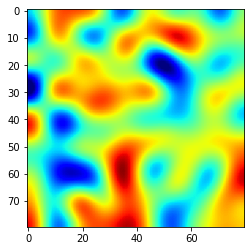

In [10]:
forecast_0 = pca.inverse_transform(y_pred2[:,:dim])
test_start = -9999
plt.imshow(elev[test_start+1600,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)
plt.imshow(ks_t[test_start+1600,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)
plt.imshow(forecast_0[1600,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)

In [11]:
class Multi_INT_net(torch.nn.Module):
        def __init__(self, params):
            super(Multi_INT_net, self).__init__()
            self.Int_net = modelRINN
        def forward(self, inp, t0, nb, dt):
            pred = [inp]
            aug  = []
            for i in range(nb):
                predic, k1, inp, aug_inp = self.Int_net(pred[-1], dt)[:4]
                pred.append(predic)
                aug.append(aug_inp)
            return torch.stack(pred), torch.stack(aug)
criterion = torch.nn.MSELoss()
model_Multi_RINN = Multi_INT_net(params)
for p in model_Multi_RINN.parameters():
    p.requires_grad = False

In [12]:
number = 10
new_init = 200
test_vars = torch.from_numpy(X_test[new_init:new_init+number,:]).float()

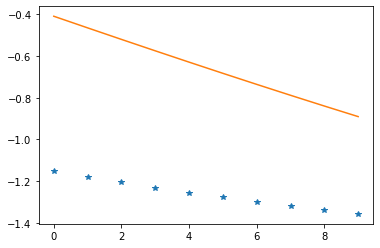

In [13]:
pred, aug = model_Multi_RINN(aug_inp, 0.0, number, 0.01)
loss_init=[]
for i in range(aug_inp.shape[0]):
    loss_init.append(criterion(pred[1:,i,:params['dim_input']] , test_vars))

min_idx = np.where(torch.stack(loss_init).data.numpy()==torch.stack(loss_init).data.numpy().min())
inp_init = aug_inp.detach().data.numpy()[min_idx[0][0]].reshape(1,dim_aug)
inp_init = (torch.from_numpy(inp_init).float())
pred_test, aug = model_Multi_RINN(inp_init, 0.0, number, 0.01)
init_pred = (pred_test.data.numpy())
plt.plot(test_vars.data.numpy()[:,0],'*')
plt.plot(init_pred[1:,0,0][:])

In [14]:
class get_init(torch.nn.Module):
    def __init__(self, params):
        super(get_init, self).__init__()
        self.Multi_INT_net = model_Multi_RINN
        self.estimate_init = torch.nn.Parameter(torch.from_numpy(pred_test[:1,0,:].data.numpy()).float())
        
    def forward(self, t0, nb, dt):
        pred, aug = self.Multi_INT_net(self.estimate_init, t0, nb, dt)
        return pred, aug
    
init_cond_model = get_init(params)
criterion = torch.nn.MSELoss(reduction = 'elementwise_mean')
optimizer3 = torch.optim.Adam(init_cond_model.parameters())
for param_group in optimizer3.param_groups:
    param_group['lr'] = 0.5
params['ntrain']=[500,10000]
for t in range(params['ntrain'][0]):
    pred = init_cond_model(0.0,test_vars.shape[0],dt)[0]
    loss = criterion(pred[1:,0,:params['dim_input']], test_vars[:,:])
    print(t,loss.data.numpy())
    optimizer3.zero_grad()
    loss.backward(retain_graph=True)
    optimizer3.step()
    if loss.detach().data.numpy()<0.000001:#0.000001:
        break

/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 0.28763962
1 0.12358241
2 0.096750505
3 0.12368307
4 0.1227982
5 0.08287189
6 0.047005687
7 0.038390413
8 0.0460369
9 0.05039786
10 0.046104696
11 0.03872256
12 0.032148514
13 0.025738237
14 0.019995965
15 0.017918773
16 0.019963166
17 0.021802
18 0.019502383
19 0.014430772
20 0.010900769
21 0.010569332
22 0.011238302
23 0.0105859395
24 0.008871209
25 0.007582166
26 0.007122813
27 0.0067498917
28 0.006041927
29 0.005386588
30 0.0050198594
31 0.0045557134
32 0.0037908042
33 0.0032243128
34 0.0032286064
35 0.0033595278
36 0.0030755058
37 0.0024955003
38 0.0020114237
39 0.0017420773
40 0.0016414049
41 0.0016735218
42 0.0017130164
43 0.0015753792
44 0.0012343125
45 0.0008821431
46 0.0007355117
47 0.000823318
48 0.00097286014
49 0.00096624286
50 0.0007326906
51 0.000438829
52 0.00033556388
53 0.00046227803
54 0.0005929594
55 0.00053499383
56 0.00035585926
57 0.00023655237
58 0.00023474976
59 0.00027998272
60 0.00029763018
61 0.00026397474
62 0.00019885474
63 0.00014699243
64 0.00013708556

In [15]:
y_pred_new=np.zeros((10000,dim_aug))
tmp = init_cond_model.estimate_init.clone()
tmp[:,:] = tmp[:,:]
y_pred_new[0,:] = tmp.cpu().data.numpy()
for i in range(10000-1):
    y_pred_new[i,:] = modelRINN(tmp,dt)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred_new[i,:],(1,dim_aug))).float())

In [17]:
forecast_new_init = pca.inverse_transform(y_pred_new[:,:100])
test_start = -9999

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [ ]:
plt.figure(0)
plt.imshow(elev[test_start+new_init+200,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)
plt.figure(1)
plt.imshow(ks_t[test_start+new_init+200,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)
plt.figure(2)
plt.imshow(forecast_new_init[200,:].reshape(80,80),cmap = 'jet',    vmin=-0.2, vmax = 0.2)
plt.colorbar()

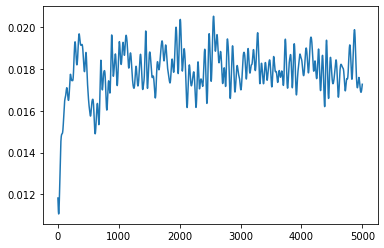

In [29]:
def RMSE(a,b):
    """ Compute the Root Mean Square Error between 2 n-dimensional vectors. """
    if (a.ndim==1):
        a = a[np.newaxis]
    if (a.ndim>2):
        a = a.reshape(a.shape[0],-1)
    if (b.ndim==1):
        b = b[np.newaxis]    
    if (b.ndim>2):
        b = b.reshape(b.shape[0],-1)
    return np.sqrt(np.nanmean((a-b)**2,1))

plt.plot(RMSE(forecast_new_init[:5000,:],elev[(test_start+new_init):,:][:5000,:]))